# Build the Conversational Search Building Blocks

<div>
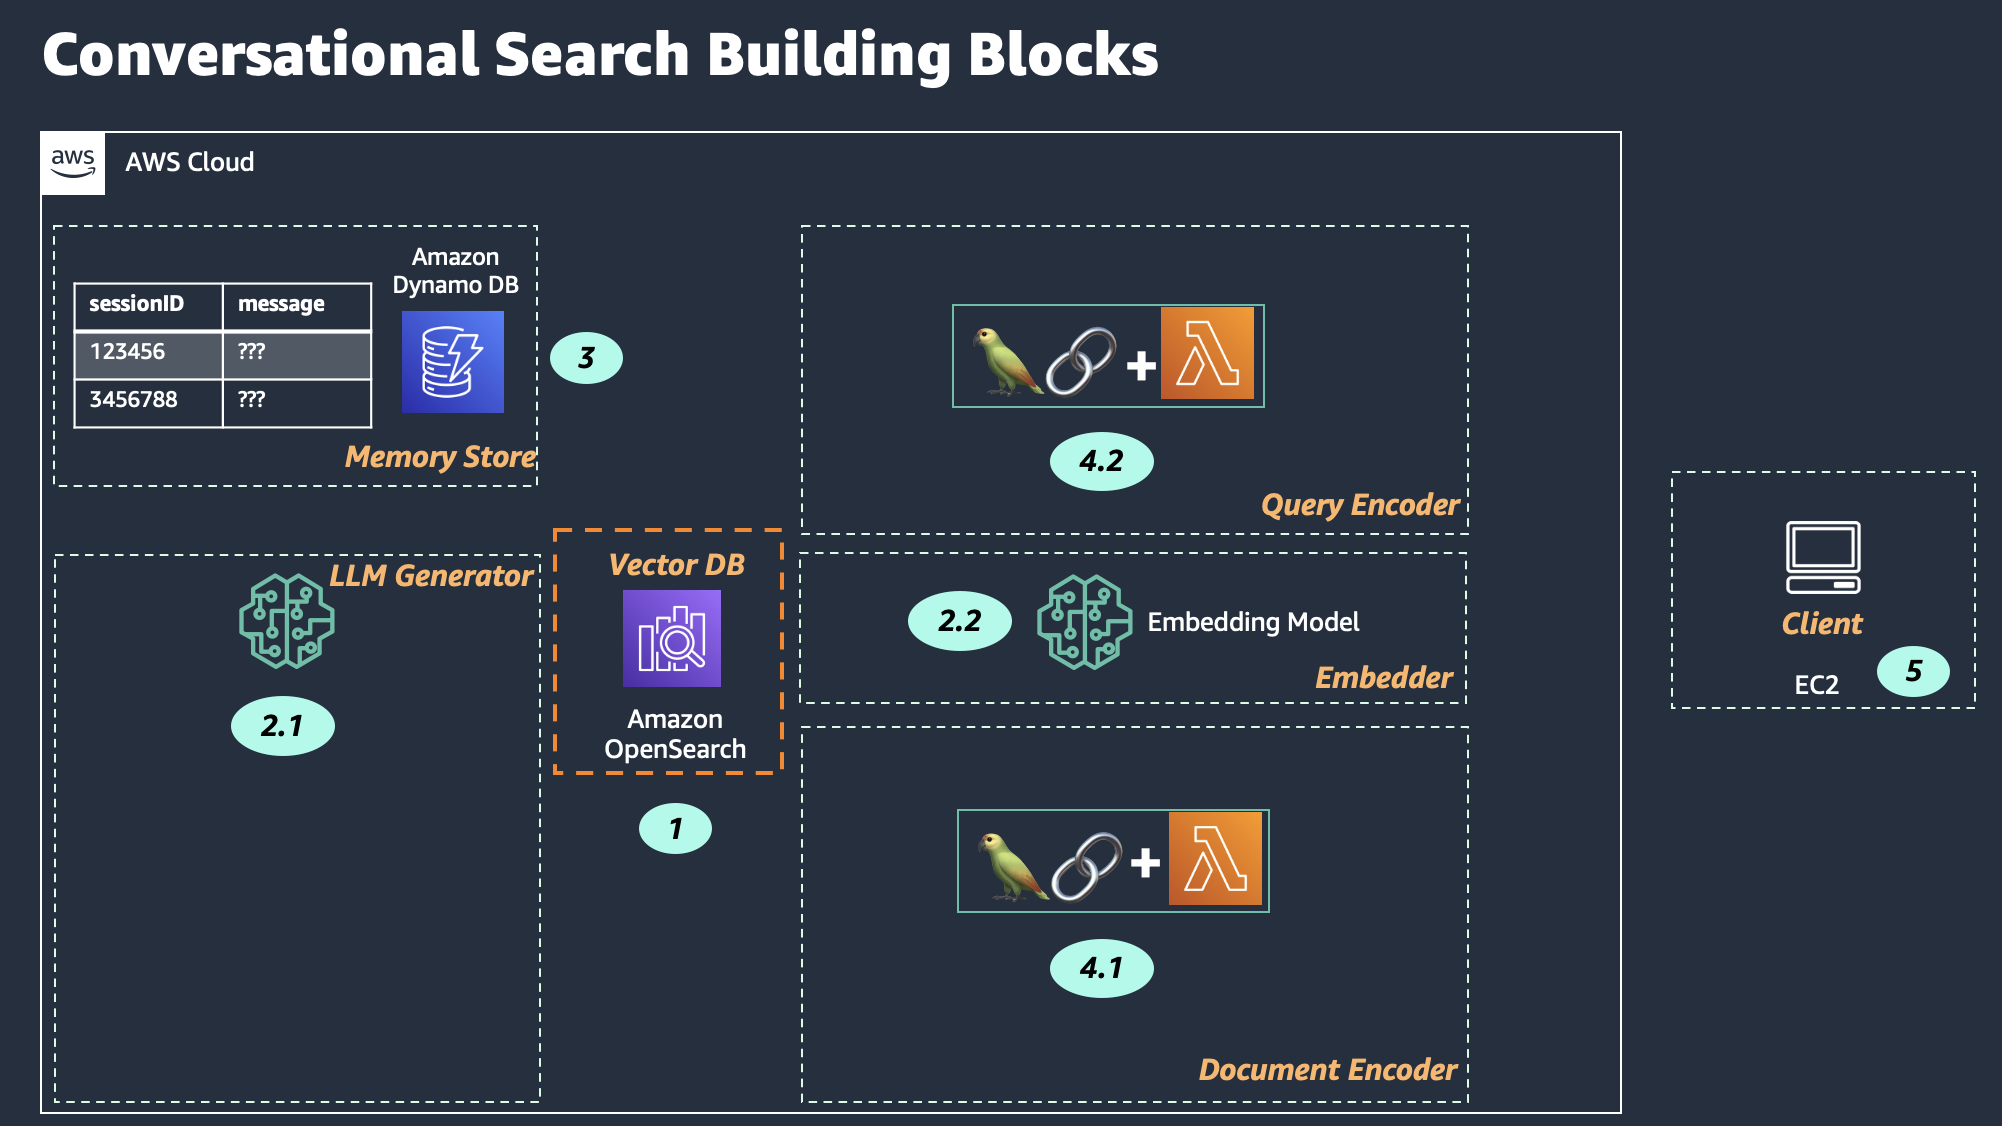
</div>

## Get the Cloudformation outputs

In [177]:
import boto3
import time
cfn = boto3.client('cloudformation')
response = cfn.list_stacks(
   StackStatusFilter=['CREATE_COMPLETE']
)
for cfns in response['StackSummaries']:
    if('semantic-search' in cfns['StackName']):
        stackname = cfns['StackName']
stackname

cfn_outputs = cfn.describe_stacks(StackName=stackname)['Stacks'][0]['Outputs']
env_variables = {}
cfn_outputs

[{'OutputKey': 'EmbeddingEndpointName',
  'OutputValue': 'opensearch-gen-ai-embedding-gpt-j-6b-ddafa2a0',
  'Description': 'Name of the LLM endpoint'},
 {'OutputKey': 'S3BucketSecureURL',
  'OutputValue': 'https://semantic-search-gpu-s3buckethosting-h5ih9fpt8gtc.s3.amazonaws.com',
  'Description': 'Name of S3 bucket to hold website content'},
 {'OutputKey': 'WebAppURL',
  'OutputValue': 'http://35.173.253.41:8501/',
  'Description': 'web app URL'},
 {'OutputKey': 'SageMakerNotebookURL',
  'OutputValue': 'https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/notebook-instances/openNotebook/semantic-search-nb?view=classic',
  'Description': 'SageMaker Notebook Instance'},
 {'OutputKey': 'OpenSearchDomainName',
  'OutputValue': 'opensearchservi-bzu7bbykwrmu',
  'Description': 'OpenSearch domain name'},
 {'OutputKey': 'OpenSearchSecret',
  'OutputValue': 'arn:aws:secretsmanager:us-east-1:005481197212:secret:OpenSearchSecret-semantic-search-gpu-O5wxOG',
  'Description': 'Name of t

## 1. OpenSearch Vector DB

<div>
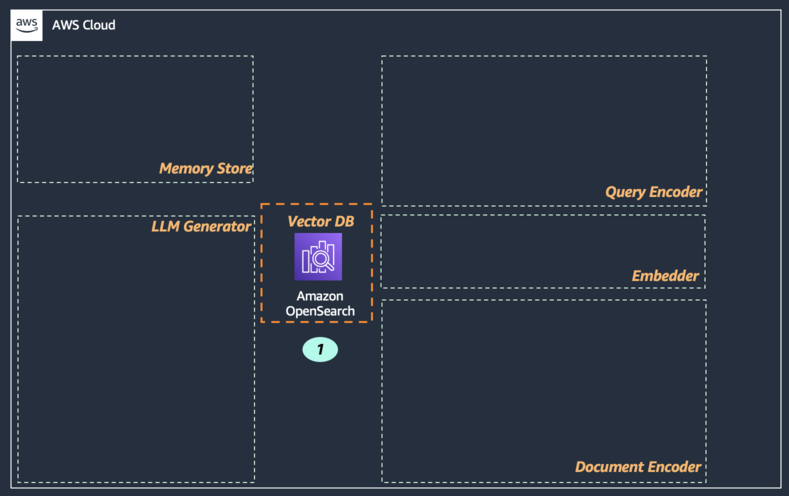
</div>

In [163]:
for output in cfn_outputs:
    if('opensearch' in output['OutputKey'].lower()):
        env_variables[output['OutputKey']] = output['OutputValue']
        
opensearch_ = boto3.client('opensearch')

response = opensearch_.describe_domain(
    DomainName=env_variables['OpenSearchDomainName']
)

print("OpenSearch Version: "+response['DomainStatus']['EngineVersion']+"\n")
print("OpenSearch Configuration\n------------------------\n")
print(json.dumps(response['DomainStatus']['ClusterConfig'], indent=4))        

OpenSearch Version: OpenSearch_2.9

OpenSearch Configuration
------------------------

{
    "InstanceType": "r6g.2xlarge.search",
    "InstanceCount": 1,
    "DedicatedMasterEnabled": false,
    "ZoneAwarenessEnabled": false,
    "WarmEnabled": false,
    "ColdStorageOptions": {
        "Enabled": false
    },
    "MultiAZWithStandbyEnabled": false
}


## 2. Embedding and LLM Endpoints


<div>
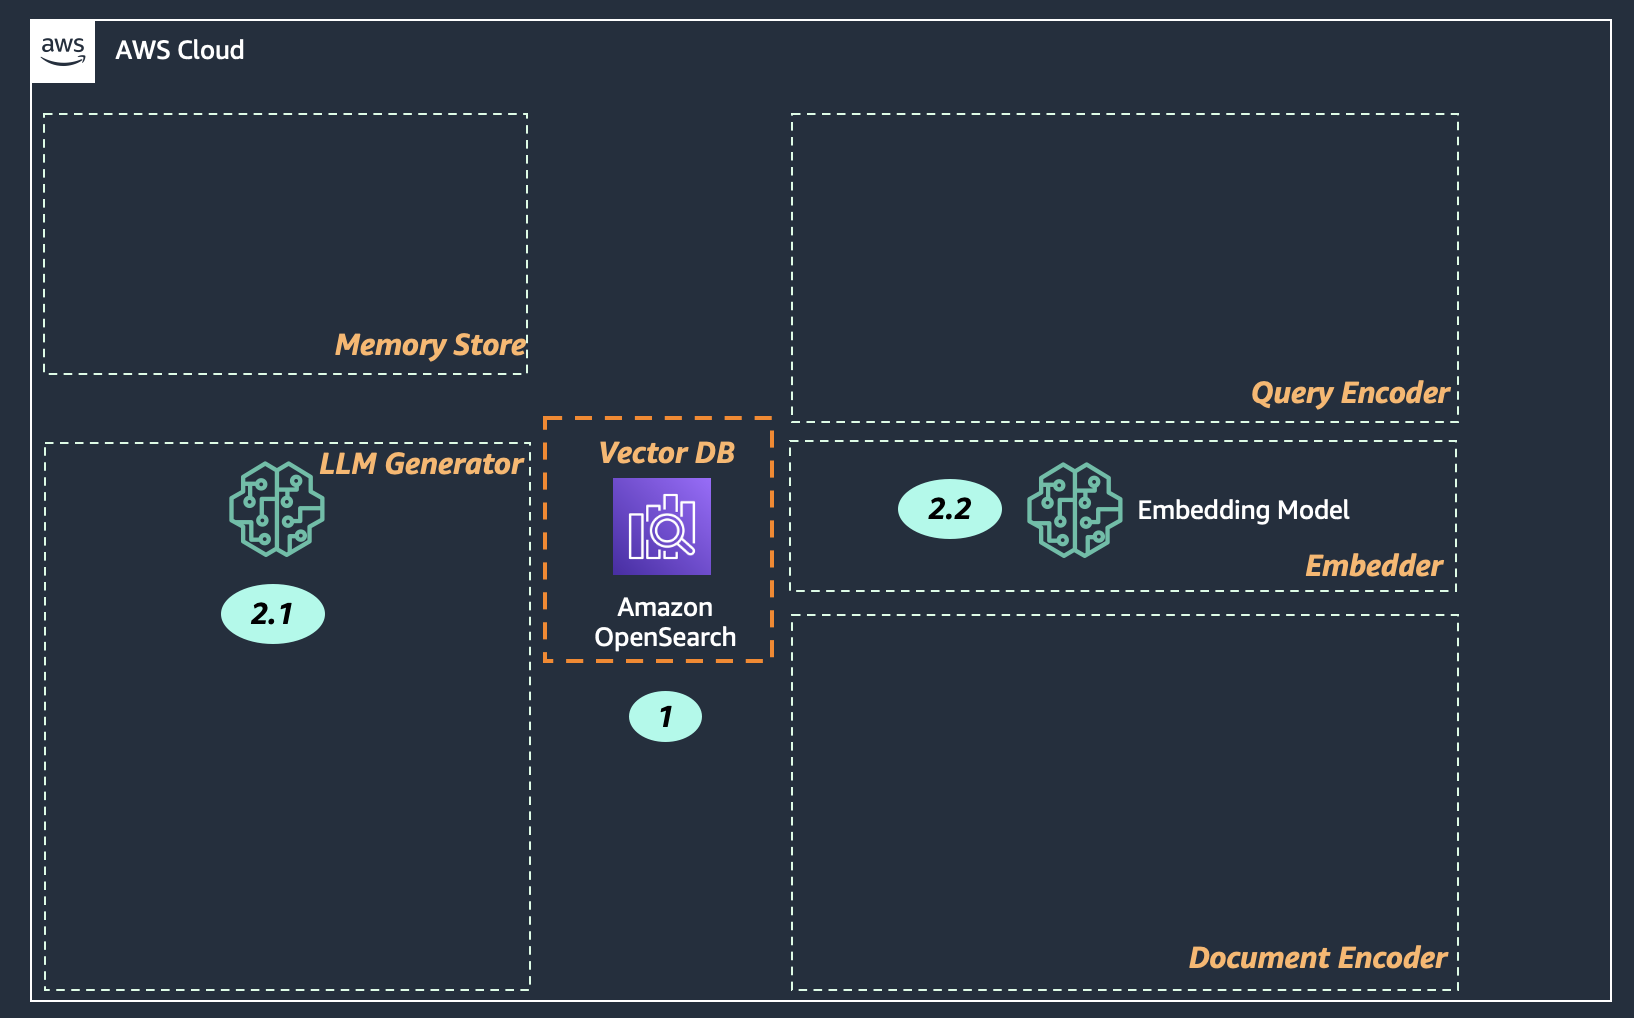
</div>

In [199]:
sagemaker_ = boto3.client('sagemaker')

for output in cfn_outputs:
    if('endpointname' in output['OutputKey'].lower()):
        env_variables[output['OutputKey']] = output['OutputValue']
        print(output['OutputKey'] + " : "+output['OutputValue']+"\n"+"------------------------------------------------")
        print(json.dumps(sagemaker_.describe_endpoint_config(EndpointConfigName = sagemaker_.describe_endpoint(
    EndpointName=output['OutputValue']
                            )['EndpointConfigName'])['ProductionVariants'][0],indent = 4))
        

EmbeddingEndpointName : opensearch-gen-ai-embedding-gpt-j-6b-ddafa2a0
------------------------------------------------
{
    "VariantName": "opensearch-gen-ai-embedding-gpt-j-6b-model-ddafa2a0",
    "ModelName": "opensearch-gen-ai-embedding-gpt-j-6b-model-ddafa2a0",
    "InitialInstanceCount": 1,
    "InstanceType": "ml.g5.2xlarge",
    "InitialVariantWeight": 1.0
}
LLMEndpointName : opensearch-gen-ai-llm-falcon-7b-bf16-ddafa2a0
------------------------------------------------
{
    "VariantName": "opensearch-gen-ai-llm-falcon-7b-bf16-ddafa2a0",
    "ModelName": "opensearch-gen-ai-llm-falcon-7b-bf16-ddafa2a0",
    "InitialInstanceCount": 1,
    "InstanceType": "ml.g5.4xlarge",
    "InitialVariantWeight": 1.0
}


## 3. Memory Store


<div>
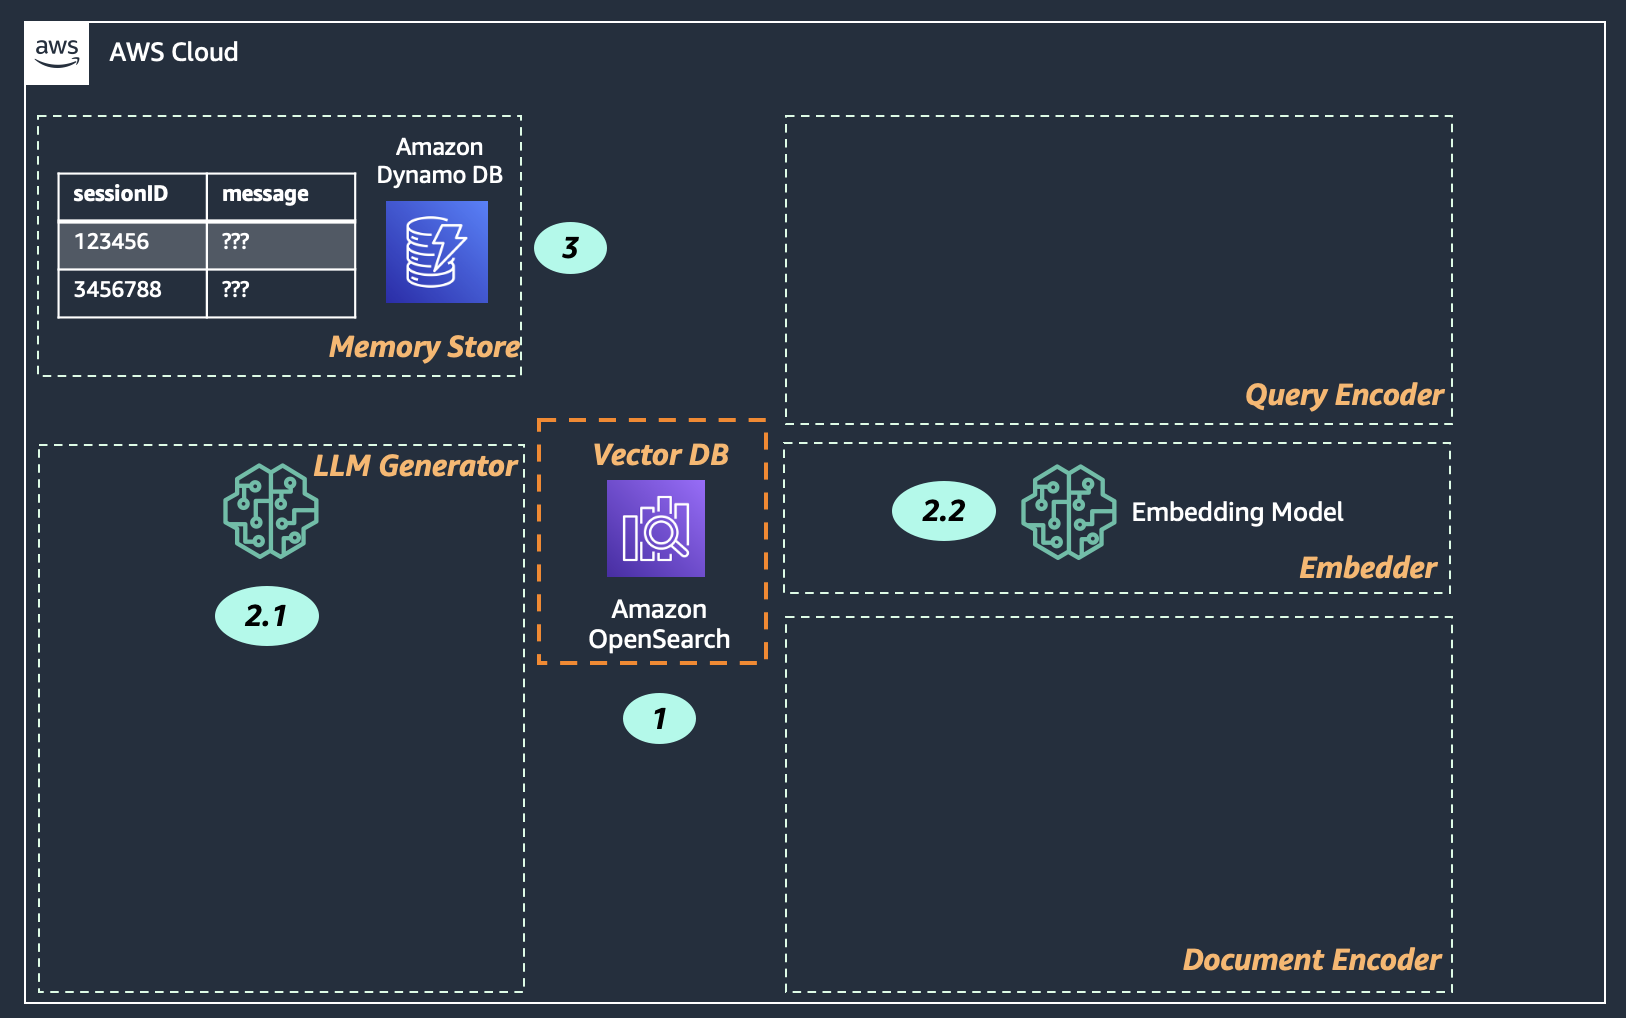
</div>

In [200]:
dynamo = boto3.client('dynamodb')

response = dynamo.create_table(
    TableName='conversation-history-memory',
    AttributeDefinitions=[
        {
            'AttributeName': 'SessionId',
            'AttributeType': 'S',
        }
    ],
    KeySchema=[
        {
            'AttributeName': 'SessionId',
            'KeyType': 'HASH',
        }
    ],
    ProvisionedThroughput={
        'ReadCapacityUnits': 5,
        'WriteCapacityUnits': 5,
    }
)
env_variables['DynamoDBTableName'] = response['TableDescription']['TableName']

print("dynamo DB Table, '"+response['TableDescription']['TableName']+"' is created")


dynamo DB Table, 'conversation-history-memory' is created


## 4. Document and Query Encoder


<div>
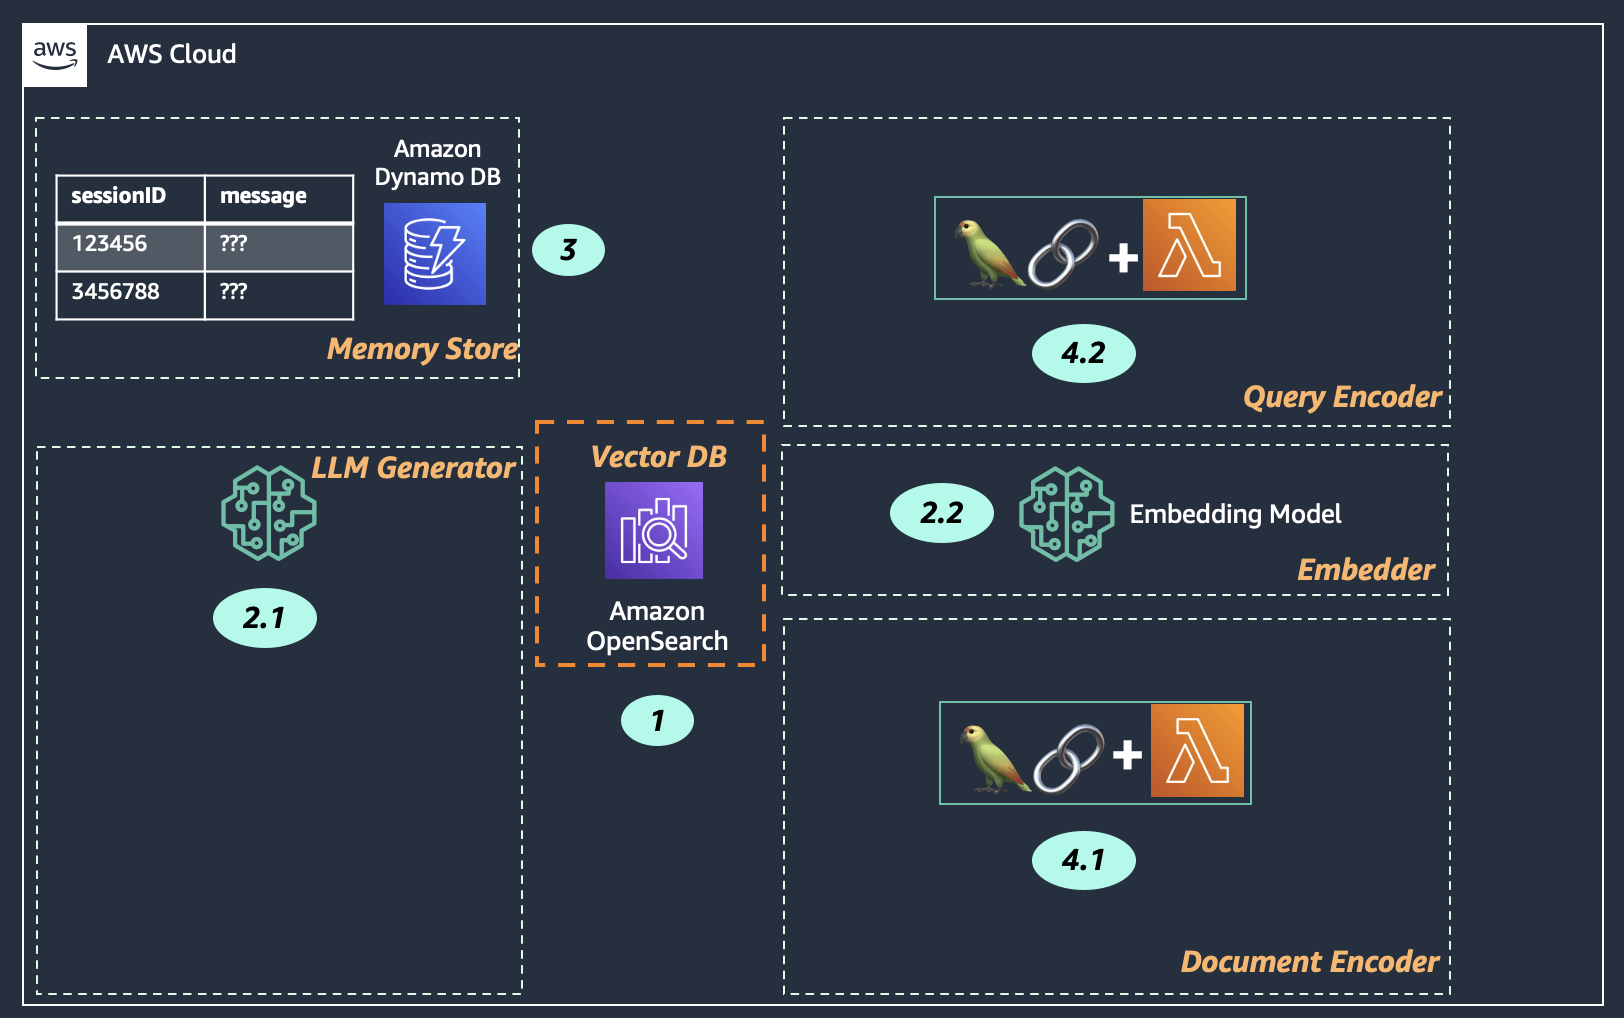
</div>

### 4.1 Package the dependant libraries and handler files for lambda functions

In [167]:
# Download the Langchain module
!aws s3 cp s3://ws-assets-prod-iad-r-gru-527b8c19222c1182/2108cfcf-6cd6-4613-83c0-db4e55998757/Langchain.zip .
    
# Create a folder for DocumentEncoder Lambda and unzip the Langchain.zip contents
!mkdir -p documentEncoder
!unzip -o Langchain.zip -d documentEncoder/
!cp -f chain_documentEncoder.py main_documentEncoder.py documentEncoder/
!cd documentEncoder && zip -r documentEncoder.zip *

# Create a folder for QueryEncoder Lambda and unzip the Langchain.zip contents
!mkdir -p queryEncoder
!unzip -o Langchain.zip -d queryEncoder/
!cp -f chain_queryEncoder.py main_queryEncoder.py queryEncoder/
!cd queryEncoder && zip -r queryEncoder.zip *

download: s3://ws-assets-prod-iad-r-gru-527b8c19222c1182/2108cfcf-6cd6-4613-83c0-db4e55998757/Langchain.zip to ./Langchain.zip
Archive:  Langchain.zip
   creating: documentEncoder/aiohttp/
  inflating: documentEncoder/aiohttp/web_ws.py  
  inflating: documentEncoder/aiohttp/worker.py  
  inflating: documentEncoder/aiohttp/_http_parser.pyx  
  inflating: documentEncoder/aiohttp/multipart.py  
  inflating: documentEncoder/aiohttp/_http_writer.pyx  
  inflating: documentEncoder/aiohttp/web_response.py  
  inflating: documentEncoder/aiohttp/client_ws.py  
  inflating: documentEncoder/aiohttp/test_utils.py  
  inflating: documentEncoder/aiohttp/tracing.py  
  inflating: documentEncoder/aiohttp/web_exceptions.py  
  inflating: documentEncoder/aiohttp/web_middlewares.py  
  inflating: documentEncoder/aiohttp/web.py  
  inflating: documentEncoder/aiohttp/http_exceptions.py  
  inflating: documentEncoder/aiohttp/web_app.py  
  inflating: documentEncoder/aiohttp/streams.py  
  inflating: documen

  inflating: documentEncoder/anyio/abc/__pycache__/_subprocesses.cpython-39.pyc  
  inflating: documentEncoder/anyio/abc/__pycache__/_tasks.cpython-39.pyc  
  inflating: documentEncoder/anyio/abc/__pycache__/_testing.cpython-39.pyc  
  inflating: documentEncoder/anyio/abc/__pycache__/_sockets.cpython-39.pyc  
  inflating: documentEncoder/anyio/abc/__pycache__/_streams.cpython-39.pyc  
  inflating: documentEncoder/anyio/_backends/__pycache__/__init__.cpython-39.pyc  
  inflating: documentEncoder/anyio/_backends/__pycache__/_asyncio.cpython-39.pyc  
  inflating: documentEncoder/anyio/_backends/__pycache__/_trio.cpython-39.pyc  
  inflating: documentEncoder/anyio/_core/__pycache__/__init__.cpython-39.pyc  
  inflating: documentEncoder/anyio/_core/__pycache__/_resources.cpython-39.pyc  
  inflating: documentEncoder/anyio/_core/__pycache__/_synchronization.cpython-39.pyc  
  inflating: documentEncoder/anyio/_core/__pycache__/_subprocesses.cpython-39.pyc  
  inflating: documentEncoder/anyio/

  inflating: documentEncoder/botocore/data/endpoints.json  
   creating: documentEncoder/botocore/data/route53/
   creating: documentEncoder/botocore/data/iot-jobs-data/
   creating: documentEncoder/botocore/data/mediapackage-vod/
   creating: documentEncoder/botocore/data/tnb/
   creating: documentEncoder/botocore/data/ec2/
   creating: documentEncoder/botocore/data/apprunner/
   creating: documentEncoder/botocore/data/lookoutmetrics/
   creating: documentEncoder/botocore/data/redshift-serverless/
  inflating: documentEncoder/botocore/docs/__pycache__/__init__.cpython-39.pyc  
  inflating: documentEncoder/botocore/docs/__pycache__/method.cpython-39.pyc  
  inflating: documentEncoder/botocore/docs/__pycache__/service.cpython-39.pyc  
  inflating: documentEncoder/botocore/docs/__pycache__/waiter.cpython-39.pyc  
  inflating: documentEncoder/botocore/docs/__pycache__/params.cpython-39.pyc  
  inflating: documentEncoder/botocore/docs/__pycache__/utils.cpython-39.pyc  
  inflating: documen

  inflating: documentEncoder/botocore/data/kms/2014-11-01/service-2.json  
  inflating: documentEncoder/botocore/data/quicksight/2018-04-01/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/quicksight/2018-04-01/examples-1.json  
  inflating: documentEncoder/botocore/data/quicksight/2018-04-01/paginators-1.json  
  inflating: documentEncoder/botocore/data/quicksight/2018-04-01/paginators-1.sdk-extras.json  
  inflating: documentEncoder/botocore/data/quicksight/2018-04-01/service-2.json  
  inflating: documentEncoder/botocore/data/workmail/2017-10-01/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/workmail/2017-10-01/examples-1.json  
  inflating: documentEncoder/botocore/data/workmail/2017-10-01/paginators-1.json  
  inflating: documentEncoder/botocore/data/workmail/2017-10-01/service-2.json  
  inflating: documentEncoder/botocore/data/frauddetector/2019-11-15/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/fraudd

  inflating: documentEncoder/botocore/data/mediaconvert/2017-08-29/service-2.json  
  inflating: documentEncoder/botocore/data/sns/2010-03-31/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/sns/2010-03-31/examples-1.json  
  inflating: documentEncoder/botocore/data/sns/2010-03-31/paginators-1.json  
  inflating: documentEncoder/botocore/data/sns/2010-03-31/service-2.json  
  inflating: documentEncoder/botocore/data/datasync/2018-11-09/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/datasync/2018-11-09/examples-1.json  
  inflating: documentEncoder/botocore/data/datasync/2018-11-09/paginators-1.json  
  inflating: documentEncoder/botocore/data/datasync/2018-11-09/service-2.json  
  inflating: documentEncoder/botocore/data/macie/2017-12-19/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/macie/2017-12-19/examples-1.json  
  inflating: documentEncoder/botocore/data/macie/2017-12-19/paginators-1.json  
  inflating: d

  inflating: documentEncoder/botocore/data/cloudfront/2015-09-17/service-2.json  
  inflating: documentEncoder/botocore/data/cloudfront/2015-09-17/waiters-2.json  
  inflating: documentEncoder/botocore/data/cloudfront/2014-10-21/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/cloudfront/2014-10-21/paginators-1.json  
  inflating: documentEncoder/botocore/data/cloudfront/2014-10-21/service-2.json  
  inflating: documentEncoder/botocore/data/cloudfront/2014-10-21/waiters-2.json  
  inflating: documentEncoder/botocore/data/cloudfront/2017-03-25/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/cloudfront/2017-03-25/paginators-1.json  
  inflating: documentEncoder/botocore/data/cloudfront/2017-03-25/service-2.json  
  inflating: documentEncoder/botocore/data/cloudfront/2017-03-25/waiters-2.json  
  inflating: documentEncoder/botocore/data/cloudfront/2018-06-18/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/cloudfront

  inflating: documentEncoder/botocore/data/resiliencehub/2020-04-30/examples-1.json  
  inflating: documentEncoder/botocore/data/resiliencehub/2020-04-30/paginators-1.json  
  inflating: documentEncoder/botocore/data/resiliencehub/2020-04-30/service-2.json  
  inflating: documentEncoder/botocore/data/route53domains/2014-05-15/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/route53domains/2014-05-15/examples-1.json  
  inflating: documentEncoder/botocore/data/route53domains/2014-05-15/paginators-1.json  
  inflating: documentEncoder/botocore/data/route53domains/2014-05-15/service-2.json  
  inflating: documentEncoder/botocore/data/macie2/2020-01-01/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/macie2/2020-01-01/paginators-1.json  
  inflating: documentEncoder/botocore/data/macie2/2020-01-01/service-2.json  
  inflating: documentEncoder/botocore/data/macie2/2020-01-01/waiters-2.json  
  inflating: documentEncoder/botocore/data/entityres

  inflating: documentEncoder/botocore/data/gamelift/2015-10-01/service-2.json  
  inflating: documentEncoder/botocore/data/lex-models/2017-04-19/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/lex-models/2017-04-19/examples-1.json  
  inflating: documentEncoder/botocore/data/lex-models/2017-04-19/paginators-1.json  
  inflating: documentEncoder/botocore/data/lex-models/2017-04-19/service-2.json  
  inflating: documentEncoder/botocore/data/cloudtrail/2013-11-01/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/cloudtrail/2013-11-01/examples-1.json  
  inflating: documentEncoder/botocore/data/cloudtrail/2013-11-01/paginators-1.json  
  inflating: documentEncoder/botocore/data/cloudtrail/2013-11-01/service-2.json  
  inflating: documentEncoder/botocore/data/mgh/2017-05-31/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/mgh/2017-05-31/examples-1.json  
  inflating: documentEncoder/botocore/data/mgh/2017-05-31/paginato

  inflating: documentEncoder/botocore/data/codedeploy/2014-10-06/service-2.json  
  inflating: documentEncoder/botocore/data/codedeploy/2014-10-06/waiters-2.json  
  inflating: documentEncoder/botocore/data/cloudhsmv2/2017-04-28/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/cloudhsmv2/2017-04-28/examples-1.json  
  inflating: documentEncoder/botocore/data/cloudhsmv2/2017-04-28/paginators-1.json  
  inflating: documentEncoder/botocore/data/cloudhsmv2/2017-04-28/service-2.json  
  inflating: documentEncoder/botocore/data/batch/2016-08-10/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/batch/2016-08-10/examples-1.json  
  inflating: documentEncoder/botocore/data/batch/2016-08-10/paginators-1.json  
  inflating: documentEncoder/botocore/data/batch/2016-08-10/service-2.json  
  inflating: documentEncoder/botocore/data/iot1click-projects/2018-05-14/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/iot1click-projects/2

  inflating: documentEncoder/botocore/data/docdb/2014-10-31/paginators-1.json  
  inflating: documentEncoder/botocore/data/docdb/2014-10-31/service-2.json  
  inflating: documentEncoder/botocore/data/docdb/2014-10-31/service-2.sdk-extras.json  
  inflating: documentEncoder/botocore/data/docdb/2014-10-31/waiters-2.json  
  inflating: documentEncoder/botocore/data/firehose/2015-08-04/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/firehose/2015-08-04/examples-1.json  
  inflating: documentEncoder/botocore/data/firehose/2015-08-04/paginators-1.json  
  inflating: documentEncoder/botocore/data/firehose/2015-08-04/service-2.json  
  inflating: documentEncoder/botocore/data/ivschat/2020-07-14/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/ivschat/2020-07-14/examples-1.json  
  inflating: documentEncoder/botocore/data/ivschat/2020-07-14/paginators-1.json  
  inflating: documentEncoder/botocore/data/ivschat/2020-07-14/service-2.json  
  inflat

  inflating: documentEncoder/botocore/data/comprehend/2017-11-27/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/comprehend/2017-11-27/examples-1.json  
  inflating: documentEncoder/botocore/data/comprehend/2017-11-27/paginators-1.json  
  inflating: documentEncoder/botocore/data/comprehend/2017-11-27/service-2.json  
  inflating: documentEncoder/botocore/data/devicefarm/2015-06-23/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/devicefarm/2015-06-23/examples-1.json  
  inflating: documentEncoder/botocore/data/devicefarm/2015-06-23/paginators-1.json  
  inflating: documentEncoder/botocore/data/devicefarm/2015-06-23/service-2.json  
  inflating: documentEncoder/botocore/data/rds-data/2018-08-01/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/rds-data/2018-08-01/examples-1.json  
  inflating: documentEncoder/botocore/data/rds-data/2018-08-01/paginators-1.json  
  inflating: documentEncoder/botocore/data/rds-data/2

  inflating: documentEncoder/botocore/data/acm/2015-12-08/service-2.json  
  inflating: documentEncoder/botocore/data/acm/2015-12-08/waiters-2.json  
  inflating: documentEncoder/botocore/data/athena/2017-05-18/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/athena/2017-05-18/examples-1.json  
  inflating: documentEncoder/botocore/data/athena/2017-05-18/paginators-1.json  
  inflating: documentEncoder/botocore/data/athena/2017-05-18/service-2.json  
  inflating: documentEncoder/botocore/data/route53/2013-04-01/endpoint-rule-set-1.json.gz  
  inflating: documentEncoder/botocore/data/route53/2013-04-01/examples-1.json  
  inflating: documentEncoder/botocore/data/route53/2013-04-01/paginators-1.json  
  inflating: documentEncoder/botocore/data/route53/2013-04-01/service-2.json  
  inflating: documentEncoder/botocore/data/route53/2013-04-01/waiters-2.json  
  inflating: documentEncoder/botocore/data/iot-jobs-data/2017-09-29/endpoint-rule-set-1.json.gz  
  inflating

   creating: documentEncoder/langchain/tools/bing_search/
   creating: documentEncoder/langchain/tools/powerbi/
   creating: documentEncoder/langchain/tools/graphql/
   creating: documentEncoder/langchain/tools/edenai/
   creating: documentEncoder/langchain/tools/steamship_image_generation/
  inflating: documentEncoder/langchain/tools/plugin.py  
   creating: documentEncoder/langchain/tools/brave_search/
   creating: documentEncoder/langchain/tools/arxiv/
   creating: documentEncoder/langchain/tools/pubmed/
   creating: documentEncoder/langchain/tools/scenexplain/
  inflating: documentEncoder/langchain/tools/yahoo_finance_news.py  
   creating: documentEncoder/langchain/tools/amadeus/
   creating: documentEncoder/langchain/tools/human/
   creating: documentEncoder/langchain/tools/openweathermap/
   creating: documentEncoder/langchain/tools/interaction/
   creating: documentEncoder/langchain/tools/metaphor_search/
  inflating: documentEncoder/langchain/tools/base.py  
   creating: docum

  inflating: documentEncoder/langchain/llms/bittensor.py  
  inflating: documentEncoder/langchain/llms/stochasticai.py  
  inflating: documentEncoder/langchain/llms/sagemaker_endpoint.py  
  inflating: documentEncoder/langchain/llms/baseten.py  
  inflating: documentEncoder/langchain/llms/anthropic.py  
  inflating: documentEncoder/langchain/llms/deepinfra.py  
  inflating: documentEncoder/langchain/llms/symblai_nebula.py  
  inflating: documentEncoder/langchain/llms/xinference.py  
  inflating: documentEncoder/langchain/llms/textgen.py  
  inflating: documentEncoder/langchain/llms/modal.py  
  inflating: documentEncoder/langchain/llms/writer.py  
  inflating: documentEncoder/langchain/llms/gradient_ai.py  
  inflating: documentEncoder/langchain/llms/bananadev.py  
  inflating: documentEncoder/langchain/llms/databricks.py  
  inflating: documentEncoder/langchain/llms/ai21.py  
  inflating: documentEncoder/langchain/llms/self_hosted_hugging_face.py  
  inflating: documentEncoder/langcha

  inflating: documentEncoder/langchain/vectorstores/__pycache__/vectara.cpython-39.pyc  
  inflating: documentEncoder/langchain/vectorstores/__pycache__/xata.cpython-39.pyc  
  inflating: documentEncoder/langchain/vectorstores/__pycache__/weaviate.cpython-39.pyc  
  inflating: documentEncoder/langchain/vectorstores/__pycache__/sklearn.cpython-39.pyc  
  inflating: documentEncoder/langchain/vectorstores/__pycache__/mongodb_atlas.cpython-39.pyc  
  inflating: documentEncoder/langchain/vectorstores/__pycache__/vald.cpython-39.pyc  
  inflating: documentEncoder/langchain/vectorstores/__pycache__/timescalevector.cpython-39.pyc  
  inflating: documentEncoder/langchain/vectorstores/__pycache__/chroma.cpython-39.pyc  
  inflating: documentEncoder/langchain/vectorstores/__pycache__/hologres.cpython-39.pyc  
  inflating: documentEncoder/langchain/vectorstores/__pycache__/usearch.cpython-39.pyc  
  inflating: documentEncoder/langchain/vectorstores/__pycache__/dashvector.cpython-39.pyc  
  inflati

  inflating: documentEncoder/langchain/indexes/__pycache__/_sql_record_manager.cpython-39.pyc  
  inflating: documentEncoder/langchain/indexes/__pycache__/_api.cpython-39.pyc  
  inflating: documentEncoder/langchain/indexes/__pycache__/graph.cpython-39.pyc  
  inflating: documentEncoder/langchain/indexes/__pycache__/vectorstore.cpython-39.pyc  
  inflating: documentEncoder/langchain/indexes/__pycache__/base.cpython-39.pyc  
  inflating: documentEncoder/langchain/indexes/prompts/entity_extraction.py  
  inflating: documentEncoder/langchain/indexes/prompts/entity_summarization.py  
  inflating: documentEncoder/langchain/indexes/prompts/__init__.py  
  inflating: documentEncoder/langchain/indexes/prompts/knowledge_triplet_extraction.py  
   creating: documentEncoder/langchain/indexes/prompts/__pycache__/
  inflating: documentEncoder/langchain/retrievers/document_compressors/__pycache__/__init__.cpython-39.pyc  
  inflating: documentEncoder/langchain/retrievers/document_compressors/__pycac

  inflating: documentEncoder/numpy/__init__.cython-30.pxd  
  inflating: documentEncoder/numpy/__init__.pyi  
  inflating: documentEncoder/numpy/_globals.py  
   creating: documentEncoder/numpy/_typing/
  inflating: documentEncoder/numpy/__init__.pxd  
   creating: documentEncoder/numpy/tests/
   creating: documentEncoder/numpy/_pyinstaller/
  inflating: documentEncoder/numpy/exceptions.pyi  
  inflating: documentEncoder/numpy/__init__.py  
   creating: documentEncoder/numpy/array_api/
  inflating: documentEncoder/numpy/dtypes.py  
  inflating: documentEncoder/numpy/_distributor_init.py  
   creating: documentEncoder/numpy/__pycache__/
  inflating: documentEncoder/numpy/__config__.py  
   creating: documentEncoder/numpy/typing/
   creating: documentEncoder/numpy/f2py/
   creating: documentEncoder/numpy/testing/
  inflating: documentEncoder/numpy/ctypeslib.py  
  inflating: documentEncoder/numpy/matlib.py  
   creating: documentEncoder/numpy/lib/
 extracting: documentEncoder/numpy/py.ty

  inflating: documentEncoder/numpy/random/mtrand.cpython-39-x86_64-linux-gnu.so  
  inflating: documentEncoder/numpy/random/bit_generator.pxd  
   creating: documentEncoder/numpy/random/_examples/
  inflating: documentEncoder/numpy/random/_sfc64.cpython-39-x86_64-linux-gnu.so  
  inflating: documentEncoder/numpy/random/mtrand.pyi  
  inflating: documentEncoder/numpy/random/_philox.cpython-39-x86_64-linux-gnu.so  
  inflating: documentEncoder/numpy/matrixlib/.DS_Store  
  inflating: documentEncoder/__MACOSX/numpy/matrixlib/._.DS_Store  
  inflating: documentEncoder/numpy/matrixlib/__init__.pyi  
   creating: documentEncoder/numpy/matrixlib/tests/
  inflating: documentEncoder/numpy/matrixlib/__init__.py  
   creating: documentEncoder/numpy/matrixlib/__pycache__/
  inflating: documentEncoder/numpy/matrixlib/setup.py  
  inflating: documentEncoder/numpy/matrixlib/defmatrix.pyi  
  inflating: documentEncoder/numpy/matrixlib/defmatrix.py  
  inflating: documentEncoder/numpy/polynomial/.DS_St

  inflating: documentEncoder/numpy/ma/tests/test_core.py  
  inflating: documentEncoder/numpy/ma/tests/test_deprecations.py  
 extracting: documentEncoder/numpy/ma/tests/__init__.py  
   creating: documentEncoder/numpy/ma/tests/__pycache__/
  inflating: documentEncoder/numpy/ma/tests/test_subclassing.py  
  inflating: documentEncoder/numpy/ma/tests/test_extras.py  
  inflating: documentEncoder/numpy/ma/tests/test_mrecords.py  
  inflating: documentEncoder/numpy/ma/tests/test_regression.py  
  inflating: documentEncoder/numpy/ma/__pycache__/__init__.cpython-39.pyc  
  inflating: documentEncoder/numpy/ma/__pycache__/mrecords.cpython-39.pyc  
  inflating: documentEncoder/numpy/ma/__pycache__/core.cpython-39.pyc  
  inflating: documentEncoder/numpy/ma/__pycache__/extras.cpython-39.pyc  
  inflating: documentEncoder/numpy/ma/__pycache__/timer_comparison.cpython-39.pyc  
  inflating: documentEncoder/numpy/ma/__pycache__/setup.cpython-39.pyc  
  inflating: documentEncoder/numpy/ma/__pycache__

  inflating: documentEncoder/numpy/core/include/numpy/ndarraytypes.h  
  inflating: documentEncoder/numpy/core/include/numpy/npy_no_deprecated_api.h  
  inflating: documentEncoder/numpy/core/include/numpy/__multiarray_api.c  
  inflating: documentEncoder/numpy/core/include/numpy/npy_3kcompat.h  
  inflating: documentEncoder/numpy/core/include/numpy/npy_os.h  
  inflating: documentEncoder/numpy/core/include/numpy/npy_endian.h  
  inflating: documentEncoder/numpy/core/include/numpy/npy_interrupt.h  
  inflating: documentEncoder/numpy/core/include/numpy/_numpyconfig.h  
  inflating: documentEncoder/numpy/core/include/numpy/_neighborhood_iterator_imp.h  
  inflating: documentEncoder/numpy/core/include/numpy/numpyconfig.h  
  inflating: documentEncoder/numpy/core/include/numpy/__ufunc_api.h  
  inflating: documentEncoder/numpy/core/include/numpy/arrayscalars.h  
   creating: documentEncoder/numpy/core/include/numpy/random/
  inflating: documentEncoder/numpy/core/include/numpy/npy_math.h  
 

  inflating: documentEncoder/numpy/random/tests/__pycache__/test_seed_sequence.cpython-39.pyc  
  inflating: documentEncoder/numpy/random/tests/__pycache__/test_generator_mt19937_regressions.cpython-39.pyc  
  inflating: documentEncoder/numpy/random/tests/__pycache__/test_extending.cpython-39.pyc  
  inflating: documentEncoder/numpy/random/tests/__pycache__/test_randomstate_regression.cpython-39.pyc  
  inflating: documentEncoder/numpy/random/tests/__pycache__/test_direct.cpython-39.pyc  
  inflating: documentEncoder/numpy/random/tests/__pycache__/test_smoke.cpython-39.pyc  
  inflating: documentEncoder/numpy/random/tests/__pycache__/test_randomstate.cpython-39.pyc  
  inflating: documentEncoder/numpy/random/tests/__pycache__/test_random.cpython-39.pyc  
  inflating: documentEncoder/numpy/random/tests/data/philox-testset-1.csv  
  inflating: documentEncoder/numpy/random/tests/data/philox-testset-2.csv  
  inflating: documentEncoder/numpy/random/tests/data/sfc64-testset-1.csv  
  inflat

  inflating: documentEncoder/opensearchpy/_async/helpers/search.pyi  
  inflating: documentEncoder/opensearchpy/_async/helpers/update_by_query.pyi  
  inflating: documentEncoder/opensearchpy/_async/helpers/mapping.py  
  inflating: documentEncoder/opensearchpy/_async/helpers/faceted_search.pyi  
  inflating: documentEncoder/opensearchpy/plugins/__pycache__/__init__.cpython-39.pyc  
  inflating: documentEncoder/opensearchpy/plugins/__pycache__/alerting.cpython-39.pyc  
  inflating: documentEncoder/opensearchpy/plugins/__pycache__/index_management.cpython-39.pyc  
  inflating: documentEncoder/opensearchpy/client/__pycache__/__init__.cpython-39.pyc  
  inflating: documentEncoder/opensearchpy/client/__pycache__/snapshot.cpython-39.pyc  
  inflating: documentEncoder/opensearchpy/client/__pycache__/indices.cpython-39.pyc  
  inflating: documentEncoder/opensearchpy/client/__pycache__/features.cpython-39.pyc  
  inflating: documentEncoder/opensearchpy/client/__pycache__/utils.cpython-39.pyc  


  inflating: documentEncoder/PyPDF2/_codecs/std.py  
  inflating: documentEncoder/PyPDF2/_codecs/__init__.py  
  inflating: documentEncoder/PyPDF2/_codecs/symbol.py  
   creating: documentEncoder/PyPDF2/_codecs/__pycache__/
  inflating: documentEncoder/PyPDF2/_codecs/pdfdoc.py  
  inflating: documentEncoder/PyPDF2/_codecs/zapfding.py  
  inflating: documentEncoder/PyPDF2/generic/__pycache__/__init__.cpython-39.pyc  
  inflating: documentEncoder/PyPDF2/generic/__pycache__/_outline.cpython-39.pyc  
  inflating: documentEncoder/PyPDF2/generic/__pycache__/_data_structures.cpython-39.pyc  
  inflating: documentEncoder/PyPDF2/generic/__pycache__/_base.cpython-39.pyc  
  inflating: documentEncoder/PyPDF2/generic/__pycache__/_utils.cpython-39.pyc  
  inflating: documentEncoder/PyPDF2/generic/__pycache__/_fit.cpython-39.pyc  
  inflating: documentEncoder/PyPDF2/generic/__pycache__/_rectangle.cpython-39.pyc  
  inflating: documentEncoder/PyPDF2/generic/__pycache__/_annotations.cpython-39.pyc  
 

  inflating: documentEncoder/sqlalchemy/orm/sync.py  
  inflating: documentEncoder/sqlalchemy/orm/interfaces.py  
  inflating: documentEncoder/sqlalchemy/orm/decl_base.py  
  inflating: documentEncoder/sqlalchemy/orm/instrumentation.py  
  inflating: documentEncoder/sqlalchemy/orm/loading.py  
  inflating: documentEncoder/sqlalchemy/orm/persistence.py  
  inflating: documentEncoder/sqlalchemy/orm/_typing.py  
  inflating: documentEncoder/sqlalchemy/orm/path_registry.py  
  inflating: documentEncoder/sqlalchemy/orm/query.py  
  inflating: documentEncoder/sqlalchemy/orm/attributes.py  
  inflating: documentEncoder/sqlalchemy/orm/strategies.py  
  inflating: documentEncoder/sqlalchemy/orm/strategy_options.py  
  inflating: documentEncoder/sqlalchemy/orm/properties.py  
  inflating: documentEncoder/sqlalchemy/orm/util.py  
  inflating: documentEncoder/sqlalchemy/orm/events.py  
  inflating: documentEncoder/sqlalchemy/orm/mapper.py  
  inflating: documentEncoder/sqlalchemy/orm/mapped_collec

  inflating: documentEncoder/sqlalchemy/testing/__pycache__/requirements.cpython-39.pyc  
  inflating: documentEncoder/sqlalchemy/testing/__pycache__/util.cpython-39.pyc  
  inflating: documentEncoder/sqlalchemy/testing/fixtures/orm.py  
  inflating: documentEncoder/sqlalchemy/testing/fixtures/__init__.py  
  inflating: documentEncoder/sqlalchemy/testing/fixtures/mypy.py  
   creating: documentEncoder/sqlalchemy/testing/fixtures/__pycache__/
  inflating: documentEncoder/sqlalchemy/testing/fixtures/sql.py  
  inflating: documentEncoder/sqlalchemy/testing/fixtures/base.py  
  inflating: documentEncoder/sqlalchemy/testing/suite/test_sequence.py  
  inflating: documentEncoder/sqlalchemy/testing/suite/test_results.py  
  inflating: documentEncoder/sqlalchemy/testing/suite/test_insert.py  
  inflating: documentEncoder/sqlalchemy/testing/suite/test_select.py  
  inflating: documentEncoder/sqlalchemy/testing/suite/test_deprecations.py  
  inflating: documentEncoder/sqlalchemy/testing/suite/tes

  inflating: documentEncoder/sqlalchemy/sql/__pycache__/naming.cpython-39.pyc  
  inflating: documentEncoder/sqlalchemy/sql/__pycache__/expression.cpython-39.pyc  
  inflating: documentEncoder/sqlalchemy/sql/__pycache__/traversals.cpython-39.pyc  
  inflating: documentEncoder/sqlalchemy/sql/__pycache__/_orm_types.cpython-39.pyc  
  inflating: documentEncoder/sqlalchemy/sql/__pycache__/operators.cpython-39.pyc  
  inflating: documentEncoder/sqlalchemy/sql/__pycache__/selectable.cpython-39.pyc  
  inflating: documentEncoder/sqlalchemy/sql/__pycache__/crud.cpython-39.pyc  
  inflating: documentEncoder/sqlalchemy/sql/__pycache__/visitors.cpython-39.pyc  
  inflating: documentEncoder/sqlalchemy/sql/__pycache__/roles.cpython-39.pyc  
  inflating: documentEncoder/sqlalchemy/sql/__pycache__/util.cpython-39.pyc  
  inflating: documentEncoder/sqlalchemy/sql/__pycache__/_selectable_constructors.cpython-39.pyc  
  inflating: documentEncoder/sqlalchemy/sql/__pycache__/elements.cpython-39.pyc  
  in

  inflating: documentEncoder/certifi/cacert.pem  
  inflating: documentEncoder/certifi/__main__.py  
  inflating: documentEncoder/certifi/__pycache__/__init__.cpython-39.pyc  
  inflating: documentEncoder/certifi/__pycache__/core.cpython-39.pyc  
  inflating: documentEncoder/certifi/__pycache__/__main__.cpython-39.pyc  
  inflating: documentEncoder/config.py  
   creating: documentEncoder/dataclasses_json/
  inflating: documentEncoder/dataclasses_json/cfg.py  
  inflating: documentEncoder/dataclasses_json/__init__.py  
  inflating: documentEncoder/dataclasses_json/core.py  
  inflating: documentEncoder/dataclasses_json/__version__.py  
   creating: documentEncoder/dataclasses_json/__pycache__/
  inflating: documentEncoder/dataclasses_json/api.py  
  inflating: documentEncoder/dataclasses_json/utils.py  
  inflating: documentEncoder/dataclasses_json/undefined.py  
  inflating: documentEncoder/dataclasses_json/mm.py  
 extracting: documentEncoder/dataclasses_json/py.typed  
  inflating: 

  inflating: documentEncoder/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so  
   creating: documentEncoder/packaging/
  inflating: documentEncoder/packaging/tags.py  
  inflating: documentEncoder/packaging/_musllinux.py  
  inflating: documentEncoder/packaging/metadata.py  
  inflating: documentEncoder/packaging/version.py  
  inflating: documentEncoder/packaging/__init__.py  
   creating: documentEncoder/packaging/__pycache__/
  inflating: documentEncoder/packaging/_parser.py  
  inflating: documentEncoder/packaging/utils.py  
  inflating: documentEncoder/packaging/requirements.py  
  inflating: documentEncoder/packaging/_structures.py  
  inflating: documentEncoder/packaging/markers.py  
 extracting: documentEncoder/packaging/py.typed  
  inflating: documentEncoder/packaging/_manylinux.py  
  inflating: documentEncoder/packaging/_tokenizer.py  
  inflating: documentEncoder/packaging/specifiers.py  
  inflating: documentEncoder/packaging/_elffile.py  
  inflating: documentEncoder/

  inflating: documentEncoder/yaml/_yaml.cpython-39-x86_64-linux-gnu.so  
  inflating: documentEncoder/yaml/nodes.py  
  inflating: documentEncoder/yaml/emitter.py  
  inflating: documentEncoder/yaml/__pycache__/__init__.cpython-39.pyc  
  inflating: documentEncoder/yaml/__pycache__/error.cpython-39.pyc  
  inflating: documentEncoder/yaml/__pycache__/composer.cpython-39.pyc  
  inflating: documentEncoder/yaml/__pycache__/events.cpython-39.pyc  
  inflating: documentEncoder/yaml/__pycache__/dumper.cpython-39.pyc  
  inflating: documentEncoder/yaml/__pycache__/resolver.cpython-39.pyc  
  inflating: documentEncoder/yaml/__pycache__/representer.cpython-39.pyc  
  inflating: documentEncoder/yaml/__pycache__/emitter.cpython-39.pyc  
  inflating: documentEncoder/yaml/__pycache__/constructor.cpython-39.pyc  
  inflating: documentEncoder/yaml/__pycache__/reader.cpython-39.pyc  
  inflating: documentEncoder/yaml/__pycache__/nodes.cpython-39.pyc  
  inflating: documentEncoder/yaml/__pycache__/cyam

  adding: boto3/data/ec2/2015-10-01/resources-1.json (deflated 94%)
  adding: boto3/data/ec2/2016-09-15/ (stored 0%)
  adding: boto3/data/ec2/2016-09-15/resources-1.json (deflated 94%)
  adding: boto3/data/ec2/2015-04-15/ (stored 0%)
  adding: boto3/data/ec2/2015-04-15/resources-1.json (deflated 94%)
  adding: boto3/data/ec2/2016-11-15/ (stored 0%)
  adding: boto3/data/ec2/2016-11-15/resources-1.json (deflated 94%)
  adding: boto3/data/ec2/2015-03-01/ (stored 0%)
  adding: boto3/data/ec2/2015-03-01/resources-1.json (deflated 94%)
  adding: boto3/data/glacier/ (stored 0%)
  adding: boto3/data/glacier/2012-06-01/ (stored 0%)
  adding: boto3/data/glacier/2012-06-01/resources-1.json (deflated 94%)
  adding: boto3/exceptions.py (deflated 64%)
  adding: boto3/compat.py (deflated 54%)
  adding: boto3/examples/ (stored 0%)
  adding: boto3/examples/cloudfront.rst (deflated 55%)
  adding: boto3/examples/s3.rst (deflated 70%)
  adding: boto3/dynamodb/ (stored 0%)
  adding: boto3/dynamodb/table.py

  adding: botocore/data/outposts/2019-12-03/service-2.json (deflated 87%)
  adding: botocore/data/outposts/2019-12-03/examples-1.json (deflated 7%)
  adding: botocore/data/outposts/2019-12-03/paginators-1.json (deflated 82%)
  adding: botocore/data/outposts/2019-12-03/paginators-1.sdk-extras.json (deflated 38%)
  adding: botocore/data/ivschat/ (stored 0%)
  adding: botocore/data/ivschat/2020-07-14/ (stored 0%)
  adding: botocore/data/ivschat/2020-07-14/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/ivschat/2020-07-14/service-2.json (deflated 87%)
  adding: botocore/data/ivschat/2020-07-14/examples-1.json (deflated 7%)
  adding: botocore/data/ivschat/2020-07-14/paginators-1.json (stored 0%)
  adding: botocore/data/emr/ (stored 0%)
  adding: botocore/data/emr/2009-03-31/ (stored 0%)
  adding: botocore/data/emr/2009-03-31/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/emr/2009-03-31/service-2.json (deflated 84%)
  adding: botocore/data/emr/2009-03-31/exam

  adding: botocore/data/cloudfront/2015-09-17/service-2.json (deflated 88%)
  adding: botocore/data/cloudfront/2015-09-17/waiters-2.json (deflated 75%)
  adding: botocore/data/cloudfront/2015-09-17/paginators-1.json (deflated 79%)
  adding: botocore/data/cloudfront/2016-11-25/ (stored 0%)
  adding: botocore/data/cloudfront/2016-11-25/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/cloudfront/2016-11-25/service-2.json (deflated 86%)
  adding: botocore/data/cloudfront/2016-11-25/examples-1.json (deflated 7%)
  adding: botocore/data/cloudfront/2016-11-25/waiters-2.json (deflated 75%)
  adding: botocore/data/cloudfront/2016-11-25/paginators-1.json (deflated 79%)
  adding: botocore/data/cloudfront/2016-01-13/ (stored 0%)
  adding: botocore/data/cloudfront/2016-01-13/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/cloudfront/2016-01-13/service-2.json (deflated 88%)
  adding: botocore/data/cloudfront/2016-01-13/waiters-2.json (deflated 75%)
  adding: botocore/d

  adding: botocore/data/quicksight/2018-04-01/service-2.json (deflated 88%)
  adding: botocore/data/quicksight/2018-04-01/examples-1.json (deflated 7%)
  adding: botocore/data/quicksight/2018-04-01/paginators-1.json (deflated 92%)
  adding: botocore/data/quicksight/2018-04-01/paginators-1.sdk-extras.json (deflated 91%)
  adding: botocore/data/iot-data/ (stored 0%)
  adding: botocore/data/iot-data/2015-05-28/ (stored 0%)
  adding: botocore/data/iot-data/2015-05-28/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/iot-data/2015-05-28/service-2.json (deflated 84%)
  adding: botocore/data/iot-data/2015-05-28/examples-1.json (deflated 7%)
  adding: botocore/data/iot-data/2015-05-28/paginators-1.json (deflated 40%)
  adding: botocore/data/pinpoint-sms-voice-v2/ (stored 0%)
  adding: botocore/data/pinpoint-sms-voice-v2/2022-03-31/ (stored 0%)
  adding: botocore/data/pinpoint-sms-voice-v2/2022-03-31/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/pinpoint-sms-voic

  adding: botocore/data/iam/2010-05-08/service-2.json (deflated 89%)
  adding: botocore/data/iam/2010-05-08/examples-1.json (deflated 84%)
  adding: botocore/data/iam/2010-05-08/waiters-2.json (deflated 82%)
  adding: botocore/data/iam/2010-05-08/paginators-1.json (deflated 92%)
  adding: botocore/data/finspace-data/ (stored 0%)
  adding: botocore/data/finspace-data/2020-07-13/ (stored 0%)
  adding: botocore/data/finspace-data/2020-07-13/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/finspace-data/2020-07-13/service-2.json (deflated 88%)
  adding: botocore/data/finspace-data/2020-07-13/examples-1.json (deflated 7%)
  adding: botocore/data/finspace-data/2020-07-13/paginators-1.json (deflated 80%)
  adding: botocore/data/cognito-sync/ (stored 0%)
  adding: botocore/data/cognito-sync/2014-06-30/ (stored 0%)
  adding: botocore/data/cognito-sync/2014-06-30/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/cognito-sync/2014-06-30/service-2.json (deflated 88%)
 

  adding: botocore/data/codecommit/2015-04-13/service-2.json (deflated 89%)
  adding: botocore/data/codecommit/2015-04-13/examples-1.json (deflated 7%)
  adding: botocore/data/codecommit/2015-04-13/paginators-1.json (deflated 80%)
  adding: botocore/data/mturk/ (stored 0%)
  adding: botocore/data/mturk/2017-01-17/ (stored 0%)
  adding: botocore/data/mturk/2017-01-17/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/mturk/2017-01-17/service-2.json (deflated 84%)
  adding: botocore/data/mturk/2017-01-17/examples-1.json (deflated 7%)
  adding: botocore/data/mturk/2017-01-17/paginators-1.json (deflated 85%)
  adding: botocore/data/sqs/ (stored 0%)
  adding: botocore/data/sqs/2012-11-05/ (stored 0%)
  adding: botocore/data/sqs/2012-11-05/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/sqs/2012-11-05/service-2.json (deflated 84%)
  adding: botocore/data/sqs/2012-11-05/examples-1.json (deflated 7%)
  adding: botocore/data/sqs/2012-11-05/paginators-1.json (deflate

  adding: botocore/data/lakeformation/2017-03-31/service-2.json (deflated 87%)
  adding: botocore/data/lakeformation/2017-03-31/examples-1.json (deflated 7%)
  adding: botocore/data/lakeformation/2017-03-31/paginators-1.json (deflated 78%)
  adding: botocore/data/lakeformation/2017-03-31/paginators-1.sdk-extras.json (deflated 33%)
  adding: botocore/data/directconnect/ (stored 0%)
  adding: botocore/data/directconnect/2012-10-25/ (stored 0%)
  adding: botocore/data/directconnect/2012-10-25/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/directconnect/2012-10-25/service-2.json (deflated 89%)
  adding: botocore/data/directconnect/2012-10-25/examples-1.json (deflated 7%)
  adding: botocore/data/directconnect/2012-10-25/paginators-1.json (deflated 76%)
  adding: botocore/data/mediatailor/ (stored 0%)
  adding: botocore/data/mediatailor/2018-04-23/ (stored 0%)
  adding: botocore/data/mediatailor/2018-04-23/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/media

  adding: botocore/data/waf/2015-08-24/service-2.json (deflated 90%)
  adding: botocore/data/waf/2015-08-24/examples-1.json (deflated 90%)
  adding: botocore/data/waf/2015-08-24/paginators-1.json (deflated 88%)
  adding: botocore/data/license-manager-linux-subscriptions/ (stored 0%)
  adding: botocore/data/license-manager-linux-subscriptions/2018-05-10/ (stored 0%)
  adding: botocore/data/license-manager-linux-subscriptions/2018-05-10/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/license-manager-linux-subscriptions/2018-05-10/service-2.json (deflated 84%)
  adding: botocore/data/license-manager-linux-subscriptions/2018-05-10/paginators-1.json (deflated 65%)
  adding: botocore/data/drs/ (stored 0%)
  adding: botocore/data/drs/2020-02-26/ (stored 0%)
  adding: botocore/data/drs/2020-02-26/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/drs/2020-02-26/service-2.json (deflated 88%)
  adding: botocore/data/drs/2020-02-26/examples-1.json (deflated 7%)
  addi

  adding: botocore/data/codebuild/2016-10-06/service-2.json (deflated 85%)
  adding: botocore/data/codebuild/2016-10-06/examples-1.json (deflated 87%)
  adding: botocore/data/codebuild/2016-10-06/paginators-1.json (deflated 87%)
  adding: botocore/data/_retry.json (deflated 87%)
  adding: botocore/data/databrew/ (stored 0%)
  adding: botocore/data/databrew/2017-07-25/ (stored 0%)
  adding: botocore/data/databrew/2017-07-25/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/databrew/2017-07-25/service-2.json (deflated 87%)
  adding: botocore/data/databrew/2017-07-25/examples-1.json (deflated 7%)
  adding: botocore/data/databrew/2017-07-25/paginators-1.json (deflated 86%)
  adding: botocore/data/neptunedata/ (stored 0%)
  adding: botocore/data/neptunedata/2023-08-01/ (stored 0%)
  adding: botocore/data/neptunedata/2023-08-01/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/neptunedata/2023-08-01/service-2.json (deflated 88%)
  adding: botocore/data/neptunedata

  adding: botocore/data/workdocs/2016-05-01/service-2.json (deflated 89%)
  adding: botocore/data/workdocs/2016-05-01/examples-1.json (deflated 7%)
  adding: botocore/data/workdocs/2016-05-01/paginators-1.json (deflated 84%)
  adding: botocore/data/fis/ (stored 0%)
  adding: botocore/data/fis/2020-12-01/ (stored 0%)
  adding: botocore/data/fis/2020-12-01/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/fis/2020-12-01/service-2.json (deflated 90%)
  adding: botocore/data/fis/2020-12-01/examples-1.json (deflated 7%)
  adding: botocore/data/fis/2020-12-01/paginators-1.json (stored 0%)
  adding: botocore/data/iotanalytics/ (stored 0%)
  adding: botocore/data/iotanalytics/2017-11-27/ (stored 0%)
  adding: botocore/data/iotanalytics/2017-11-27/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/iotanalytics/2017-11-27/service-2.json (deflated 87%)
  adding: botocore/data/iotanalytics/2017-11-27/examples-1.json (deflated 7%)
  adding: botocore/data/iotanalytics/2017

  adding: botocore/data/logs/2014-03-28/service-2.json (deflated 85%)
  adding: botocore/data/logs/2014-03-28/examples-1.json (deflated 7%)
  adding: botocore/data/logs/2014-03-28/paginators-1.json (deflated 83%)
  adding: botocore/data/backup-gateway/ (stored 0%)
  adding: botocore/data/backup-gateway/2021-01-01/ (stored 0%)
  adding: botocore/data/backup-gateway/2021-01-01/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/backup-gateway/2021-01-01/service-2.json (deflated 88%)
  adding: botocore/data/backup-gateway/2021-01-01/examples-1.json (deflated 7%)
  adding: botocore/data/backup-gateway/2021-01-01/paginators-1.json (deflated 73%)
  adding: botocore/data/payment-cryptography-data/ (stored 0%)
  adding: botocore/data/payment-cryptography-data/2022-02-03/ (stored 0%)
  adding: botocore/data/payment-cryptography-data/2022-02-03/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/payment-cryptography-data/2022-02-03/service-2.json (deflated 89%)
  adding: 

  adding: botocore/data/cloudformation/2010-05-15/service-2.json (deflated 86%)
  adding: botocore/data/cloudformation/2010-05-15/examples-1.json (deflated 7%)
  adding: botocore/data/cloudformation/2010-05-15/waiters-2.json (deflated 92%)
  adding: botocore/data/cloudformation/2010-05-15/paginators-1.json (deflated 84%)
  adding: botocore/data/iotsecuretunneling/ (stored 0%)
  adding: botocore/data/iotsecuretunneling/2018-10-05/ (stored 0%)
  adding: botocore/data/iotsecuretunneling/2018-10-05/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/iotsecuretunneling/2018-10-05/service-2.json (deflated 83%)
  adding: botocore/data/iotsecuretunneling/2018-10-05/examples-1.json (deflated 7%)
  adding: botocore/data/iotsecuretunneling/2018-10-05/paginators-1.json (stored 0%)
  adding: botocore/data/voice-id/ (stored 0%)
  adding: botocore/data/voice-id/2021-09-27/ (stored 0%)
  adding: botocore/data/voice-id/2021-09-27/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/da

  adding: botocore/data/sagemaker/2017-07-24/service-2.json (deflated 85%)
  adding: botocore/data/sagemaker/2017-07-24/examples-1.json (deflated 7%)
  adding: botocore/data/sagemaker/2017-07-24/waiters-2.json (deflated 92%)
  adding: botocore/data/sagemaker/2017-07-24/paginators-1.json (deflated 92%)
  adding: botocore/data/firehose/ (stored 0%)
  adding: botocore/data/firehose/2015-08-04/ (stored 0%)
  adding: botocore/data/firehose/2015-08-04/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/firehose/2015-08-04/service-2.json (deflated 86%)
  adding: botocore/data/firehose/2015-08-04/examples-1.json (deflated 7%)
  adding: botocore/data/firehose/2015-08-04/paginators-1.json (stored 0%)
  adding: botocore/data/arc-zonal-shift/ (stored 0%)
  adding: botocore/data/arc-zonal-shift/2022-10-30/ (stored 0%)
  adding: botocore/data/arc-zonal-shift/2022-10-30/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/arc-zonal-shift/2022-10-30/service-2.json (deflated 86%)

  adding: botocore/data/rds/2014-09-01/service-2.json (deflated 88%)
  adding: botocore/data/rds/2014-09-01/waiters-2.json (deflated 88%)
  adding: botocore/data/rds/2014-09-01/paginators-1.json (deflated 88%)
  adding: botocore/data/codestar-connections/ (stored 0%)
  adding: botocore/data/codestar-connections/2019-12-01/ (stored 0%)
  adding: botocore/data/codestar-connections/2019-12-01/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/codestar-connections/2019-12-01/service-2.json (deflated 85%)
  adding: botocore/data/codestar-connections/2019-12-01/examples-1.json (deflated 7%)
  adding: botocore/data/codestar-connections/2019-12-01/paginators-1.json (stored 0%)
  adding: botocore/data/athena/ (stored 0%)
  adding: botocore/data/athena/2017-05-18/ (stored 0%)
  adding: botocore/data/athena/2017-05-18/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/athena/2017-05-18/service-2.json (deflated 87%)
  adding: botocore/data/athena/2017-05-18/examples-1.jso

  adding: botocore/data/kinesisanalytics/2015-08-14/service-2.json (deflated 88%)
  adding: botocore/data/kinesisanalytics/2015-08-14/examples-1.json (deflated 7%)
  adding: botocore/data/kinesisanalytics/2015-08-14/paginators-1.json (stored 0%)
  adding: botocore/data/iot1click-devices/ (stored 0%)
  adding: botocore/data/iot1click-devices/2018-05-14/ (stored 0%)
  adding: botocore/data/iot1click-devices/2018-05-14/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/iot1click-devices/2018-05-14/service-2.json (deflated 89%)
  adding: botocore/data/iot1click-devices/2018-05-14/paginators-1.json (deflated 65%)
  adding: botocore/data/ec2/ (stored 0%)
  adding: botocore/data/ec2/2014-10-01/ (stored 0%)
  adding: botocore/data/ec2/2014-10-01/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/ec2/2014-10-01/service-2.json (deflated 87%)
  adding: botocore/data/ec2/2014-10-01/waiters-2.json (deflated 92%)
  adding: botocore/data/ec2/2014-10-01/paginators-1.json (def

  adding: botocore/data/elb/2012-06-01/service-2.json (deflated 87%)
  adding: botocore/data/elb/2012-06-01/examples-1.json (deflated 88%)
  adding: botocore/data/elb/2012-06-01/waiters-2.json (deflated 78%)
  adding: botocore/data/elb/2012-06-01/paginators-1.json (deflated 59%)
  adding: botocore/data/backup/ (stored 0%)
  adding: botocore/data/backup/2018-11-15/ (stored 0%)
  adding: botocore/data/backup/2018-11-15/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/backup/2018-11-15/service-2.json (deflated 88%)
  adding: botocore/data/backup/2018-11-15/examples-1.json (deflated 7%)
  adding: botocore/data/backup/2018-11-15/paginators-1.json (deflated 89%)
  adding: botocore/data/translate/ (stored 0%)
  adding: botocore/data/translate/2017-07-01/ (stored 0%)
  adding: botocore/data/translate/2017-07-01/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/translate/2017-07-01/service-2.json (deflated 85%)
  adding: botocore/data/translate/2017-07-01/examples-1

  adding: botocore/credentials.py (deflated 78%)
  adding: botocore/crt/ (stored 0%)
  adding: botocore/crt/auth.py (deflated 82%)
  adding: botocore/crt/__init__.py (deflated 43%)
  adding: botocore/crt/__pycache__/ (stored 0%)
  adding: botocore/crt/__pycache__/auth.cpython-39.pyc (deflated 62%)
  adding: botocore/crt/__pycache__/__init__.cpython-39.pyc (deflated 15%)
  adding: botocore/serialize.py (deflated 75%)
  adding: botocore/endpoint_provider.py (deflated 74%)
  adding: botocore/errorfactory.py (deflated 66%)
  adding: botocore/configloader.py (deflated 67%)
  adding: botocore/.DS_Store (deflated 93%)
  adding: botocore/hooks.py (deflated 76%)
  adding: botocore/configprovider.py (deflated 77%)
  adding: botocore/eventstream.py (deflated 77%)
  adding: botocore/paginate.py (deflated 75%)
  adding: botocore/translate.py (deflated 60%)
  adding: botocore/handlers.py (deflated 73%)
  adding: botocore/__init__.py (deflated 60%)
  adding: botocore/waiter.py (deflated 73%)
  adding

  adding: dateutil/zoneinfo/dateutil-zoneinfo.tar.gz (deflated 3%)
  adding: dateutil/zoneinfo/rebuild.py (deflated 56%)
  adding: dateutil/zoneinfo/__init__.py (deflated 65%)
  adding: dateutil/zoneinfo/__pycache__/ (stored 0%)
  adding: dateutil/zoneinfo/__pycache__/__init__.cpython-39.pyc (deflated 53%)
  adding: dateutil/zoneinfo/__pycache__/rebuild.cpython-39.pyc (deflated 37%)
  adding: dateutil/__pycache__/ (stored 0%)
  adding: dateutil/__pycache__/__init__.cpython-39.pyc (deflated 19%)
  adding: dateutil/__pycache__/_version.cpython-39.pyc (deflated 18%)
  adding: dateutil/__pycache__/tzwin.cpython-39.pyc (deflated 15%)
  adding: dateutil/__pycache__/rrule.cpython-39.pyc (deflated 56%)
  adding: dateutil/__pycache__/relativedelta.cpython-39.pyc (deflated 56%)
  adding: dateutil/__pycache__/easter.cpython-39.pyc (deflated 41%)
  adding: dateutil/__pycache__/_common.cpython-39.pyc (deflated 45%)
  adding: dateutil/__pycache__/utils.cpython-39.pyc (deflated 49%)
  adding: excepti

  adding: greenlet/_greenlet.cpython-39-x86_64-linux-gnu.so (deflated 73%)
  adding: greenlet/slp_platformselect.h (deflated 78%)
  adding: greenlet/greenlet_cpython_add_pending.hpp (deflated 57%)
  adding: greenlet/greenlet_thread_state_dict_cleanup.hpp (deflated 71%)
  adding: greenlet/greenlet_thread_support.hpp (deflated 45%)
  adding: greenlet/TGreenlet.cpp (deflated 69%)
  adding: greenlet/.DS_Store (deflated 95%)
  adding: greenlet/greenlet_thread_state.hpp (deflated 69%)
  adding: greenlet/TPythonState.cpp (deflated 67%)
  adding: greenlet/__init__.py (deflated 62%)
  adding: greenlet/__pycache__/ (stored 0%)
  adding: greenlet/__pycache__/__init__.cpython-39.pyc (deflated 34%)
  adding: idna/ (stored 0%)
  adding: idna/py.typed (stored 0%)
  adding: idna/core.py (deflated 77%)
  adding: idna/compat.py (deflated 40%)
  adding: idna/package_data.py (stored 0%)
  adding: idna/idnadata.py (deflated 79%)
  adding: idna/uts46data.py (deflated 80%)
  adding: idna/codec.py (deflated 7

  adding: langchain/llms/titan_takeoff.py (deflated 70%)
  adding: langchain/llms/google_palm.py (deflated 66%)
  adding: langchain/llms/huggingface_pipeline.py (deflated 71%)
  adding: langchain/llms/anyscale.py (deflated 68%)
  adding: langchain/llms/predibase.py (deflated 58%)
  adding: langchain/llms/baseten.py (deflated 60%)
  adding: langchain/llms/utils.py (deflated 26%)
  adding: langchain/llms/mosaicml.py (deflated 65%)
  adding: langchain/llms/huggingface_endpoint.py (deflated 66%)
  adding: langchain/llms/tongyi.py (deflated 71%)
  adding: langchain/llms/textgen.py (deflated 77%)
  adding: langchain/llms/huggingface_text_gen_inference.py (deflated 76%)
  adding: langchain/llms/amazon_api_gateway.py (deflated 63%)
  adding: langchain/llms/sagemaker_endpoint.py (deflated 71%)
  adding: langchain/llms/mlflow_ai_gateway.py (deflated 65%)
  adding: langchain/llms/javelin_ai_gateway.py (deflated 71%)
  adding: langchain/llms/ai21.py (deflated 66%)
  adding: langchain/llms/octoai_e

  adding: langchain/document_loaders/rst.py (deflated 60%)
  adding: langchain/document_loaders/modern_treasury.py (deflated 69%)
  adding: langchain/document_loaders/directory.py (deflated 70%)
  adding: langchain/document_loaders/pyspark_dataframe.py (deflated 65%)
  adding: langchain/document_loaders/merge.py (deflated 60%)
  adding: langchain/document_loaders/datadog_logs.py (deflated 71%)
  adding: langchain/document_loaders/gutenberg.py (deflated 55%)
  adding: langchain/document_loaders/slack_directory.py (deflated 69%)
  adding: langchain/document_loaders/web_base.py (deflated 71%)
  adding: langchain/document_loaders/fauna.py (deflated 65%)
  adding: langchain/document_loaders/arcgis_loader.py (deflated 71%)
  adding: langchain/document_loaders/odt.py (deflated 59%)
  adding: langchain/document_loaders/notion.py (deflated 51%)
  adding: langchain/document_loaders/apify_dataset.py (deflated 65%)
  adding: langchain/document_loaders/college_confidential.py (deflated 46%)
  addin

  adding: langchain/tools/ddg_search/__pycache__/__init__.cpython-39.pyc (deflated 23%)
  adding: langchain/tools/ddg_search/__pycache__/tool.cpython-39.pyc (deflated 50%)
  adding: langchain/tools/steamship_image_generation/ (stored 0%)
  adding: langchain/tools/steamship_image_generation/tool.py (deflated 61%)
  adding: langchain/tools/steamship_image_generation/utils.py (deflated 65%)
  adding: langchain/tools/steamship_image_generation/__init__.py (deflated 37%)
  adding: langchain/tools/steamship_image_generation/__pycache__/ (stored 0%)
  adding: langchain/tools/steamship_image_generation/__pycache__/__init__.cpython-39.pyc (deflated 28%)
  adding: langchain/tools/steamship_image_generation/__pycache__/utils.cpython-39.pyc (deflated 35%)
  adding: langchain/tools/steamship_image_generation/__pycache__/tool.cpython-39.pyc (deflated 42%)
  adding: langchain/tools/youtube/ (stored 0%)
  adding: langchain/tools/youtube/search.py (deflated 60%)
  adding: langchain/tools/youtube/__init

  adding: langchain/vectorstores/vearch.py (deflated 81%)
  adding: langchain/vectorstores/marqo.py (deflated 77%)
  adding: langchain/vectorstores/epsilla.py (deflated 78%)
  adding: langchain/vectorstores/__init__.py (deflated 75%)
  adding: langchain/vectorstores/__pycache__/ (stored 0%)
  adding: langchain/vectorstores/__pycache__/azuresearch.cpython-39.pyc (deflated 57%)
  adding: langchain/vectorstores/__pycache__/meilisearch.cpython-39.pyc (deflated 60%)
  adding: langchain/vectorstores/__pycache__/_pgvector_data_models.cpython-39.pyc (deflated 42%)
  adding: langchain/vectorstores/__pycache__/__init__.cpython-39.pyc (deflated 59%)
  adding: langchain/vectorstores/__pycache__/lancedb.cpython-39.pyc (deflated 48%)
  adding: langchain/vectorstores/__pycache__/singlestoredb.cpython-39.pyc (deflated 60%)
  adding: langchain/vectorstores/__pycache__/clarifai.cpython-39.pyc (deflated 57%)
  adding: langchain/vectorstores/__pycache__/mongodb_atlas.cpython-39.pyc (deflated 62%)
  adding

  adding: langchain/chains/qa_with_sources/loading.py (deflated 78%)
  adding: langchain/chains/qa_with_sources/base.py (deflated 78%)
  adding: langchain/chains/qa_with_sources/retrieval.py (deflated 68%)
  adding: langchain/chains/qa_with_sources/refine_prompts.py (deflated 61%)
  adding: langchain/chains/qa_with_sources/vector_db.py (deflated 65%)
  adding: langchain/chains/qa_with_sources/__init__.py (deflated 38%)
  adding: langchain/chains/qa_with_sources/__pycache__/ (stored 0%)
  adding: langchain/chains/qa_with_sources/__pycache__/__init__.cpython-39.pyc (deflated 28%)
  adding: langchain/chains/qa_with_sources/__pycache__/map_reduce_prompt.cpython-39.pyc (deflated 51%)
  adding: langchain/chains/qa_with_sources/__pycache__/loading.cpython-39.pyc (deflated 53%)
  adding: langchain/chains/qa_with_sources/__pycache__/retrieval.cpython-39.pyc (deflated 47%)
  adding: langchain/chains/qa_with_sources/__pycache__/vector_db.cpython-39.pyc (deflated 46%)
  adding: langchain/chains/qa

  adding: langchain/callbacks/__pycache__/human.cpython-39.pyc (deflated 41%)
  adding: langchain/callbacks/__pycache__/labelstudio_callback.cpython-39.pyc (deflated 56%)
  adding: langchain/callbacks/__pycache__/base.cpython-39.pyc (deflated 69%)
  adding: langchain/callbacks/__pycache__/streaming_stdout_final_only.cpython-39.pyc (deflated 49%)
  adding: langchain/callbacks/__pycache__/whylabs_callback.cpython-39.pyc (deflated 59%)
  adding: langchain/callbacks/__pycache__/streaming_aiter.cpython-39.pyc (deflated 48%)
  adding: langchain/retrievers/ (stored 0%)
  adding: langchain/retrievers/kay.py (deflated 57%)
  adding: langchain/retrievers/multi_query.py (deflated 75%)
  adding: langchain/retrievers/knn.py (deflated 61%)
  adding: langchain/retrievers/pupmed.py (deflated 20%)
  adding: langchain/retrievers/contextual_compression.py (deflated 75%)
  adding: langchain/retrievers/llama_index.py (deflated 72%)
  adding: langchain/retrievers/azure_cognitive_search.py (deflated 66%)
  a

  adding: langchain/utilities/__pycache__/portkey.cpython-39.pyc (deflated 40%)
  adding: langchain/utilities/__pycache__/graphql.cpython-39.pyc (deflated 42%)
  adding: langchain/utilities/__pycache__/google_search.cpython-39.pyc (deflated 48%)
  adding: langchain/utilities/__pycache__/searx_search.cpython-39.pyc (deflated 60%)
  adding: langchain/utilities/__pycache__/gitlab.cpython-39.pyc (deflated 55%)
  adding: langchain/utilities/__pycache__/zapier.cpython-39.pyc (deflated 58%)
  adding: langchain/utilities/__pycache__/bing_search.cpython-39.pyc (deflated 47%)
  adding: langchain/utilities/__pycache__/serpapi.cpython-39.pyc (deflated 49%)
  adding: langchain/utilities/__pycache__/pubmed.cpython-39.pyc (deflated 48%)
  adding: langchain/utilities/__pycache__/dataforseo_api_search.cpython-39.pyc (deflated 52%)
  adding: langchain/utilities/__pycache__/tensorflow_datasets.cpython-39.pyc (deflated 55%)
  adding: langchain/utilities/__pycache__/google_places_api.cpython-39.pyc (deflat

  adding: langchain/agents/agent_toolkits/github/__init__.py (stored 0%)
  adding: langchain/agents/agent_toolkits/github/__pycache__/ (stored 0%)
  adding: langchain/agents/agent_toolkits/github/__pycache__/__init__.cpython-39.pyc (deflated 16%)
  adding: langchain/agents/agent_toolkits/github/__pycache__/toolkit.cpython-39.pyc (deflated 45%)
  adding: langchain/agents/agent_toolkits/python/ (stored 0%)
  adding: langchain/agents/agent_toolkits/python/base.py (deflated 65%)
  adding: langchain/agents/agent_toolkits/python/__init__.py (stored 0%)
  adding: langchain/agents/agent_toolkits/python/__pycache__/ (stored 0%)
  adding: langchain/agents/agent_toolkits/python/__pycache__/__init__.cpython-39.pyc (deflated 20%)
  adding: langchain/agents/agent_toolkits/python/__pycache__/prompt.cpython-39.pyc (deflated 38%)
  adding: langchain/agents/agent_toolkits/python/__pycache__/base.cpython-39.pyc (deflated 40%)
  adding: langchain/agents/agent_toolkits/python/prompt.py (deflated 45%)
  add

  adding: __MACOSX/opensearchpy/helpers/._.DS_Store (deflated 56%)
  adding: __MACOSX/opensearchpy/._.DS_Store (deflated 56%)
  adding: __MACOSX/opensearchpy/_async/ (stored 0%)
  adding: __MACOSX/opensearchpy/_async/._.DS_Store (deflated 56%)
  adding: __MACOSX/sqlalchemy/ (stored 0%)
  adding: __MACOSX/sqlalchemy/testing/ (stored 0%)
  adding: __MACOSX/sqlalchemy/testing/._.DS_Store (deflated 56%)
  adding: __MACOSX/sqlalchemy/dialects/ (stored 0%)
  adding: __MACOSX/sqlalchemy/dialects/._.DS_Store (deflated 56%)
  adding: __MACOSX/sqlalchemy/._.DS_Store (deflated 56%)
  adding: __MACOSX/sqlalchemy/ext/ (stored 0%)
  adding: __MACOSX/sqlalchemy/ext/._.DS_Store (deflated 56%)
  adding: __MACOSX/dateutil/ (stored 0%)
  adding: __MACOSX/dateutil/._.DS_Store (deflated 56%)
  adding: __MACOSX/numpy/ (stored 0%)
  adding: __MACOSX/numpy/polynomial/ (stored 0%)
  adding: __MACOSX/numpy/polynomial/._.DS_Store (deflated 56%)
  adding: __MACOSX/numpy/matrixlib/ (stored 0%)
  adding: __MACOSX/n

  adding: numpy/polynomial/tests/__pycache__/test_laguerre.cpython-39.pyc (deflated 63%)
  adding: numpy/polynomial/tests/__pycache__/test_polyutils.cpython-39.pyc (deflated 54%)
  adding: numpy/polynomial/tests/__pycache__/test_classes.cpython-39.pyc (deflated 62%)
  adding: numpy/polynomial/tests/__pycache__/test_hermite_e.cpython-39.pyc (deflated 64%)
  adding: numpy/polynomial/laguerre.py (deflated 75%)
  adding: numpy/polynomial/legendre.pyi (deflated 65%)
  adding: numpy/polynomial/chebyshev.py (deflated 75%)
  adding: numpy/polynomial/setup.py (deflated 48%)
  adding: numpy/polynomial/_polybase.pyi (deflated 75%)
  adding: numpy/polynomial/polynomial.pyi (deflated 67%)
  adding: numpy/polynomial/polynomial.py (deflated 75%)
  adding: numpy/polynomial/__init__.pyi (deflated 66%)
  adding: numpy/polynomial/polyutils.py (deflated 69%)
  adding: numpy/polynomial/laguerre.pyi (deflated 65%)
  adding: numpy/polynomial/polyutils.pyi (deflated 44%)
  adding: numpy/polynomial/chebyshev.p

  adding: numpy/f2py/tests/__pycache__/test_quoted_character.cpython-39.pyc (deflated 34%)
  adding: numpy/f2py/tests/__pycache__/test_block_docstring.cpython-39.pyc (deflated 33%)
  adding: numpy/f2py/tests/__pycache__/test_isoc.cpython-39.pyc (deflated 40%)
  adding: numpy/f2py/tests/__pycache__/test_docs.cpython-39.pyc (deflated 45%)
  adding: numpy/f2py/tests/__pycache__/test_module_doc.cpython-39.pyc (deflated 39%)
  adding: numpy/f2py/_isocbind.py (deflated 73%)
  adding: numpy/f2py/rules.py (deflated 80%)
  adding: numpy/f2py/setup.py (deflated 55%)
  adding: numpy/f2py/src/ (stored 0%)
  adding: numpy/f2py/src/fortranobject.h (deflated 66%)
  adding: numpy/f2py/src/fortranobject.c (deflated 78%)
  adding: numpy/f2py/common_rules.py (deflated 65%)
  adding: numpy/f2py/f90mod_rules.py (deflated 70%)
  adding: numpy/f2py/__init__.pyi (deflated 61%)
  adding: numpy/f2py/setup.cfg (deflated 19%)
  adding: numpy/f2py/use_rules.py (deflated 60%)
  adding: numpy/f2py/func2subr.py (defl

  adding: numpy/_utils/__pycache__/_inspect.cpython-39.pyc (deflated 61%)
  adding: numpy/doc/ (stored 0%)
  adding: numpy/doc/constants.py (deflated 79%)
  adding: numpy/doc/ufuncs.py (deflated 59%)
  adding: numpy/doc/__init__.py (deflated 40%)
  adding: numpy/doc/__pycache__/ (stored 0%)
  adding: numpy/doc/__pycache__/constants.cpython-39.pyc (deflated 72%)
  adding: numpy/doc/__pycache__/__init__.cpython-39.pyc (deflated 27%)
  adding: numpy/doc/__pycache__/ufuncs.cpython-39.pyc (deflated 57%)
  adding: numpy/version.py (deflated 35%)
  adding: numpy/_globals.py (deflated 55%)
  adding: numpy/distutils/ (stored 0%)
  adding: numpy/distutils/lib2def.py (deflated 63%)
  adding: numpy/distutils/_shell_utils.py (deflated 61%)
  adding: numpy/distutils/extension.py (deflated 72%)
  adding: numpy/distutils/checks/ (stored 0%)
  adding: numpy/distutils/checks/cpu_xop.c (deflated 35%)
  adding: numpy/distutils/checks/extra_avx512f_reduce.c (deflated 74%)
  adding: numpy/distutils/checks/e

  adding: numpy/distutils/__pycache__/setup.cpython-39.pyc (deflated 35%)
  adding: numpy/distutils/__pycache__/ccompiler_opt.cpython-39.pyc (deflated 61%)
  adding: numpy/distutils/__pycache__/from_template.cpython-39.pyc (deflated 47%)
  adding: numpy/distutils/__pycache__/fujitsuccompiler.cpython-39.pyc (deflated 39%)
  adding: numpy/distutils/__pycache__/pathccompiler.cpython-39.pyc (deflated 38%)
  adding: numpy/distutils/__pycache__/misc_util.cpython-39.pyc (deflated 61%)
  adding: numpy/distutils/__pycache__/armccompiler.cpython-39.pyc (deflated 39%)
  adding: numpy/distutils/__pycache__/line_endings.cpython-39.pyc (deflated 51%)
  adding: numpy/distutils/log.py (deflated 65%)
  adding: numpy/exceptions.pyi (deflated 56%)
  adding: numpy/__init__.pyi (deflated 85%)
  adding: numpy/lib/ (stored 0%)
  adding: numpy/lib/function_base.pyi (deflated 84%)
  adding: numpy/lib/_iotools.py (deflated 74%)
  adding: numpy/lib/tests/ (stored 0%)
  adding: numpy/lib/tests/test_format.py (def

  adding: numpy/core/_multiarray_umath.cpython-39-x86_64-linux-gnu.so (deflated 70%)
  adding: numpy/core/_exceptions.py (deflated 69%)
  adding: numpy/core/einsumfunc.pyi (deflated 80%)
  adding: numpy/core/_dtype.py (deflated 69%)
  adding: numpy/core/_operand_flag_tests.cpython-39-x86_64-linux-gnu.so (deflated 79%)
  adding: numpy/core/_multiarray_tests.cpython-39-x86_64-linux-gnu.so (deflated 63%)
  adding: numpy/core/_ufunc_config.py (deflated 71%)
  adding: numpy/core/defchararray.pyi (deflated 86%)
  adding: numpy/core/_type_aliases.py (deflated 66%)
  adding: numpy/core/tests/ (stored 0%)
  adding: numpy/core/tests/test_dtype.py (deflated 79%)
  adding: numpy/core/tests/test_simd_module.py (deflated 70%)
  adding: numpy/core/tests/test_simd.py (deflated 80%)
  adding: numpy/core/tests/test_getlimits.py (deflated 72%)
  adding: numpy/core/tests/test_einsum.py (deflated 82%)
  adding: numpy/core/tests/test_overrides.py (deflated 78%)
  adding: numpy/core/tests/test_item_selection

  adding: numpy/core/tests/__pycache__/test_multiarray.cpython-39.pyc (deflated 65%)
  adding: numpy/core/tests/__pycache__/test_umath_complex.cpython-39.pyc (deflated 63%)
  adding: numpy/core/tests/__pycache__/test_indexerrors.cpython-39.pyc (deflated 72%)
  adding: numpy/core/tests/__pycache__/test_hashtable.cpython-39.pyc (deflated 32%)
  adding: numpy/core/tests/__pycache__/test_simd_module.cpython-39.pyc (deflated 50%)
  adding: numpy/core/tests/__pycache__/test_scalarinherit.cpython-39.pyc (deflated 59%)
  adding: numpy/core/tests/__pycache__/test_protocols.cpython-39.pyc (deflated 54%)
  adding: numpy/core/tests/__pycache__/test_arrayprint.cpython-39.pyc (deflated 64%)
  adding: numpy/core/tests/__pycache__/test_function_base.cpython-39.pyc (deflated 64%)
  adding: numpy/core/tests/__pycache__/test_mem_overlap.cpython-39.pyc (deflated 59%)
  adding: numpy/core/tests/__pycache__/test_array_interface.cpython-39.pyc (deflated 57%)
  adding: numpy/core/tests/__pycache__/test_numeri

  adding: numpy/core/__pycache__/multiarray.cpython-39.pyc (deflated 71%)
  adding: numpy/core/__pycache__/records.cpython-39.pyc (deflated 60%)
  adding: numpy/core/__pycache__/_add_newdocs.cpython-39.pyc (deflated 72%)
  adding: numpy/core/__pycache__/arrayprint.cpython-39.pyc (deflated 65%)
  adding: numpy/core/__pycache__/fromnumeric.cpython-39.pyc (deflated 75%)
  adding: numpy/core/__pycache__/cversions.cpython-39.pyc (deflated 28%)
  adding: numpy/core/__pycache__/numeric.cpython-39.pyc (deflated 68%)
  adding: numpy/core/__pycache__/umath_tests.cpython-39.pyc (deflated 26%)
  adding: numpy/core/__pycache__/function_base.cpython-39.pyc (deflated 63%)
  adding: numpy/core/__pycache__/_dtype_ctypes.cpython-39.pyc (deflated 45%)
  adding: numpy/core/__pycache__/_asarray.cpython-39.pyc (deflated 49%)
  adding: numpy/core/__pycache__/getlimits.cpython-39.pyc (deflated 59%)
  adding: numpy/core/__pycache__/_type_aliases.cpython-39.pyc (deflated 44%)
  adding: numpy/core/__pycache__/_m

  adding: numpy/random/mtrand.cpython-39-x86_64-linux-gnu.so (deflated 67%)
  adding: numpy/random/_sfc64.cpython-39-x86_64-linux-gnu.so (deflated 62%)
  adding: numpy/random/_philox.pyi (deflated 63%)
  adding: numpy/random/_generator.pyi (deflated 90%)
  adding: numpy/random/_examples/ (stored 0%)
  adding: numpy/random/_examples/cffi/ (stored 0%)
  adding: numpy/random/_examples/cffi/parse.py (deflated 67%)
  adding: numpy/random/_examples/cffi/extending.py (deflated 50%)
  adding: numpy/random/_examples/cffi/__pycache__/ (stored 0%)
  adding: numpy/random/_examples/cffi/__pycache__/extending.cpython-39.pyc (deflated 27%)
  adding: numpy/random/_examples/cffi/__pycache__/parse.cpython-39.pyc (deflated 33%)
  adding: numpy/random/_examples/numba/ (stored 0%)
  adding: numpy/random/_examples/numba/extending.py (deflated 62%)
  adding: numpy/random/_examples/numba/extending_distributions.py (deflated 56%)
  adding: numpy/random/_examples/numba/__pycache__/ (stored 0%)
  adding: numpy/r

  adding: openai/validators.py (deflated 77%)
  adding: openai/__init__.py (deflated 56%)
  adding: openai/__pycache__/ (stored 0%)
  adding: openai/__pycache__/__init__.cpython-39.pyc (deflated 36%)
  adding: openai/__pycache__/wandb_logger.cpython-39.pyc (deflated 46%)
  adding: openai/__pycache__/embeddings_utils.cpython-39.pyc (deflated 51%)
  adding: openai/__pycache__/api_requestor.cpython-39.pyc (deflated 52%)
  adding: openai/__pycache__/version.cpython-39.pyc (deflated 13%)
  adding: openai/__pycache__/util.cpython-39.pyc (deflated 47%)
  adding: openai/__pycache__/cli.cpython-39.pyc (deflated 63%)
  adding: openai/__pycache__/error.cpython-39.pyc (deflated 59%)
  adding: openai/__pycache__/openai_object.cpython-39.pyc (deflated 54%)
  adding: openai/__pycache__/validators.cpython-39.pyc (deflated 58%)
  adding: openai/__pycache__/openai_response.cpython-39.pyc (deflated 52%)
  adding: openai/__pycache__/object_classes.cpython-39.pyc (deflated 29%)
  adding: openai/__pycache__

  adding: opensearchpy/_async/client/remote.py (deflated 48%)
  adding: opensearchpy/_async/client/remote.pyi (deflated 55%)
  adding: opensearchpy/_async/client/snapshot.py (deflated 84%)
  adding: opensearchpy/_async/client/indices.pyi (deflated 96%)
  adding: opensearchpy/_async/client/security.pyi (deflated 91%)
  adding: opensearchpy/_async/client/ingest.pyi (deflated 83%)
  adding: opensearchpy/_async/client/cluster.py (deflated 80%)
  adding: opensearchpy/_async/client/snapshot.pyi (deflated 90%)
  adding: opensearchpy/_async/client/security.py (deflated 92%)
  adding: opensearchpy/_async/client/__init__.pyi (deflated 94%)
  adding: opensearchpy/_async/client/nodes.py (deflated 72%)
  adding: opensearchpy/_async/client/utils.py (deflated 46%)
  adding: opensearchpy/_async/client/indices.py (deflated 89%)
  adding: opensearchpy/_async/client/tasks.py (deflated 69%)
  adding: opensearchpy/_async/client/utils.pyi (deflated 54%)
  adding: opensearchpy/_async/client/features.py (defl

  adding: pydantic/_internal/_validate_call.py (deflated 72%)
  adding: pydantic/_internal/_core_metadata.py (deflated 69%)
  adding: pydantic/_internal/_mock_val_ser.py (deflated 74%)
  adding: pydantic/_internal/_generics.py (deflated 70%)
  adding: pydantic/_internal/_fields.py (deflated 70%)
  adding: pydantic/_internal/_typing_extra.py (deflated 70%)
  adding: pydantic/_internal/_discriminated_union.py (deflated 76%)
  adding: pydantic/_internal/_config.py (deflated 70%)
  adding: pydantic/_internal/_utils.py (deflated 68%)
  adding: pydantic/_internal/_model_construction.py (deflated 72%)
  adding: pydantic/_internal/_repr.py (deflated 66%)
  adding: pydantic/_internal/__init__.py (stored 0%)
  adding: pydantic/_internal/__pycache__/ (stored 0%)
  adding: pydantic/_internal/__pycache__/__init__.cpython-39.pyc (deflated 19%)
  adding: pydantic/_internal/__pycache__/_known_annotated_metadata.cpython-39.pyc (deflated 54%)
  adding: pydantic/_internal/__pycache__/_mock_val_ser.cpytho

  adding: pydantic_core/_pydantic_core.cpython-39-x86_64-linux-gnu.so (deflated 61%)
  adding: pydantic_core/__init__.py (deflated 73%)
  adding: pydantic_core/__pycache__/ (stored 0%)
  adding: pydantic_core/__pycache__/__init__.cpython-39.pyc (deflated 48%)
  adding: pydantic_core/__pycache__/core_schema.cpython-39.pyc (deflated 79%)
  adding: PyPDF2/ (stored 0%)
  adding: PyPDF2/_protocols.py (deflated 62%)
  adding: PyPDF2/py.typed (stored 0%)
  adding: PyPDF2/constants.py (deflated 68%)
  adding: PyPDF2/_version.py (stored 0%)
  adding: PyPDF2/_codecs/ (stored 0%)
  adding: PyPDF2/_codecs/adobe_glyphs.py (deflated 79%)
  adding: PyPDF2/_codecs/symbol.py (deflated 80%)
  adding: PyPDF2/_codecs/std.py (deflated 75%)
  adding: PyPDF2/_codecs/zapfding.py (deflated 81%)
  adding: PyPDF2/_codecs/pdfdoc.py (deflated 77%)
  adding: PyPDF2/_codecs/__init__.py (deflated 68%)
  adding: PyPDF2/_codecs/__pycache__/ (stored 0%)
  adding: PyPDF2/_codecs/__pycache__/__init__.cpython-39.pyc (defla

  adding: sqlalchemy/sql/traversals.py (deflated 81%)
  adding: sqlalchemy/sql/schema.py (deflated 77%)
  adding: sqlalchemy/sql/selectable.py (deflated 79%)
  adding: sqlalchemy/sql/_py_util.py (deflated 57%)
  adding: sqlalchemy/sql/cache_key.py (deflated 79%)
  adding: sqlalchemy/sql/dml.py (deflated 78%)
  adding: sqlalchemy/sql/util.py (deflated 75%)
  adding: sqlalchemy/sql/compiler.py (deflated 79%)
  adding: sqlalchemy/sql/base.py (deflated 75%)
  adding: sqlalchemy/sql/crud.py (deflated 78%)
  adding: sqlalchemy/sql/roles.py (deflated 70%)
  adding: sqlalchemy/sql/visitors.py (deflated 75%)
  adding: sqlalchemy/sql/naming.py (deflated 70%)
  adding: sqlalchemy/sql/operators.py (deflated 83%)
  adding: sqlalchemy/sql/_dml_constructors.py (deflated 65%)
  adding: sqlalchemy/sql/annotation.py (deflated 75%)
  adding: sqlalchemy/sql/_typing.py (deflated 72%)
  adding: sqlalchemy/sql/_elements_constructors.py (deflated 75%)
  adding: sqlalchemy/sql/_selectable_constructors.py (defl

  adding: sqlalchemy/orm/__pycache__/descriptor_props.cpython-39.pyc (deflated 59%)
  adding: sqlalchemy/orm/__pycache__/scoping.cpython-39.pyc (deflated 72%)
  adding: sqlalchemy/orm/__pycache__/_typing.cpython-39.pyc (deflated 54%)
  adding: sqlalchemy/orm/__pycache__/state_changes.cpython-39.pyc (deflated 48%)
  adding: sqlalchemy/orm/__pycache__/evaluator.cpython-39.pyc (deflated 63%)
  adding: sqlalchemy/orm/__pycache__/unitofwork.cpython-39.pyc (deflated 59%)
  adding: sqlalchemy/orm/__pycache__/sync.cpython-39.pyc (deflated 48%)
  adding: sqlalchemy/orm/__pycache__/strategies.cpython-39.pyc (deflated 57%)
  adding: sqlalchemy/orm/__pycache__/bulk_persistence.cpython-39.pyc (deflated 58%)
  adding: sqlalchemy/orm/__pycache__/exc.cpython-39.pyc (deflated 54%)
  adding: sqlalchemy/orm/__pycache__/path_registry.cpython-39.pyc (deflated 59%)
  adding: sqlalchemy/orm/__pycache__/context.cpython-39.pyc (deflated 57%)
  adding: sqlalchemy/orm/__pycache__/events.cpython-39.pyc (deflated 

  adding: sqlalchemy/dialects/postgresql/__pycache__/asyncpg.cpython-39.pyc (deflated 63%)
  adding: sqlalchemy/dialects/postgresql/__pycache__/json.cpython-39.pyc (deflated 63%)
  adding: sqlalchemy/dialects/postgresql/__pycache__/psycopg2.cpython-39.pyc (deflated 63%)
  adding: sqlalchemy/dialects/postgresql/__pycache__/psycopg.cpython-39.pyc (deflated 63%)
  adding: sqlalchemy/dialects/postgresql/__pycache__/pg8000.cpython-39.pyc (deflated 61%)
  adding: sqlalchemy/dialects/postgresql/__pycache__/psycopg2cffi.cpython-39.pyc (deflated 45%)
  adding: sqlalchemy/dialects/postgresql/__pycache__/array.cpython-39.pyc (deflated 57%)
  adding: sqlalchemy/dialects/postgresql/__pycache__/provision.cpython-39.pyc (deflated 45%)
  adding: sqlalchemy/dialects/postgresql/__pycache__/base.cpython-39.pyc (deflated 64%)
  adding: sqlalchemy/dialects/postgresql/__pycache__/types.cpython-39.pyc (deflated 60%)
  adding: sqlalchemy/dialects/mysql/ (stored 0%)
  adding: sqlalchemy/dialects/mysql/mariadbc

  adding: sqlalchemy/cyextension/collections.cpython-39-x86_64-linux-gnu.so (deflated 72%)
  adding: sqlalchemy/cyextension/util.cpython-39-x86_64-linux-gnu.so (deflated 72%)
  adding: sqlalchemy/cyextension/immutabledict.pxd (deflated 7%)
  adding: sqlalchemy/cyextension/immutabledict.cpython-39-x86_64-linux-gnu.so (deflated 71%)
  adding: sqlalchemy/cyextension/resultproxy.cpython-39-x86_64-linux-gnu.so (deflated 69%)
  adding: sqlalchemy/cyextension/immutabledict.pyx (deflated 73%)
  adding: sqlalchemy/cyextension/processors.cpython-39-x86_64-linux-gnu.so (deflated 69%)
  adding: sqlalchemy/cyextension/collections.pyx (deflated 81%)
  adding: sqlalchemy/cyextension/__init__.py (stored 0%)
  adding: sqlalchemy/cyextension/__pycache__/ (stored 0%)
  adding: sqlalchemy/cyextension/__pycache__/__init__.cpython-39.pyc (deflated 18%)
  adding: sqlalchemy/future/ (stored 0%)
  adding: sqlalchemy/future/engine.py (deflated 42%)
  adding: sqlalchemy/future/__init__.py (deflated 41%)
  adding

  adding: urllib3/contrib/__pycache__/__init__.cpython-39.pyc (deflated 18%)
  adding: urllib3/contrib/__pycache__/securetransport.cpython-39.pyc (deflated 54%)
  adding: urllib3/contrib/__pycache__/ntlmpool.cpython-39.pyc (deflated 41%)
  adding: urllib3/contrib/__pycache__/appengine.cpython-39.pyc (deflated 51%)
  adding: urllib3/contrib/__pycache__/socks.cpython-39.pyc (deflated 50%)
  adding: urllib3/contrib/__pycache__/_appengine_environ.cpython-39.pyc (deflated 43%)
  adding: urllib3/contrib/__pycache__/pyopenssl.cpython-39.pyc (deflated 52%)
  adding: urllib3/__init__.py (deflated 58%)
  adding: urllib3/__pycache__/ (stored 0%)
  adding: urllib3/__pycache__/__init__.cpython-39.pyc (deflated 39%)
  adding: urllib3/__pycache__/fields.cpython-39.pyc (deflated 55%)
  adding: urllib3/__pycache__/_version.cpython-39.pyc (deflated 16%)
  adding: urllib3/__pycache__/_collections.cpython-39.pyc (deflated 55%)
  adding: urllib3/__pycache__/filepost.cpython-39.pyc (deflated 46%)
  adding: 

  inflating: queryEncoder/anyio/abc/__pycache__/_testing.cpython-39.pyc  
  inflating: queryEncoder/anyio/abc/__pycache__/_sockets.cpython-39.pyc  
  inflating: queryEncoder/anyio/abc/__pycache__/_streams.cpython-39.pyc  
  inflating: queryEncoder/anyio/_backends/__pycache__/__init__.cpython-39.pyc  
  inflating: queryEncoder/anyio/_backends/__pycache__/_asyncio.cpython-39.pyc  
  inflating: queryEncoder/anyio/_backends/__pycache__/_trio.cpython-39.pyc  
  inflating: queryEncoder/anyio/_core/__pycache__/__init__.cpython-39.pyc  
  inflating: queryEncoder/anyio/_core/__pycache__/_resources.cpython-39.pyc  
  inflating: queryEncoder/anyio/_core/__pycache__/_synchronization.cpython-39.pyc  
  inflating: queryEncoder/anyio/_core/__pycache__/_subprocesses.cpython-39.pyc  
  inflating: queryEncoder/anyio/_core/__pycache__/_compat.cpython-39.pyc  
  inflating: queryEncoder/anyio/_core/__pycache__/_tasks.cpython-39.pyc  
  inflating: queryEncoder/anyio/_core/__pycache__/_fileio.cpython-39.pyc 

  inflating: queryEncoder/botocore/data/endpoints.json  
   creating: queryEncoder/botocore/data/route53/
   creating: queryEncoder/botocore/data/iot-jobs-data/
   creating: queryEncoder/botocore/data/mediapackage-vod/
   creating: queryEncoder/botocore/data/tnb/
   creating: queryEncoder/botocore/data/ec2/
   creating: queryEncoder/botocore/data/apprunner/
   creating: queryEncoder/botocore/data/lookoutmetrics/
   creating: queryEncoder/botocore/data/redshift-serverless/
  inflating: queryEncoder/botocore/docs/__pycache__/__init__.cpython-39.pyc  
  inflating: queryEncoder/botocore/docs/__pycache__/method.cpython-39.pyc  
  inflating: queryEncoder/botocore/docs/__pycache__/service.cpython-39.pyc  
  inflating: queryEncoder/botocore/docs/__pycache__/waiter.cpython-39.pyc  
  inflating: queryEncoder/botocore/docs/__pycache__/params.cpython-39.pyc  
  inflating: queryEncoder/botocore/docs/__pycache__/utils.cpython-39.pyc  
  inflating: queryEncoder/botocore/docs/__pycache__/shape.cpython

  inflating: queryEncoder/botocore/data/kms/2014-11-01/service-2.json  
  inflating: queryEncoder/botocore/data/quicksight/2018-04-01/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/quicksight/2018-04-01/examples-1.json  
  inflating: queryEncoder/botocore/data/quicksight/2018-04-01/paginators-1.json  
  inflating: queryEncoder/botocore/data/quicksight/2018-04-01/paginators-1.sdk-extras.json  
  inflating: queryEncoder/botocore/data/quicksight/2018-04-01/service-2.json  
  inflating: queryEncoder/botocore/data/workmail/2017-10-01/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/workmail/2017-10-01/examples-1.json  
  inflating: queryEncoder/botocore/data/workmail/2017-10-01/paginators-1.json  
  inflating: queryEncoder/botocore/data/workmail/2017-10-01/service-2.json  
  inflating: queryEncoder/botocore/data/frauddetector/2019-11-15/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/frauddetector/2019-11-15/examples-1.json  

  inflating: queryEncoder/botocore/data/mediaconvert/2017-08-29/service-2.json  
  inflating: queryEncoder/botocore/data/sns/2010-03-31/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/sns/2010-03-31/examples-1.json  
  inflating: queryEncoder/botocore/data/sns/2010-03-31/paginators-1.json  
  inflating: queryEncoder/botocore/data/sns/2010-03-31/service-2.json  
  inflating: queryEncoder/botocore/data/datasync/2018-11-09/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/datasync/2018-11-09/examples-1.json  
  inflating: queryEncoder/botocore/data/datasync/2018-11-09/paginators-1.json  
  inflating: queryEncoder/botocore/data/datasync/2018-11-09/service-2.json  
  inflating: queryEncoder/botocore/data/macie/2017-12-19/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/macie/2017-12-19/examples-1.json  
  inflating: queryEncoder/botocore/data/macie/2017-12-19/paginators-1.json  
  inflating: queryEncoder/botocore/data/macie/2017

  inflating: queryEncoder/botocore/data/cloudfront/2014-11-06/service-2.json  
  inflating: queryEncoder/botocore/data/cloudfront/2014-11-06/waiters-2.json  
  inflating: queryEncoder/botocore/data/cloudfront/2015-09-17/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/cloudfront/2015-09-17/paginators-1.json  
  inflating: queryEncoder/botocore/data/cloudfront/2015-09-17/service-2.json  
  inflating: queryEncoder/botocore/data/cloudfront/2015-09-17/waiters-2.json  
  inflating: queryEncoder/botocore/data/cloudfront/2014-10-21/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/cloudfront/2014-10-21/paginators-1.json  
  inflating: queryEncoder/botocore/data/cloudfront/2014-10-21/service-2.json  
  inflating: queryEncoder/botocore/data/cloudfront/2014-10-21/waiters-2.json  
  inflating: queryEncoder/botocore/data/cloudfront/2017-03-25/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/cloudfront/2017-03-25/paginators-1.json  
  in

  inflating: queryEncoder/botocore/data/dynamodb/2012-08-10/service-2.json  
  inflating: queryEncoder/botocore/data/dynamodb/2012-08-10/waiters-2.json  
  inflating: queryEncoder/botocore/data/dynamodb/2011-12-05/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/dynamodb/2011-12-05/examples-1.json  
  inflating: queryEncoder/botocore/data/resiliencehub/2020-04-30/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/resiliencehub/2020-04-30/examples-1.json  
  inflating: queryEncoder/botocore/data/resiliencehub/2020-04-30/paginators-1.json  
  inflating: queryEncoder/botocore/data/resiliencehub/2020-04-30/service-2.json  
  inflating: queryEncoder/botocore/data/route53domains/2014-05-15/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/route53domains/2014-05-15/examples-1.json  
  inflating: queryEncoder/botocore/data/route53domains/2014-05-15/paginators-1.json  
  inflating: queryEncoder/botocore/data/route53domains/2014-05-15/s

  inflating: queryEncoder/botocore/data/gamelift/2015-10-01/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/gamelift/2015-10-01/examples-1.json  
  inflating: queryEncoder/botocore/data/gamelift/2015-10-01/paginators-1.json  
  inflating: queryEncoder/botocore/data/gamelift/2015-10-01/service-2.json  
  inflating: queryEncoder/botocore/data/lex-models/2017-04-19/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/lex-models/2017-04-19/examples-1.json  
  inflating: queryEncoder/botocore/data/lex-models/2017-04-19/paginators-1.json  
  inflating: queryEncoder/botocore/data/lex-models/2017-04-19/service-2.json  
  inflating: queryEncoder/botocore/data/cloudtrail/2013-11-01/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/cloudtrail/2013-11-01/examples-1.json  
  inflating: queryEncoder/botocore/data/cloudtrail/2013-11-01/paginators-1.json  
  inflating: queryEncoder/botocore/data/cloudtrail/2013-11-01/service-2.json  
  inflati

  inflating: queryEncoder/botocore/data/support-app/2021-08-20/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/support-app/2021-08-20/paginators-1.json  
  inflating: queryEncoder/botocore/data/support-app/2021-08-20/service-2.json  
  inflating: queryEncoder/botocore/data/codedeploy/2014-10-06/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/codedeploy/2014-10-06/examples-1.json  
  inflating: queryEncoder/botocore/data/codedeploy/2014-10-06/paginators-1.json  
  inflating: queryEncoder/botocore/data/codedeploy/2014-10-06/service-2.json  
  inflating: queryEncoder/botocore/data/codedeploy/2014-10-06/waiters-2.json  
  inflating: queryEncoder/botocore/data/cloudhsmv2/2017-04-28/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/cloudhsmv2/2017-04-28/examples-1.json  
  inflating: queryEncoder/botocore/data/cloudhsmv2/2017-04-28/paginators-1.json  
  inflating: queryEncoder/botocore/data/cloudhsmv2/2017-04-28/service-2.json  

  inflating: queryEncoder/botocore/data/opsworkscm/2016-11-01/service-2.json  
  inflating: queryEncoder/botocore/data/opsworkscm/2016-11-01/waiters-2.json  
  inflating: queryEncoder/botocore/data/docdb/2014-10-31/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/docdb/2014-10-31/examples-1.json  
  inflating: queryEncoder/botocore/data/docdb/2014-10-31/paginators-1.json  
  inflating: queryEncoder/botocore/data/docdb/2014-10-31/service-2.json  
  inflating: queryEncoder/botocore/data/docdb/2014-10-31/service-2.sdk-extras.json  
  inflating: queryEncoder/botocore/data/docdb/2014-10-31/waiters-2.json  
  inflating: queryEncoder/botocore/data/firehose/2015-08-04/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/firehose/2015-08-04/examples-1.json  
  inflating: queryEncoder/botocore/data/firehose/2015-08-04/paginators-1.json  
  inflating: queryEncoder/botocore/data/firehose/2015-08-04/service-2.json  
  inflating: queryEncoder/botocore/data/ivsch

  inflating: queryEncoder/botocore/data/sso-admin/2020-07-20/service-2.json  
  inflating: queryEncoder/botocore/data/comprehend/2017-11-27/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/comprehend/2017-11-27/examples-1.json  
  inflating: queryEncoder/botocore/data/comprehend/2017-11-27/paginators-1.json  
  inflating: queryEncoder/botocore/data/comprehend/2017-11-27/service-2.json  
  inflating: queryEncoder/botocore/data/devicefarm/2015-06-23/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/devicefarm/2015-06-23/examples-1.json  
  inflating: queryEncoder/botocore/data/devicefarm/2015-06-23/paginators-1.json  
  inflating: queryEncoder/botocore/data/devicefarm/2015-06-23/service-2.json  
  inflating: queryEncoder/botocore/data/rds-data/2018-08-01/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/rds-data/2018-08-01/examples-1.json  
  inflating: queryEncoder/botocore/data/rds-data/2018-08-01/paginators-1.json  
  inflat

  inflating: queryEncoder/botocore/data/acm/2015-12-08/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/acm/2015-12-08/examples-1.json  
  inflating: queryEncoder/botocore/data/acm/2015-12-08/paginators-1.json  
  inflating: queryEncoder/botocore/data/acm/2015-12-08/service-2.json  
  inflating: queryEncoder/botocore/data/acm/2015-12-08/waiters-2.json  
  inflating: queryEncoder/botocore/data/athena/2017-05-18/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/athena/2017-05-18/examples-1.json  
  inflating: queryEncoder/botocore/data/athena/2017-05-18/paginators-1.json  
  inflating: queryEncoder/botocore/data/athena/2017-05-18/service-2.json  
  inflating: queryEncoder/botocore/data/route53/2013-04-01/endpoint-rule-set-1.json.gz  
  inflating: queryEncoder/botocore/data/route53/2013-04-01/examples-1.json  
  inflating: queryEncoder/botocore/data/route53/2013-04-01/paginators-1.json  
  inflating: queryEncoder/botocore/data/route53/2013-04-01/se

  inflating: queryEncoder/langchain/tools/plugin.py  
   creating: queryEncoder/langchain/tools/brave_search/
   creating: queryEncoder/langchain/tools/arxiv/
   creating: queryEncoder/langchain/tools/pubmed/
   creating: queryEncoder/langchain/tools/scenexplain/
  inflating: queryEncoder/langchain/tools/yahoo_finance_news.py  
   creating: queryEncoder/langchain/tools/amadeus/
   creating: queryEncoder/langchain/tools/human/
   creating: queryEncoder/langchain/tools/openweathermap/
   creating: queryEncoder/langchain/tools/interaction/
   creating: queryEncoder/langchain/tools/metaphor_search/
  inflating: queryEncoder/langchain/tools/base.py  
   creating: queryEncoder/langchain/tools/gmail/
   creating: queryEncoder/langchain/tools/vectorstore/
   creating: queryEncoder/langchain/tools/google_serper/
  inflating: queryEncoder/langchain/tools/ifttt.py  
  inflating: queryEncoder/langchain/embeddings/vertexai.py  
  inflating: queryEncoder/langchain/embeddings/spacy_embeddings.py  
  

  inflating: queryEncoder/langchain/llms/deepinfra.py  
  inflating: queryEncoder/langchain/llms/symblai_nebula.py  
  inflating: queryEncoder/langchain/llms/xinference.py  
  inflating: queryEncoder/langchain/llms/textgen.py  
  inflating: queryEncoder/langchain/llms/modal.py  
  inflating: queryEncoder/langchain/llms/writer.py  
  inflating: queryEncoder/langchain/llms/gradient_ai.py  
  inflating: queryEncoder/langchain/llms/bananadev.py  
  inflating: queryEncoder/langchain/llms/databricks.py  
  inflating: queryEncoder/langchain/llms/ai21.py  
  inflating: queryEncoder/langchain/llms/self_hosted_hugging_face.py  
  inflating: queryEncoder/langchain/llms/beam.py  
  inflating: queryEncoder/langchain/llms/clarifai.py  
  inflating: queryEncoder/langchain/llms/predictionguard.py  
  inflating: queryEncoder/langchain/llms/edenai.py  
  inflating: queryEncoder/langchain/llms/baidu_qianfan_endpoint.py  
  inflating: queryEncoder/langchain/llms/cohere.py  
  inflating: queryEncoder/langc

  inflating: queryEncoder/langchain/vectorstores/__pycache__/timescalevector.cpython-39.pyc  
  inflating: queryEncoder/langchain/vectorstores/__pycache__/chroma.cpython-39.pyc  
  inflating: queryEncoder/langchain/vectorstores/__pycache__/hologres.cpython-39.pyc  
  inflating: queryEncoder/langchain/vectorstores/__pycache__/usearch.cpython-39.pyc  
  inflating: queryEncoder/langchain/vectorstores/__pycache__/dashvector.cpython-39.pyc  
  inflating: queryEncoder/langchain/vectorstores/__pycache__/utils.cpython-39.pyc  
  inflating: queryEncoder/langchain/vectorstores/__pycache__/rocksetdb.cpython-39.pyc  
  inflating: queryEncoder/langchain/vectorstores/__pycache__/zilliz.cpython-39.pyc  
  inflating: queryEncoder/langchain/vectorstores/__pycache__/llm_rails.cpython-39.pyc  
  inflating: queryEncoder/langchain/vectorstores/__pycache__/_pgvector_data_models.cpython-39.pyc  
  inflating: queryEncoder/langchain/vectorstores/__pycache__/annoy.cpython-39.pyc  
  inflating: queryEncoder/lang

  inflating: queryEncoder/langchain/retrievers/document_compressors/__pycache__/chain_extract_prompt.cpython-39.pyc  
  inflating: queryEncoder/langchain/retrievers/document_compressors/__pycache__/cohere_rerank.cpython-39.pyc  
  inflating: queryEncoder/langchain/retrievers/document_compressors/__pycache__/chain_filter.cpython-39.pyc  
  inflating: queryEncoder/langchain/retrievers/self_query/__pycache__/__init__.cpython-39.pyc  
  inflating: queryEncoder/langchain/retrievers/self_query/__pycache__/redis.cpython-39.pyc  
  inflating: queryEncoder/langchain/retrievers/self_query/__pycache__/pinecone.cpython-39.pyc  
  inflating: queryEncoder/langchain/retrievers/self_query/__pycache__/vectara.cpython-39.pyc  
  inflating: queryEncoder/langchain/retrievers/self_query/__pycache__/opensearch.cpython-39.pyc  
  inflating: queryEncoder/langchain/retrievers/self_query/__pycache__/weaviate.cpython-39.pyc  
  inflating: queryEncoder/langchain/retrievers/self_query/__pycache__/timescalevector.c

  inflating: queryEncoder/numpy/__init__.pyi  
  inflating: queryEncoder/numpy/_globals.py  
   creating: queryEncoder/numpy/_typing/
  inflating: queryEncoder/numpy/__init__.pxd  
   creating: queryEncoder/numpy/tests/
   creating: queryEncoder/numpy/_pyinstaller/
  inflating: queryEncoder/numpy/exceptions.pyi  
  inflating: queryEncoder/numpy/__init__.py  
   creating: queryEncoder/numpy/array_api/
  inflating: queryEncoder/numpy/dtypes.py  
  inflating: queryEncoder/numpy/_distributor_init.py  
   creating: queryEncoder/numpy/__pycache__/
  inflating: queryEncoder/numpy/__config__.py  
   creating: queryEncoder/numpy/typing/
   creating: queryEncoder/numpy/f2py/
   creating: queryEncoder/numpy/testing/
  inflating: queryEncoder/numpy/ctypeslib.py  
  inflating: queryEncoder/numpy/matlib.py  
   creating: queryEncoder/numpy/lib/
 extracting: queryEncoder/numpy/py.typed  
  inflating: queryEncoder/numpy/exceptions.py  
   creating: queryEncoder/numpy/fft/
   creating: queryEncoder/num

  inflating: queryEncoder/numpy/random/mtrand.cpython-39-x86_64-linux-gnu.so  
  inflating: queryEncoder/numpy/random/bit_generator.pxd  
   creating: queryEncoder/numpy/random/_examples/
  inflating: queryEncoder/numpy/random/_sfc64.cpython-39-x86_64-linux-gnu.so  
  inflating: queryEncoder/numpy/random/mtrand.pyi  
  inflating: queryEncoder/numpy/random/_philox.cpython-39-x86_64-linux-gnu.so  
  inflating: queryEncoder/numpy/matrixlib/.DS_Store  
  inflating: queryEncoder/__MACOSX/numpy/matrixlib/._.DS_Store  
  inflating: queryEncoder/numpy/matrixlib/__init__.pyi  
   creating: queryEncoder/numpy/matrixlib/tests/
  inflating: queryEncoder/numpy/matrixlib/__init__.py  
   creating: queryEncoder/numpy/matrixlib/__pycache__/
  inflating: queryEncoder/numpy/matrixlib/setup.py  
  inflating: queryEncoder/numpy/matrixlib/defmatrix.pyi  
  inflating: queryEncoder/numpy/matrixlib/defmatrix.py  
  inflating: queryEncoder/numpy/polynomial/.DS_Store  
  inflating: queryEncoder/__MACOSX/numpy/p

  inflating: queryEncoder/numpy/ma/tests/test_core.py  
  inflating: queryEncoder/numpy/ma/tests/test_deprecations.py  
 extracting: queryEncoder/numpy/ma/tests/__init__.py  
   creating: queryEncoder/numpy/ma/tests/__pycache__/
  inflating: queryEncoder/numpy/ma/tests/test_subclassing.py  
  inflating: queryEncoder/numpy/ma/tests/test_extras.py  
  inflating: queryEncoder/numpy/ma/tests/test_mrecords.py  
  inflating: queryEncoder/numpy/ma/tests/test_regression.py  
  inflating: queryEncoder/numpy/ma/__pycache__/__init__.cpython-39.pyc  
  inflating: queryEncoder/numpy/ma/__pycache__/mrecords.cpython-39.pyc  
  inflating: queryEncoder/numpy/ma/__pycache__/core.cpython-39.pyc  
  inflating: queryEncoder/numpy/ma/__pycache__/extras.cpython-39.pyc  
  inflating: queryEncoder/numpy/ma/__pycache__/timer_comparison.cpython-39.pyc  
  inflating: queryEncoder/numpy/ma/__pycache__/setup.cpython-39.pyc  
  inflating: queryEncoder/numpy/ma/__pycache__/testutils.cpython-39.pyc  
  inflating: quer

  inflating: queryEncoder/numpy/core/include/numpy/npy_os.h  
  inflating: queryEncoder/numpy/core/include/numpy/npy_endian.h  
  inflating: queryEncoder/numpy/core/include/numpy/npy_interrupt.h  
  inflating: queryEncoder/numpy/core/include/numpy/_numpyconfig.h  
  inflating: queryEncoder/numpy/core/include/numpy/_neighborhood_iterator_imp.h  
  inflating: queryEncoder/numpy/core/include/numpy/numpyconfig.h  
  inflating: queryEncoder/numpy/core/include/numpy/__ufunc_api.h  
  inflating: queryEncoder/numpy/core/include/numpy/arrayscalars.h  
   creating: queryEncoder/numpy/core/include/numpy/random/
  inflating: queryEncoder/numpy/core/include/numpy/npy_math.h  
  inflating: queryEncoder/numpy/core/include/numpy/halffloat.h  
  inflating: queryEncoder/numpy/core/include/numpy/arrayobject.h  
  inflating: queryEncoder/numpy/core/include/numpy/_dtype_api.h  
  inflating: queryEncoder/numpy/core/include/numpy/noprefix.h  
  inflating: queryEncoder/numpy/core/tests/__pycache__/__init__.cp

  inflating: queryEncoder/numpy/random/tests/__pycache__/test_randomstate.cpython-39.pyc  
  inflating: queryEncoder/numpy/random/tests/__pycache__/test_random.cpython-39.pyc  
  inflating: queryEncoder/numpy/random/tests/data/philox-testset-1.csv  
  inflating: queryEncoder/numpy/random/tests/data/philox-testset-2.csv  
  inflating: queryEncoder/numpy/random/tests/data/sfc64-testset-1.csv  
  inflating: queryEncoder/numpy/random/tests/data/sfc64-testset-2.csv  
 extracting: queryEncoder/numpy/random/tests/data/__init__.py  
   creating: queryEncoder/numpy/random/tests/data/__pycache__/
  inflating: queryEncoder/numpy/random/tests/data/mt19937-testset-2.csv  
  inflating: queryEncoder/numpy/random/tests/data/mt19937-testset-1.csv  
  inflating: queryEncoder/numpy/random/tests/data/pcg64-testset-1.csv  
  inflating: queryEncoder/numpy/random/tests/data/pcg64-testset-2.csv  
  inflating: queryEncoder/numpy/random/tests/data/pcg64dxsm-testset-1.csv  
  inflating: queryEncoder/numpy/random

  inflating: queryEncoder/opensearchpy/client/__pycache__/snapshot.cpython-39.pyc  
  inflating: queryEncoder/opensearchpy/client/__pycache__/indices.cpython-39.pyc  
  inflating: queryEncoder/opensearchpy/client/__pycache__/features.cpython-39.pyc  
  inflating: queryEncoder/opensearchpy/client/__pycache__/utils.cpython-39.pyc  
  inflating: queryEncoder/opensearchpy/client/__pycache__/nodes.cpython-39.pyc  
  inflating: queryEncoder/opensearchpy/client/__pycache__/tasks.cpython-39.pyc  
  inflating: queryEncoder/opensearchpy/client/__pycache__/security.cpython-39.pyc  
  inflating: queryEncoder/opensearchpy/client/__pycache__/remote.cpython-39.pyc  
  inflating: queryEncoder/opensearchpy/client/__pycache__/plugins.cpython-39.pyc  
  inflating: queryEncoder/opensearchpy/client/__pycache__/cat.cpython-39.pyc  
  inflating: queryEncoder/opensearchpy/client/__pycache__/ingest.cpython-39.pyc  
  inflating: queryEncoder/opensearchpy/client/__pycache__/dangling_indices.cpython-39.pyc  
  in

  inflating: queryEncoder/PyPDF2/generic/__pycache__/_base.cpython-39.pyc  
  inflating: queryEncoder/PyPDF2/generic/__pycache__/_utils.cpython-39.pyc  
  inflating: queryEncoder/PyPDF2/generic/__pycache__/_fit.cpython-39.pyc  
  inflating: queryEncoder/PyPDF2/generic/__pycache__/_rectangle.cpython-39.pyc  
  inflating: queryEncoder/PyPDF2/generic/__pycache__/_annotations.cpython-39.pyc  
  inflating: queryEncoder/PyPDF2/_codecs/__pycache__/__init__.cpython-39.pyc  
  inflating: queryEncoder/PyPDF2/_codecs/__pycache__/symbol.cpython-39.pyc  
  inflating: queryEncoder/PyPDF2/_codecs/__pycache__/std.cpython-39.pyc  
  inflating: queryEncoder/PyPDF2/_codecs/__pycache__/zapfding.cpython-39.pyc  
  inflating: queryEncoder/PyPDF2/_codecs/__pycache__/pdfdoc.cpython-39.pyc  
  inflating: queryEncoder/PyPDF2/_codecs/__pycache__/adobe_glyphs.cpython-39.pyc  
   creating: queryEncoder/sniffio/
  inflating: queryEncoder/sniffio/.DS_Store  
  inflating: queryEncoder/__MACOSX/sniffio/._.DS_Store  
 

  inflating: queryEncoder/sqlalchemy/orm/instrumentation.py  
  inflating: queryEncoder/sqlalchemy/orm/loading.py  
  inflating: queryEncoder/sqlalchemy/orm/persistence.py  
  inflating: queryEncoder/sqlalchemy/orm/_typing.py  
  inflating: queryEncoder/sqlalchemy/orm/path_registry.py  
  inflating: queryEncoder/sqlalchemy/orm/query.py  
  inflating: queryEncoder/sqlalchemy/orm/attributes.py  
  inflating: queryEncoder/sqlalchemy/orm/strategies.py  
  inflating: queryEncoder/sqlalchemy/orm/strategy_options.py  
  inflating: queryEncoder/sqlalchemy/orm/properties.py  
  inflating: queryEncoder/sqlalchemy/orm/util.py  
  inflating: queryEncoder/sqlalchemy/orm/events.py  
  inflating: queryEncoder/sqlalchemy/orm/mapper.py  
  inflating: queryEncoder/sqlalchemy/orm/mapped_collection.py  
  inflating: queryEncoder/sqlalchemy/orm/scoping.py  
  inflating: queryEncoder/sqlalchemy/orm/clsregistry.py  
  inflating: queryEncoder/sqlalchemy/orm/session.py  
  inflating: queryEncoder/sqlalchemy/or

  inflating: queryEncoder/sqlalchemy/testing/suite/test_select.py  
  inflating: queryEncoder/sqlalchemy/testing/suite/test_deprecations.py  
  inflating: queryEncoder/sqlalchemy/testing/suite/test_ddl.py  
  inflating: queryEncoder/sqlalchemy/testing/suite/test_dialect.py  
  inflating: queryEncoder/sqlalchemy/testing/suite/__init__.py  
   creating: queryEncoder/sqlalchemy/testing/suite/__pycache__/
  inflating: queryEncoder/sqlalchemy/testing/suite/test_update_delete.py  
  inflating: queryEncoder/sqlalchemy/testing/suite/test_reflection.py  
  inflating: queryEncoder/sqlalchemy/testing/suite/test_rowcount.py  
  inflating: queryEncoder/sqlalchemy/testing/suite/test_cte.py  
  inflating: queryEncoder/sqlalchemy/testing/suite/test_types.py  
  inflating: queryEncoder/sqlalchemy/testing/suite/test_unicode_ddl.py  
  inflating: queryEncoder/sqlalchemy/cyextension/__pycache__/__init__.cpython-39.pyc  
  inflating: queryEncoder/sqlalchemy/dialects/postgresql/pg_catalog.py  
  inflating: 

  inflating: queryEncoder/sqlalchemy/sql/__pycache__/selectable.cpython-39.pyc  
  inflating: queryEncoder/sqlalchemy/sql/__pycache__/crud.cpython-39.pyc  
  inflating: queryEncoder/sqlalchemy/sql/__pycache__/visitors.cpython-39.pyc  
  inflating: queryEncoder/sqlalchemy/sql/__pycache__/roles.cpython-39.pyc  
  inflating: queryEncoder/sqlalchemy/sql/__pycache__/util.cpython-39.pyc  
  inflating: queryEncoder/sqlalchemy/sql/__pycache__/_selectable_constructors.cpython-39.pyc  
  inflating: queryEncoder/sqlalchemy/sql/__pycache__/elements.cpython-39.pyc  
  inflating: queryEncoder/sqlalchemy/ext/mypy/__pycache__/__init__.cpython-39.pyc  
  inflating: queryEncoder/sqlalchemy/ext/mypy/__pycache__/infer.cpython-39.pyc  
  inflating: queryEncoder/sqlalchemy/ext/mypy/__pycache__/names.cpython-39.pyc  
  inflating: queryEncoder/sqlalchemy/ext/mypy/__pycache__/decl_class.cpython-39.pyc  
  inflating: queryEncoder/sqlalchemy/ext/mypy/__pycache__/apply.cpython-39.pyc  
  inflating: queryEncoder/s

  inflating: queryEncoder/certifi/__main__.py  
  inflating: queryEncoder/certifi/__pycache__/__init__.cpython-39.pyc  
  inflating: queryEncoder/certifi/__pycache__/core.cpython-39.pyc  
  inflating: queryEncoder/certifi/__pycache__/__main__.cpython-39.pyc  
  inflating: queryEncoder/config.py  
   creating: queryEncoder/dataclasses_json/
  inflating: queryEncoder/dataclasses_json/cfg.py  
  inflating: queryEncoder/dataclasses_json/__init__.py  
  inflating: queryEncoder/dataclasses_json/core.py  
  inflating: queryEncoder/dataclasses_json/__version__.py  
   creating: queryEncoder/dataclasses_json/__pycache__/
  inflating: queryEncoder/dataclasses_json/api.py  
  inflating: queryEncoder/dataclasses_json/utils.py  
  inflating: queryEncoder/dataclasses_json/undefined.py  
  inflating: queryEncoder/dataclasses_json/mm.py  
 extracting: queryEncoder/dataclasses_json/py.typed  
  inflating: queryEncoder/dataclasses_json/stringcase.py  
  inflating: queryEncoder/dataclasses_json/__pycache

  inflating: queryEncoder/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so  
   creating: queryEncoder/packaging/
  inflating: queryEncoder/packaging/tags.py  
  inflating: queryEncoder/packaging/_musllinux.py  
  inflating: queryEncoder/packaging/metadata.py  
  inflating: queryEncoder/packaging/version.py  
  inflating: queryEncoder/packaging/__init__.py  
   creating: queryEncoder/packaging/__pycache__/
  inflating: queryEncoder/packaging/_parser.py  
  inflating: queryEncoder/packaging/utils.py  
  inflating: queryEncoder/packaging/requirements.py  
  inflating: queryEncoder/packaging/_structures.py  
  inflating: queryEncoder/packaging/markers.py  
 extracting: queryEncoder/packaging/py.typed  
  inflating: queryEncoder/packaging/_manylinux.py  
  inflating: queryEncoder/packaging/_tokenizer.py  
  inflating: queryEncoder/packaging/specifiers.py  
  inflating: queryEncoder/packaging/_elffile.py  
  inflating: queryEncoder/packaging/__pycache__/__init__.cpython-39.pyc  
  inflati

  inflating: queryEncoder/yaml/_yaml.cpython-39-x86_64-linux-gnu.so  
  inflating: queryEncoder/yaml/nodes.py  
  inflating: queryEncoder/yaml/emitter.py  
  inflating: queryEncoder/yaml/__pycache__/__init__.cpython-39.pyc  
  inflating: queryEncoder/yaml/__pycache__/error.cpython-39.pyc  
  inflating: queryEncoder/yaml/__pycache__/composer.cpython-39.pyc  
  inflating: queryEncoder/yaml/__pycache__/events.cpython-39.pyc  
  inflating: queryEncoder/yaml/__pycache__/dumper.cpython-39.pyc  
  inflating: queryEncoder/yaml/__pycache__/resolver.cpython-39.pyc  
  inflating: queryEncoder/yaml/__pycache__/representer.cpython-39.pyc  
  inflating: queryEncoder/yaml/__pycache__/emitter.cpython-39.pyc  
  inflating: queryEncoder/yaml/__pycache__/constructor.cpython-39.pyc  
  inflating: queryEncoder/yaml/__pycache__/reader.cpython-39.pyc  
  inflating: queryEncoder/yaml/__pycache__/nodes.cpython-39.pyc  
  inflating: queryEncoder/yaml/__pycache__/cyaml.cpython-39.pyc  
  inflating: queryEncoder/

  adding: boto3/data/ec2/2015-10-01/resources-1.json (deflated 94%)
  adding: boto3/data/ec2/2016-09-15/ (stored 0%)
  adding: boto3/data/ec2/2016-09-15/resources-1.json (deflated 94%)
  adding: boto3/data/ec2/2015-04-15/ (stored 0%)
  adding: boto3/data/ec2/2015-04-15/resources-1.json (deflated 94%)
  adding: boto3/data/ec2/2016-11-15/ (stored 0%)
  adding: boto3/data/ec2/2016-11-15/resources-1.json (deflated 94%)
  adding: boto3/data/ec2/2015-03-01/ (stored 0%)
  adding: boto3/data/ec2/2015-03-01/resources-1.json (deflated 94%)
  adding: boto3/data/glacier/ (stored 0%)
  adding: boto3/data/glacier/2012-06-01/ (stored 0%)
  adding: boto3/data/glacier/2012-06-01/resources-1.json (deflated 94%)
  adding: boto3/exceptions.py (deflated 64%)
  adding: boto3/compat.py (deflated 54%)
  adding: boto3/examples/ (stored 0%)
  adding: boto3/examples/cloudfront.rst (deflated 55%)
  adding: boto3/examples/s3.rst (deflated 70%)
  adding: boto3/dynamodb/ (stored 0%)
  adding: boto3/dynamodb/table.py

  adding: botocore/data/gamelift/2015-10-01/examples-1.json (deflated 7%)
  adding: botocore/data/gamelift/2015-10-01/paginators-1.json (deflated 90%)
  adding: botocore/data/outposts/ (stored 0%)
  adding: botocore/data/outposts/2019-12-03/ (stored 0%)
  adding: botocore/data/outposts/2019-12-03/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/outposts/2019-12-03/service-2.json (deflated 87%)
  adding: botocore/data/outposts/2019-12-03/examples-1.json (deflated 7%)
  adding: botocore/data/outposts/2019-12-03/paginators-1.json (deflated 82%)
  adding: botocore/data/outposts/2019-12-03/paginators-1.sdk-extras.json (deflated 38%)
  adding: botocore/data/ivschat/ (stored 0%)
  adding: botocore/data/ivschat/2020-07-14/ (stored 0%)
  adding: botocore/data/ivschat/2020-07-14/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/ivschat/2020-07-14/service-2.json (deflated 87%)
  adding: botocore/data/ivschat/2020-07-14/examples-1.json (deflated 7%)
  adding: botocore/

  adding: botocore/data/cloudfront/2015-09-17/service-2.json (deflated 88%)
  adding: botocore/data/cloudfront/2015-09-17/waiters-2.json (deflated 75%)
  adding: botocore/data/cloudfront/2015-09-17/paginators-1.json (deflated 79%)
  adding: botocore/data/cloudfront/2016-11-25/ (stored 0%)
  adding: botocore/data/cloudfront/2016-11-25/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/cloudfront/2016-11-25/service-2.json (deflated 86%)
  adding: botocore/data/cloudfront/2016-11-25/examples-1.json (deflated 7%)
  adding: botocore/data/cloudfront/2016-11-25/waiters-2.json (deflated 75%)
  adding: botocore/data/cloudfront/2016-11-25/paginators-1.json (deflated 79%)
  adding: botocore/data/cloudfront/2016-01-13/ (stored 0%)
  adding: botocore/data/cloudfront/2016-01-13/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/cloudfront/2016-01-13/service-2.json (deflated 88%)
  adding: botocore/data/cloudfront/2016-01-13/waiters-2.json (deflated 75%)
  adding: botocore/d

  adding: botocore/data/quicksight/2018-04-01/service-2.json (deflated 88%)
  adding: botocore/data/quicksight/2018-04-01/examples-1.json (deflated 7%)
  adding: botocore/data/quicksight/2018-04-01/paginators-1.json (deflated 92%)
  adding: botocore/data/quicksight/2018-04-01/paginators-1.sdk-extras.json (deflated 91%)
  adding: botocore/data/iot-data/ (stored 0%)
  adding: botocore/data/iot-data/2015-05-28/ (stored 0%)
  adding: botocore/data/iot-data/2015-05-28/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/iot-data/2015-05-28/service-2.json (deflated 84%)
  adding: botocore/data/iot-data/2015-05-28/examples-1.json (deflated 7%)
  adding: botocore/data/iot-data/2015-05-28/paginators-1.json (deflated 40%)
  adding: botocore/data/pinpoint-sms-voice-v2/ (stored 0%)
  adding: botocore/data/pinpoint-sms-voice-v2/2022-03-31/ (stored 0%)
  adding: botocore/data/pinpoint-sms-voice-v2/2022-03-31/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/pinpoint-sms-voic

  adding: botocore/data/kafkaconnect/2021-09-14/service-2.json (deflated 91%)
  adding: botocore/data/kafkaconnect/2021-09-14/examples-1.json (deflated 7%)
  adding: botocore/data/kafkaconnect/2021-09-14/paginators-1.json (deflated 72%)
  adding: botocore/data/migrationhub-config/ (stored 0%)
  adding: botocore/data/migrationhub-config/2019-06-30/ (stored 0%)
  adding: botocore/data/migrationhub-config/2019-06-30/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/migrationhub-config/2019-06-30/service-2.json (deflated 78%)
  adding: botocore/data/migrationhub-config/2019-06-30/examples-1.json (deflated 7%)
  adding: botocore/data/migrationhub-config/2019-06-30/paginators-1.json (stored 0%)
  adding: botocore/data/iam/ (stored 0%)
  adding: botocore/data/iam/2010-05-08/ (stored 0%)
  adding: botocore/data/iam/2010-05-08/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/iam/2010-05-08/service-2.json (deflated 89%)
  adding: botocore/data/iam/2010-05-08/examples

  adding: botocore/data/codecommit/2015-04-13/service-2.json (deflated 89%)
  adding: botocore/data/codecommit/2015-04-13/examples-1.json (deflated 7%)
  adding: botocore/data/codecommit/2015-04-13/paginators-1.json (deflated 80%)
  adding: botocore/data/mturk/ (stored 0%)
  adding: botocore/data/mturk/2017-01-17/ (stored 0%)
  adding: botocore/data/mturk/2017-01-17/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/mturk/2017-01-17/service-2.json (deflated 84%)
  adding: botocore/data/mturk/2017-01-17/examples-1.json (deflated 7%)
  adding: botocore/data/mturk/2017-01-17/paginators-1.json (deflated 85%)
  adding: botocore/data/sqs/ (stored 0%)
  adding: botocore/data/sqs/2012-11-05/ (stored 0%)
  adding: botocore/data/sqs/2012-11-05/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/sqs/2012-11-05/service-2.json (deflated 84%)
  adding: botocore/data/sqs/2012-11-05/examples-1.json (deflated 7%)
  adding: botocore/data/sqs/2012-11-05/paginators-1.json (deflate

  adding: botocore/data/kinesisanalyticsv2/2018-05-23/examples-1.json (deflated 7%)
  adding: botocore/data/kinesisanalyticsv2/2018-05-23/paginators-1.json (deflated 65%)
  adding: botocore/data/cloudcontrol/ (stored 0%)
  adding: botocore/data/cloudcontrol/2021-09-30/ (stored 0%)
  adding: botocore/data/cloudcontrol/2021-09-30/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/cloudcontrol/2021-09-30/service-2.json (deflated 88%)
  adding: botocore/data/cloudcontrol/2021-09-30/examples-1.json (deflated 7%)
  adding: botocore/data/cloudcontrol/2021-09-30/waiters-2.json (deflated 65%)
  adding: botocore/data/cloudcontrol/2021-09-30/paginators-1.json (deflated 63%)
  adding: botocore/data/cloudcontrol/2021-09-30/paginators-1.sdk-extras.json (deflated 23%)
  adding: botocore/data/gamesparks/ (stored 0%)
  adding: botocore/data/gamesparks/2021-08-17/ (stored 0%)
  adding: botocore/data/gamesparks/2021-08-17/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/gamesp

  adding: botocore/data/kinesis-video-archived-media/2017-09-30/service-2.json (deflated 83%)
  adding: botocore/data/kinesis-video-archived-media/2017-09-30/examples-1.json (deflated 7%)
  adding: botocore/data/kinesis-video-archived-media/2017-09-30/paginators-1.json (deflated 64%)
  adding: botocore/data/waf/ (stored 0%)
  adding: botocore/data/waf/2015-08-24/ (stored 0%)
  adding: botocore/data/waf/2015-08-24/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/waf/2015-08-24/service-2.json (deflated 90%)
  adding: botocore/data/waf/2015-08-24/examples-1.json (deflated 90%)
  adding: botocore/data/waf/2015-08-24/paginators-1.json (deflated 88%)
  adding: botocore/data/license-manager-linux-subscriptions/ (stored 0%)
  adding: botocore/data/license-manager-linux-subscriptions/2018-05-10/ (stored 0%)
  adding: botocore/data/license-manager-linux-subscriptions/2018-05-10/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/license-manager-linux-subscriptions/2018

  adding: botocore/data/compute-optimizer/2019-11-01/examples-1.json (deflated 7%)
  adding: botocore/data/compute-optimizer/2019-11-01/paginators-1.json (deflated 79%)
  adding: botocore/data/codebuild/ (stored 0%)
  adding: botocore/data/codebuild/2016-10-06/ (stored 0%)
  adding: botocore/data/codebuild/2016-10-06/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/codebuild/2016-10-06/service-2.json (deflated 85%)
  adding: botocore/data/codebuild/2016-10-06/examples-1.json (deflated 87%)
  adding: botocore/data/codebuild/2016-10-06/paginators-1.json (deflated 87%)
  adding: botocore/data/_retry.json (deflated 87%)
  adding: botocore/data/databrew/ (stored 0%)
  adding: botocore/data/databrew/2017-07-25/ (stored 0%)
  adding: botocore/data/databrew/2017-07-25/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/databrew/2017-07-25/service-2.json (deflated 87%)
  adding: botocore/data/databrew/2017-07-25/examples-1.json (deflated 7%)
  adding: botocore/data/da

  adding: botocore/data/sagemaker-a2i-runtime/2019-11-07/examples-1.json (deflated 7%)
  adding: botocore/data/sagemaker-a2i-runtime/2019-11-07/paginators-1.json (deflated 41%)
  adding: botocore/data/datapipeline/ (stored 0%)
  adding: botocore/data/datapipeline/2012-10-29/ (stored 0%)
  adding: botocore/data/datapipeline/2012-10-29/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/datapipeline/2012-10-29/service-2.json (deflated 84%)
  adding: botocore/data/datapipeline/2012-10-29/examples-1.json (deflated 7%)
  adding: botocore/data/datapipeline/2012-10-29/paginators-1.json (deflated 71%)
  adding: botocore/data/sagemaker-metrics/ (stored 0%)
  adding: botocore/data/sagemaker-metrics/2022-09-30/ (stored 0%)
  adding: botocore/data/sagemaker-metrics/2022-09-30/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/sagemaker-metrics/2022-09-30/service-2.json (deflated 70%)
  adding: botocore/data/sagemaker-metrics/2022-09-30/paginators-1.json (stored 0%)
  addin

  adding: botocore/data/medical-imaging/2023-07-19/service-2.json (deflated 89%)
  adding: botocore/data/medical-imaging/2023-07-19/waiters-2.json (deflated 10%)
  adding: botocore/data/medical-imaging/2023-07-19/paginators-1.json (deflated 75%)
  adding: botocore/data/sagemaker-geospatial/ (stored 0%)
  adding: botocore/data/sagemaker-geospatial/2020-05-27/ (stored 0%)
  adding: botocore/data/sagemaker-geospatial/2020-05-27/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/sagemaker-geospatial/2020-05-27/service-2.json (deflated 88%)
  adding: botocore/data/sagemaker-geospatial/2020-05-27/paginators-1.json (deflated 72%)
  adding: botocore/data/lex-runtime/ (stored 0%)
  adding: botocore/data/lex-runtime/2016-11-28/ (stored 0%)
  adding: botocore/data/lex-runtime/2016-11-28/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/lex-runtime/2016-11-28/service-2.json (deflated 85%)
  adding: botocore/data/lex-runtime/2016-11-28/examples-1.json (deflated 7%)
  addi

  adding: botocore/data/ecs/2014-11-13/service-2.json (deflated 84%)
  adding: botocore/data/ecs/2014-11-13/examples-1.json (deflated 86%)
  adding: botocore/data/ecs/2014-11-13/waiters-2.json (deflated 82%)
  adding: botocore/data/ecs/2014-11-13/paginators-1.json (deflated 85%)
  adding: botocore/data/polly/ (stored 0%)
  adding: botocore/data/polly/2016-06-10/ (stored 0%)
  adding: botocore/data/polly/2016-06-10/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/polly/2016-06-10/service-2.json (deflated 83%)
  adding: botocore/data/polly/2016-06-10/examples-1.json (deflated 75%)
  adding: botocore/data/polly/2016-06-10/paginators-1.json (deflated 67%)
  adding: botocore/data/m2/ (stored 0%)
  adding: botocore/data/m2/2021-04-28/ (stored 0%)
  adding: botocore/data/m2/2021-04-28/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/m2/2021-04-28/service-2.json (deflated 89%)
  adding: botocore/data/m2/2021-04-28/paginators-1.json (deflated 86%)
  adding: botocor

  adding: botocore/data/batch/2016-08-10/service-2.json (deflated 85%)
  adding: botocore/data/batch/2016-08-10/examples-1.json (deflated 85%)
  adding: botocore/data/batch/2016-08-10/paginators-1.json (deflated 78%)
  adding: botocore/data/braket/ (stored 0%)
  adding: botocore/data/braket/2019-09-01/ (stored 0%)
  adding: botocore/data/braket/2019-09-01/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/braket/2019-09-01/service-2.json (deflated 87%)
  adding: botocore/data/braket/2019-09-01/examples-1.json (deflated 7%)
  adding: botocore/data/braket/2019-09-01/paginators-1.json (deflated 73%)
  adding: botocore/data/memorydb/ (stored 0%)
  adding: botocore/data/memorydb/2021-01-01/ (stored 0%)
  adding: botocore/data/memorydb/2021-01-01/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/memorydb/2021-01-01/service-2.json (deflated 88%)
  adding: botocore/data/memorydb/2021-01-01/examples-1.json (deflated 7%)
  adding: botocore/data/memorydb/2021-01-01/pagi

  adding: botocore/data/auditmanager/2017-07-25/service-2.json (deflated 88%)
  adding: botocore/data/auditmanager/2017-07-25/examples-1.json (deflated 7%)
  adding: botocore/data/auditmanager/2017-07-25/paginators-1.json (stored 0%)
  adding: botocore/data/medialive/ (stored 0%)
  adding: botocore/data/medialive/2017-10-14/ (stored 0%)
  adding: botocore/data/medialive/2017-10-14/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/medialive/2017-10-14/service-2.json (deflated 87%)
  adding: botocore/data/medialive/2017-10-14/waiters-2.json (deflated 92%)
  adding: botocore/data/medialive/2017-10-14/paginators-1.json (deflated 86%)
  adding: botocore/data/rekognition/ (stored 0%)
  adding: botocore/data/rekognition/2016-06-27/ (stored 0%)
  adding: botocore/data/rekognition/2016-06-27/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/rekognition/2016-06-27/service-2.json (deflated 85%)
  adding: botocore/data/rekognition/2016-06-27/examples-1.json (deflated 83

  adding: botocore/data/ec2/2014-10-01/service-2.json (deflated 87%)
  adding: botocore/data/ec2/2014-10-01/waiters-2.json (deflated 92%)
  adding: botocore/data/ec2/2014-10-01/paginators-1.json (deflated 85%)
  adding: botocore/data/ec2/2016-04-01/ (stored 0%)
  adding: botocore/data/ec2/2016-04-01/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/ec2/2016-04-01/service-2.json (deflated 87%)
  adding: botocore/data/ec2/2016-04-01/examples-1.json (deflated 88%)
  adding: botocore/data/ec2/2016-04-01/waiters-2.json (deflated 92%)
  adding: botocore/data/ec2/2016-04-01/paginators-1.json (deflated 86%)
  adding: botocore/data/ec2/2015-10-01/ (stored 0%)
  adding: botocore/data/ec2/2015-10-01/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/ec2/2015-10-01/service-2.json (deflated 87%)
  adding: botocore/data/ec2/2015-10-01/examples-1.json (deflated 7%)
  adding: botocore/data/ec2/2015-10-01/waiters-2.json (deflated 92%)
  adding: botocore/data/ec2/2015-10-01/pa

  adding: botocore/data/elastictranscoder/2012-09-25/service-2.json (deflated 82%)
  adding: botocore/data/elastictranscoder/2012-09-25/examples-1.json (deflated 7%)
  adding: botocore/data/elastictranscoder/2012-09-25/waiters-2.json (deflated 68%)
  adding: botocore/data/elastictranscoder/2012-09-25/paginators-1.json (deflated 76%)
  adding: botocore/data/dax/ (stored 0%)
  adding: botocore/data/dax/2017-04-19/ (stored 0%)
  adding: botocore/data/dax/2017-04-19/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/dax/2017-04-19/service-2.json (deflated 86%)
  adding: botocore/data/dax/2017-04-19/examples-1.json (deflated 7%)
  adding: botocore/data/dax/2017-04-19/paginators-1.json (deflated 84%)
  adding: botocore/data/glacier/ (stored 0%)
  adding: botocore/data/glacier/2012-06-01/ (stored 0%)
  adding: botocore/data/glacier/2012-06-01/endpoint-rule-set-1.json.gz (stored 0%)
  adding: botocore/data/glacier/2012-06-01/service-2.json (deflated 87%)
  adding: botocore/data/gl

  adding: botocore/__pycache__/auth.cpython-39.pyc (deflated 55%)
  adding: botocore/__pycache__/__init__.cpython-39.pyc (deflated 52%)
  adding: botocore/__pycache__/args.cpython-39.pyc (deflated 54%)
  adding: botocore/__pycache__/httpchecksum.cpython-39.pyc (deflated 56%)
  adding: botocore/__pycache__/history.cpython-39.pyc (deflated 49%)
  adding: botocore/__pycache__/configprovider.cpython-39.pyc (deflated 65%)
  adding: botocore/__pycache__/translate.cpython-39.pyc (deflated 39%)
  adding: botocore/__pycache__/exceptions.cpython-39.pyc (deflated 69%)
  adding: botocore/__pycache__/eventstream.cpython-39.pyc (deflated 68%)
  adding: botocore/__pycache__/httpsession.cpython-39.pyc (deflated 49%)
  adding: botocore/__pycache__/credentials.cpython-39.pyc (deflated 63%)
  adding: botocore/__pycache__/retryhandler.cpython-39.pyc (deflated 57%)
  adding: botocore/__pycache__/stub.cpython-39.pyc (deflated 63%)
  adding: botocore/__pycache__/handlers.cpython-39.pyc (deflated 55%)
  addin

  adding: frozenlist/_frozenlist.cpython-39-x86_64-linux-gnu.so (deflated 71%)
  adding: frozenlist/__init__.py (deflated 68%)
  adding: frozenlist/__pycache__/ (stored 0%)
  adding: frozenlist/__pycache__/__init__.cpython-39.pyc (deflated 54%)
  adding: greenlet/ (stored 0%)
  adding: greenlet/TUserGreenlet.cpp (deflated 67%)
  adding: greenlet/greenlet.cpp (deflated 74%)
  adding: greenlet/TStackState.cpp (deflated 72%)
  adding: greenlet/TMainGreenlet.cpp (deflated 64%)
  adding: greenlet/tests/ (stored 0%)
  adding: greenlet/tests/fail_switch_three_greenlets2.py (deflated 64%)
  adding: greenlet/tests/fail_cpp_exception.py (deflated 58%)
  adding: greenlet/tests/_test_extension_cpp.cpp (deflated 72%)
  adding: greenlet/tests/_test_extension.cpython-39-x86_64-linux-gnu.so (deflated 67%)
  adding: greenlet/tests/test_greenlet_trash.py (deflated 64%)
  adding: greenlet/tests/test_leaks.py (deflated 71%)
  adding: greenlet/tests/test_stack_saved.py (deflated 59%)
  adding: greenlet/tes

  adding: langchain/llms/__pycache__/koboldai.cpython-39.pyc (deflated 45%)
  adding: langchain/llms/__pycache__/clarifai.cpython-39.pyc (deflated 47%)
  adding: langchain/llms/__pycache__/fake.cpython-39.pyc (deflated 48%)
  adding: langchain/llms/__pycache__/symblai_nebula.cpython-39.pyc (deflated 47%)
  adding: langchain/llms/__pycache__/petals.cpython-39.pyc (deflated 44%)
  adding: langchain/llms/__pycache__/ctransformers.cpython-39.pyc (deflated 49%)
  adding: langchain/llms/__pycache__/ctranslate2.cpython-39.pyc (deflated 46%)
  adding: langchain/llms/__pycache__/mosaicml.cpython-39.pyc (deflated 45%)
  adding: langchain/llms/__pycache__/baseten.cpython-39.pyc (deflated 42%)
  adding: langchain/llms/__pycache__/edenai.cpython-39.pyc (deflated 49%)
  adding: langchain/llms/__pycache__/tongyi.cpython-39.pyc (deflated 48%)
  adding: langchain/llms/__pycache__/bedrock.cpython-39.pyc (deflated 49%)
  adding: langchain/llms/__pycache__/openai.cpython-39.pyc (deflated 58%)
  adding: la

  adding: langchain/document_loaders/wikipedia.py (deflated 66%)
  adding: langchain/document_loaders/psychic.py (deflated 61%)
  adding: langchain/document_loaders/concurrent.py (deflated 64%)
  adding: langchain/document_loaders/tencent_cos_directory.py (deflated 61%)
  adding: langchain/document_loaders/notebook.py (deflated 69%)
  adding: langchain/document_loaders/roam.py (deflated 51%)
  adding: langchain/document_loaders/hugging_face_dataset.py (deflated 67%)
  adding: langchain/document_loaders/python.py (deflated 48%)
  adding: langchain/document_loaders/chatgpt.py (deflated 59%)
  adding: langchain/document_loaders/embaas.py (deflated 73%)
  adding: langchain/document_loaders/rocksetdb.py (deflated 67%)
  adding: langchain/document_loaders/dataframe.py (deflated 68%)
  adding: langchain/document_loaders/markdown.py (deflated 58%)
  adding: langchain/document_loaders/rtf.py (deflated 60%)
  adding: langchain/document_loaders/docugami.py (deflated 75%)
  adding: langchain/docum

  adding: langchain/tools/edenai/ocr_invoiceparser.py (deflated 57%)
  adding: langchain/tools/edenai/image_explicitcontent.py (deflated 55%)
  adding: langchain/tools/edenai/audio_text_to_speech.py (deflated 61%)
  adding: langchain/tools/edenai/image_objectdetection.py (deflated 58%)
  adding: langchain/tools/edenai/audio_speech_to_text.py (deflated 60%)
  adding: langchain/tools/edenai/ocr_identityparser.py (deflated 57%)
  adding: langchain/tools/edenai/edenai_base_tool.py (deflated 67%)
  adding: langchain/tools/edenai/text_moderation.py (deflated 58%)
  adding: langchain/tools/edenai/__init__.py (deflated 71%)
  adding: langchain/tools/edenai/__pycache__/ (stored 0%)
  adding: langchain/tools/edenai/__pycache__/ocr_invoiceparser.cpython-39.pyc (deflated 42%)
  adding: langchain/tools/edenai/__pycache__/image_objectdetection.cpython-39.pyc (deflated 41%)
  adding: langchain/tools/edenai/__pycache__/__init__.cpython-39.pyc (deflated 47%)
  adding: langchain/tools/edenai/__pycache__

  adding: langchain/vectorstores/__pycache__/timescalevector.cpython-39.pyc (deflated 64%)
  adding: langchain/vectorstores/__pycache__/qdrant.cpython-39.pyc (deflated 77%)
  adding: langchain/vectorstores/__pycache__/bageldb.cpython-39.pyc (deflated 61%)
  adding: langchain/vectorstores/__pycache__/chroma.cpython-39.pyc (deflated 65%)
  adding: langchain/vectorstores/__pycache__/epsilla.cpython-39.pyc (deflated 61%)
  adding: langchain/vectorstores/__pycache__/tencentvectordb.cpython-39.pyc (deflated 53%)
  adding: langchain/vectorstores/__pycache__/analyticdb.cpython-39.pyc (deflated 56%)
  adding: langchain/vectorstores/__pycache__/hologres.cpython-39.pyc (deflated 61%)
  adding: langchain/vectorstores/__pycache__/pinecone.cpython-39.pyc (deflated 60%)
  adding: langchain/vectorstores/__pycache__/myscale.cpython-39.pyc (deflated 57%)
  adding: langchain/vectorstores/__pycache__/scann.cpython-39.pyc (deflated 61%)
  adding: langchain/vectorstores/__pycache__/atlas.cpython-39.pyc (def

  adding: langchain/chains/combine_documents/__pycache__/reduce.cpython-39.pyc (deflated 64%)
  adding: langchain/chains/combine_documents/__pycache__/map_rerank.cpython-39.pyc (deflated 55%)
  adding: langchain/chains/combine_documents/__pycache__/map_reduce.cpython-39.pyc (deflated 62%)
  adding: langchain/chains/combine_documents/__pycache__/stuff.cpython-39.pyc (deflated 60%)
  adding: langchain/chains/combine_documents/__pycache__/base.cpython-39.pyc (deflated 59%)
  adding: langchain/chains/natbot/ (stored 0%)
  adding: langchain/chains/natbot/base.py (deflated 67%)
  adding: langchain/chains/natbot/crawler.py (deflated 73%)
  adding: langchain/chains/natbot/__init__.py (deflated 5%)
  adding: langchain/chains/natbot/__pycache__/ (stored 0%)
  adding: langchain/chains/natbot/__pycache__/__init__.cpython-39.pyc (deflated 19%)
  adding: langchain/chains/natbot/__pycache__/crawler.cpython-39.pyc (deflated 44%)
  adding: langchain/chains/natbot/__pycache__/prompt.cpython-39.pyc (defl

  adding: langchain/retrievers/self_query/ (stored 0%)
  adding: langchain/retrievers/self_query/vectara.py (deflated 66%)
  adding: langchain/retrievers/self_query/supabase.py (deflated 70%)
  adding: langchain/retrievers/self_query/myscale.py (deflated 67%)
  adding: langchain/retrievers/self_query/qdrant.py (deflated 71%)
  adding: langchain/retrievers/self_query/weaviate.py (deflated 60%)
  adding: langchain/retrievers/self_query/dashvector.py (deflated 66%)
  adding: langchain/retrievers/self_query/milvus.py (deflated 66%)
  adding: langchain/retrievers/self_query/base.py (deflated 73%)
  adding: langchain/retrievers/self_query/chroma.py (deflated 63%)
  adding: langchain/retrievers/self_query/pinecone.py (deflated 63%)
  adding: langchain/retrievers/self_query/deeplake.py (deflated 65%)
  adding: langchain/retrievers/self_query/redis.py (deflated 70%)
  adding: langchain/retrievers/self_query/elasticsearch.py (deflated 70%)
  adding: langchain/retrievers/self_query/timescalevecto

  adding: langchain/embeddings/openai.py (deflated 77%)
  adding: langchain/embeddings/base.py (deflated 17%)
  adding: langchain/embeddings/huggingface_hub.py (deflated 64%)
  adding: langchain/embeddings/spacy_embeddings.py (deflated 73%)
  adding: langchain/embeddings/clarifai.py (deflated 76%)
  adding: langchain/embeddings/google_palm.py (deflated 62%)
  adding: langchain/embeddings/dashscope.py (deflated 66%)
  adding: langchain/embeddings/cache.py (deflated 68%)
  adding: langchain/embeddings/mosaicml.py (deflated 67%)
  adding: langchain/embeddings/sagemaker_endpoint.py (deflated 68%)
  adding: langchain/embeddings/javelin_ai_gateway.py (deflated 71%)
  adding: langchain/embeddings/octoai_embeddings.py (deflated 65%)
  adding: langchain/embeddings/llm_rails.py (deflated 59%)
  adding: langchain/embeddings/sentence_transformer.py (deflated 40%)
  adding: langchain/embeddings/embaas.py (deflated 67%)
  adding: langchain/embeddings/ernie.py (deflated 73%)
  adding: langchain/embed

  adding: langchain/agents/agent_toolkits/__pycache__/azure_cognitive_services.cpython-39.pyc (deflated 40%)
  adding: langchain/agents/agent_toolkits/__pycache__/base.cpython-39.pyc (deflated 36%)
  adding: langchain/agents/self_ask_with_search/ (stored 0%)
  adding: langchain/agents/self_ask_with_search/base.py (deflated 65%)
  adding: langchain/agents/self_ask_with_search/output_parser.py (deflated 20%)
  adding: langchain/agents/self_ask_with_search/__init__.py (deflated 10%)
  adding: langchain/agents/self_ask_with_search/__pycache__/ (stored 0%)
  adding: langchain/agents/self_ask_with_search/__pycache__/__init__.cpython-39.pyc (deflated 20%)
  adding: langchain/agents/self_ask_with_search/__pycache__/output_parser.cpython-39.pyc (deflated 23%)
  adding: langchain/agents/self_ask_with_search/__pycache__/prompt.cpython-39.pyc (deflated 62%)
  adding: langchain/agents/self_ask_with_search/__pycache__/base.cpython-39.pyc (deflated 49%)
  adding: langchain/agents/self_ask_with_search

  adding: marshmallow/fields.py (deflated 79%)
  adding: marshmallow/utils.py (deflated 68%)
  adding: marshmallow/types.py (deflated 39%)
  adding: marshmallow/decorators.py (deflated 75%)
  adding: marshmallow/__init__.py (deflated 60%)
  adding: marshmallow/__pycache__/ (stored 0%)
  adding: marshmallow/__pycache__/__init__.cpython-39.pyc (deflated 36%)
  adding: marshmallow/__pycache__/class_registry.cpython-39.pyc (deflated 43%)
  adding: marshmallow/__pycache__/orderedset.cpython-39.pyc (deflated 51%)
  adding: marshmallow/__pycache__/fields.cpython-39.pyc (deflated 64%)
  adding: marshmallow/__pycache__/schema.cpython-39.pyc (deflated 60%)
  adding: marshmallow/__pycache__/exceptions.cpython-39.pyc (deflated 51%)
  adding: marshmallow/__pycache__/error_store.cpython-39.pyc (deflated 43%)
  adding: marshmallow/__pycache__/decorators.cpython-39.pyc (deflated 67%)
  adding: marshmallow/__pycache__/warnings.cpython-39.pyc (deflated 28%)
  adding: marshmallow/__pycache__/utils.cpytho

  adding: numpy/f2py/crackfortran.py (deflated 78%)
  adding: numpy/f2py/f2py2e.py (deflated 70%)
  adding: numpy/f2py/cfuncs.py (deflated 79%)
  adding: numpy/f2py/capi_maps.py (deflated 77%)
  adding: numpy/f2py/.DS_Store (deflated 94%)
  adding: numpy/f2py/symbolic.py (deflated 79%)
  adding: numpy/f2py/auxfuncs.py (deflated 78%)
  adding: numpy/f2py/diagnose.py (deflated 81%)
  adding: numpy/f2py/__init__.py (deflated 61%)
  adding: numpy/f2py/__pycache__/ (stored 0%)
  adding: numpy/f2py/__pycache__/__init__.cpython-39.pyc (deflated 50%)
  adding: numpy/f2py/__pycache__/__main__.cpython-39.pyc (deflated 17%)
  adding: numpy/f2py/__pycache__/crackfortran.cpython-39.pyc (deflated 54%)
  adding: numpy/f2py/__pycache__/rules.cpython-39.pyc (deflated 62%)
  adding: numpy/f2py/__pycache__/symbolic.cpython-39.pyc (deflated 58%)
  adding: numpy/f2py/__pycache__/func2subr.cpython-39.pyc (deflated 49%)
  adding: numpy/f2py/__pycache__/cb_rules.cpython-39.pyc (deflated 64%)
  adding: numpy/f

  adding: numpy/distutils/tests/__pycache__/test_fcompiler_nagfor.cpython-39.pyc (deflated 41%)
  adding: numpy/distutils/tests/__pycache__/test_from_template.cpython-39.pyc (deflated 50%)
  adding: numpy/distutils/tests/__pycache__/test_fcompiler_intel.cpython-39.pyc (deflated 54%)
  adding: numpy/distutils/tests/__pycache__/test_shell_utils.cpython-39.pyc (deflated 42%)
  adding: numpy/distutils/tests/__pycache__/test_misc_util.cpython-39.pyc (deflated 54%)
  adding: numpy/distutils/tests/__pycache__/test_ccompiler_opt_conf.cpython-39.pyc (deflated 53%)
  adding: numpy/distutils/tests/__pycache__/test_fcompiler.cpython-39.pyc (deflated 37%)
  adding: numpy/distutils/tests/__pycache__/test_log.cpython-39.pyc (deflated 35%)
  adding: numpy/distutils/tests/__pycache__/test_build_ext.cpython-39.pyc (deflated 46%)
  adding: numpy/distutils/tests/__pycache__/test_npy_pkg_config.cpython-39.pyc (deflated 57%)
  adding: numpy/distutils/tests/__pycache__/test_system_info.cpython-39.pyc (deflat

  adding: numpy/__init__.pyi (deflated 85%)
  adding: numpy/lib/ (stored 0%)
  adding: numpy/lib/function_base.pyi (deflated 84%)
  adding: numpy/lib/_iotools.py (deflated 74%)
  adding: numpy/lib/tests/ (stored 0%)
  adding: numpy/lib/tests/test_format.py (deflated 82%)
  adding: numpy/lib/tests/test__datasource.py (deflated 79%)
  adding: numpy/lib/tests/test_ufunclike.py (deflated 74%)
  adding: numpy/lib/tests/test_packbits.py (deflated 80%)
  adding: numpy/lib/tests/data/ (stored 0%)
  adding: numpy/lib/tests/data/win64python2.npy (deflated 22%)
  adding: numpy/lib/tests/data/py3-objarr.npz (deflated 21%)
  adding: numpy/lib/tests/data/python3.npy (deflated 23%)
  adding: numpy/lib/tests/data/py2-objarr.npz (deflated 23%)
  adding: numpy/lib/tests/data/py3-objarr.npy (deflated 13%)
  adding: numpy/lib/tests/data/py2-objarr.npy (deflated 14%)
  adding: numpy/lib/tests/test_stride_tricks.py (deflated 80%)
  adding: numpy/lib/tests/test_utils.py (deflated 70%)
  adding: numpy/lib/tes

  adding: numpy/core/_multiarray_umath.cpython-39-x86_64-linux-gnu.so (deflated 70%)
  adding: numpy/core/_exceptions.py (deflated 69%)
  adding: numpy/core/einsumfunc.pyi (deflated 80%)
  adding: numpy/core/_dtype.py (deflated 69%)
  adding: numpy/core/_operand_flag_tests.cpython-39-x86_64-linux-gnu.so (deflated 79%)
  adding: numpy/core/_multiarray_tests.cpython-39-x86_64-linux-gnu.so (deflated 63%)
  adding: numpy/core/_ufunc_config.py (deflated 71%)
  adding: numpy/core/defchararray.pyi (deflated 86%)
  adding: numpy/core/_type_aliases.py (deflated 66%)
  adding: numpy/core/tests/ (stored 0%)
  adding: numpy/core/tests/test_dtype.py (deflated 79%)
  adding: numpy/core/tests/test_simd_module.py (deflated 70%)
  adding: numpy/core/tests/test_simd.py (deflated 80%)
  adding: numpy/core/tests/test_getlimits.py (deflated 72%)
  adding: numpy/core/tests/test_einsum.py (deflated 82%)
  adding: numpy/core/tests/test_overrides.py (deflated 78%)
  adding: numpy/core/tests/test_item_selection

  adding: numpy/core/tests/__pycache__/test_numeric.cpython-39.pyc (deflated 66%)
  adding: numpy/core/tests/__pycache__/test_api.cpython-39.pyc (deflated 58%)
  adding: numpy/core/tests/__pycache__/test_scalar_methods.cpython-39.pyc (deflated 52%)
  adding: numpy/core/tests/__pycache__/test_machar.cpython-39.pyc (deflated 38%)
  adding: numpy/core/tests/__pycache__/test_umath_accuracy.cpython-39.pyc (deflated 42%)
  adding: numpy/core/tests/__pycache__/test_abc.cpython-39.pyc (deflated 60%)
  adding: numpy/core/tests/__pycache__/test_scalar_ctors.cpython-39.pyc (deflated 56%)
  adding: numpy/core/tests/__pycache__/test_cpu_dispatcher.cpython-39.pyc (deflated 36%)
  adding: numpy/core/tests/__pycache__/test_dlpack.cpython-39.pyc (deflated 56%)
  adding: numpy/core/tests/__pycache__/test_unicode.cpython-39.pyc (deflated 71%)
  adding: numpy/core/tests/__pycache__/test_argparse.cpython-39.pyc (deflated 50%)
  adding: numpy/core/tests/__pycache__/test_casting_unittests.cpython-39.pyc (def

  adding: numpy/core/__pycache__/_add_newdocs.cpython-39.pyc (deflated 72%)
  adding: numpy/core/__pycache__/arrayprint.cpython-39.pyc (deflated 65%)
  adding: numpy/core/__pycache__/fromnumeric.cpython-39.pyc (deflated 75%)
  adding: numpy/core/__pycache__/cversions.cpython-39.pyc (deflated 28%)
  adding: numpy/core/__pycache__/numeric.cpython-39.pyc (deflated 68%)
  adding: numpy/core/__pycache__/umath_tests.cpython-39.pyc (deflated 26%)
  adding: numpy/core/__pycache__/function_base.cpython-39.pyc (deflated 63%)
  adding: numpy/core/__pycache__/_dtype_ctypes.cpython-39.pyc (deflated 45%)
  adding: numpy/core/__pycache__/_asarray.cpython-39.pyc (deflated 49%)
  adding: numpy/core/__pycache__/getlimits.cpython-39.pyc (deflated 59%)
  adding: numpy/core/__pycache__/_type_aliases.cpython-39.pyc (deflated 44%)
  adding: numpy/core/__pycache__/_machar.cpython-39.pyc (deflated 55%)
  adding: numpy/core/__pycache__/umath.cpython-39.pyc (deflated 38%)
  adding: numpy/core/__pycache__/memmap.

  adding: numpy/random/mtrand.cpython-39-x86_64-linux-gnu.so (deflated 67%)
  adding: numpy/random/_sfc64.cpython-39-x86_64-linux-gnu.so (deflated 62%)
  adding: numpy/random/_philox.pyi (deflated 63%)
  adding: numpy/random/_generator.pyi (deflated 90%)
  adding: numpy/random/_examples/ (stored 0%)
  adding: numpy/random/_examples/cffi/ (stored 0%)
  adding: numpy/random/_examples/cffi/parse.py (deflated 67%)
  adding: numpy/random/_examples/cffi/extending.py (deflated 50%)
  adding: numpy/random/_examples/cffi/__pycache__/ (stored 0%)
  adding: numpy/random/_examples/cffi/__pycache__/extending.cpython-39.pyc (deflated 27%)
  adding: numpy/random/_examples/cffi/__pycache__/parse.cpython-39.pyc (deflated 33%)
  adding: numpy/random/_examples/numba/ (stored 0%)
  adding: numpy/random/_examples/numba/extending.py (deflated 62%)
  adding: numpy/random/_examples/numba/extending_distributions.py (deflated 56%)
  adding: numpy/random/_examples/numba/__pycache__/ (stored 0%)
  adding: numpy/r

  adding: openai/__pycache__/cli.cpython-39.pyc (deflated 63%)
  adding: openai/__pycache__/error.cpython-39.pyc (deflated 59%)
  adding: openai/__pycache__/openai_object.cpython-39.pyc (deflated 54%)
  adding: openai/__pycache__/validators.cpython-39.pyc (deflated 58%)
  adding: openai/__pycache__/openai_response.cpython-39.pyc (deflated 52%)
  adding: openai/__pycache__/object_classes.cpython-39.pyc (deflated 29%)
  adding: openai/__pycache__/upload_progress.cpython-39.pyc (deflated 47%)
  adding: openai/__pycache__/_openai_scripts.cpython-39.pyc (deflated 38%)
  adding: opensearchpy/ (stored 0%)
  adding: opensearchpy/py.typed (stored 0%)
  adding: opensearchpy/serializer.pyi (deflated 58%)
  adding: opensearchpy/_version.py (deflated 47%)
  adding: opensearchpy/helpers/ (stored 0%)
  adding: opensearchpy/helpers/function.pyi (deflated 52%)
  adding: opensearchpy/helpers/update_by_query.py (deflated 64%)
  adding: opensearchpy/helpers/query.pyi (deflated 66%)
  adding: opensearchpy/

  adding: opensearchpy/_async/helpers/__pycache__/faceted_search.cpython-39.pyc (deflated 54%)
  adding: opensearchpy/_async/helpers/faceted_search.pyi (deflated 35%)
  adding: opensearchpy/_async/helpers/faceted_search.py (deflated 67%)
  adding: opensearchpy/_async/client/ (stored 0%)
  adding: opensearchpy/_async/client/dangling_indices.py (deflated 68%)
  adding: opensearchpy/_async/client/tasks.pyi (deflated 76%)
  adding: opensearchpy/_async/client/features.pyi (deflated 68%)
  adding: opensearchpy/_async/client/plugins.py (deflated 62%)
  adding: opensearchpy/_async/client/remote.py (deflated 48%)
  adding: opensearchpy/_async/client/remote.pyi (deflated 55%)
  adding: opensearchpy/_async/client/snapshot.py (deflated 84%)
  adding: opensearchpy/_async/client/indices.pyi (deflated 96%)
  adding: opensearchpy/_async/client/security.pyi (deflated 91%)
  adding: opensearchpy/_async/client/ingest.pyi (deflated 83%)
  adding: opensearchpy/_async/client/cluster.py (deflated 80%)
  addi

  adding: pydantic/_internal/_forward_ref.py (deflated 42%)
  adding: pydantic/_internal/_known_annotated_metadata.py (deflated 77%)
  adding: pydantic/_internal/_generate_schema.py (deflated 79%)
  adding: pydantic/_internal/_validate_call.py (deflated 72%)
  adding: pydantic/_internal/_core_metadata.py (deflated 69%)
  adding: pydantic/_internal/_mock_val_ser.py (deflated 74%)
  adding: pydantic/_internal/_generics.py (deflated 70%)
  adding: pydantic/_internal/_fields.py (deflated 70%)
  adding: pydantic/_internal/_typing_extra.py (deflated 70%)
  adding: pydantic/_internal/_discriminated_union.py (deflated 76%)
  adding: pydantic/_internal/_config.py (deflated 70%)
  adding: pydantic/_internal/_utils.py (deflated 68%)
  adding: pydantic/_internal/_model_construction.py (deflated 72%)
  adding: pydantic/_internal/_repr.py (deflated 66%)
  adding: pydantic/_internal/__init__.py (stored 0%)
  adding: pydantic/_internal/__pycache__/ (stored 0%)
  adding: pydantic/_internal/__pycache__/

  adding: pydantic_core/_pydantic_core.cpython-39-x86_64-linux-gnu.so (deflated 61%)
  adding: pydantic_core/__init__.py (deflated 73%)
  adding: pydantic_core/__pycache__/ (stored 0%)
  adding: pydantic_core/__pycache__/__init__.cpython-39.pyc (deflated 48%)
  adding: pydantic_core/__pycache__/core_schema.cpython-39.pyc (deflated 79%)
  adding: PyPDF2/ (stored 0%)
  adding: PyPDF2/_protocols.py (deflated 62%)
  adding: PyPDF2/py.typed (stored 0%)
  adding: PyPDF2/constants.py (deflated 68%)
  adding: PyPDF2/_version.py (stored 0%)
  adding: PyPDF2/_codecs/ (stored 0%)
  adding: PyPDF2/_codecs/adobe_glyphs.py (deflated 79%)
  adding: PyPDF2/_codecs/symbol.py (deflated 80%)
  adding: PyPDF2/_codecs/std.py (deflated 75%)
  adding: PyPDF2/_codecs/zapfding.py (deflated 81%)
  adding: PyPDF2/_codecs/pdfdoc.py (deflated 77%)
  adding: PyPDF2/_codecs/__init__.py (deflated 68%)
  adding: PyPDF2/_codecs/__pycache__/ (stored 0%)
  adding: PyPDF2/_codecs/__pycache__/__init__.cpython-39.pyc (defla

  adding: sqlalchemy/sql/sqltypes.py (deflated 76%)
  adding: sqlalchemy/sql/events.py (deflated 77%)
  adding: sqlalchemy/sql/functions.py (deflated 76%)
  adding: sqlalchemy/sql/lambdas.py (deflated 77%)
  adding: sqlalchemy/sql/expression.py (deflated 78%)
  adding: sqlalchemy/sql/traversals.py (deflated 81%)
  adding: sqlalchemy/sql/schema.py (deflated 77%)
  adding: sqlalchemy/sql/selectable.py (deflated 79%)
  adding: sqlalchemy/sql/_py_util.py (deflated 57%)
  adding: sqlalchemy/sql/cache_key.py (deflated 79%)
  adding: sqlalchemy/sql/dml.py (deflated 78%)
  adding: sqlalchemy/sql/util.py (deflated 75%)
  adding: sqlalchemy/sql/compiler.py (deflated 79%)
  adding: sqlalchemy/sql/base.py (deflated 75%)
  adding: sqlalchemy/sql/crud.py (deflated 78%)
  adding: sqlalchemy/sql/roles.py (deflated 70%)
  adding: sqlalchemy/sql/visitors.py (deflated 75%)
  adding: sqlalchemy/sql/naming.py (deflated 70%)
  adding: sqlalchemy/sql/operators.py (deflated 83%)
  adding: sqlalchemy/sql/_dml_

  adding: sqlalchemy/orm/__pycache__/persistence.cpython-39.pyc (deflated 53%)
  adding: sqlalchemy/orm/__pycache__/interfaces.cpython-39.pyc (deflated 62%)
  adding: sqlalchemy/orm/__pycache__/loading.cpython-39.pyc (deflated 51%)
  adding: sqlalchemy/orm/__pycache__/identity.cpython-39.pyc (deflated 60%)
  adding: sqlalchemy/orm/__pycache__/_orm_constructors.cpython-39.pyc (deflated 71%)
  adding: sqlalchemy/orm/__pycache__/descriptor_props.cpython-39.pyc (deflated 59%)
  adding: sqlalchemy/orm/__pycache__/scoping.cpython-39.pyc (deflated 72%)
  adding: sqlalchemy/orm/__pycache__/_typing.cpython-39.pyc (deflated 54%)
  adding: sqlalchemy/orm/__pycache__/state_changes.cpython-39.pyc (deflated 48%)
  adding: sqlalchemy/orm/__pycache__/evaluator.cpython-39.pyc (deflated 63%)
  adding: sqlalchemy/orm/__pycache__/unitofwork.cpython-39.pyc (deflated 59%)
  adding: sqlalchemy/orm/__pycache__/sync.cpython-39.pyc (deflated 48%)
  adding: sqlalchemy/orm/__pycache__/strategies.cpython-39.pyc (d

  adding: sqlalchemy/dialects/postgresql/base.py (deflated 78%)
  adding: sqlalchemy/dialects/postgresql/array.py (deflated 69%)
  adding: sqlalchemy/dialects/postgresql/pg_catalog.py (deflated 78%)
  adding: sqlalchemy/dialects/postgresql/hstore.py (deflated 69%)
  adding: sqlalchemy/dialects/postgresql/json.py (deflated 71%)
  adding: sqlalchemy/dialects/postgresql/psycopg2.py (deflated 70%)
  adding: sqlalchemy/dialects/postgresql/operators.py (deflated 78%)
  adding: sqlalchemy/dialects/postgresql/psycopg.py (deflated 76%)
  adding: sqlalchemy/dialects/postgresql/ext.py (deflated 76%)
  adding: sqlalchemy/dialects/postgresql/ranges.py (deflated 80%)
  adding: sqlalchemy/dialects/postgresql/provision.py (deflated 69%)
  adding: sqlalchemy/dialects/postgresql/_psycopg_common.py (deflated 70%)
  adding: sqlalchemy/dialects/postgresql/named_types.py (deflated 73%)
  adding: sqlalchemy/dialects/postgresql/types.py (deflated 70%)
  adding: sqlalchemy/dialects/postgresql/__init__.py (defl

  adding: sqlalchemy/cyextension/collections.cpython-39-x86_64-linux-gnu.so (deflated 72%)
  adding: sqlalchemy/cyextension/util.cpython-39-x86_64-linux-gnu.so (deflated 72%)
  adding: sqlalchemy/cyextension/immutabledict.pxd (deflated 7%)
  adding: sqlalchemy/cyextension/immutabledict.cpython-39-x86_64-linux-gnu.so (deflated 71%)
  adding: sqlalchemy/cyextension/resultproxy.cpython-39-x86_64-linux-gnu.so (deflated 69%)
  adding: sqlalchemy/cyextension/immutabledict.pyx (deflated 73%)
  adding: sqlalchemy/cyextension/processors.cpython-39-x86_64-linux-gnu.so (deflated 69%)
  adding: sqlalchemy/cyextension/collections.pyx (deflated 81%)
  adding: sqlalchemy/cyextension/__init__.py (stored 0%)
  adding: sqlalchemy/cyextension/__pycache__/ (stored 0%)
  adding: sqlalchemy/cyextension/__pycache__/__init__.cpython-39.pyc (deflated 18%)
  adding: sqlalchemy/future/ (stored 0%)
  adding: sqlalchemy/future/engine.py (deflated 42%)
  adding: sqlalchemy/future/__init__.py (deflated 41%)
  adding

  adding: typing_extensions.py (deflated 76%)
  adding: typing_inspect.py (deflated 78%)
  adding: urllib3/ (stored 0%)
  adding: urllib3/request.py (deflated 67%)
  adding: urllib3/connectionpool.py (deflated 72%)
  adding: urllib3/_version.py (stored 0%)
  adding: urllib3/connection.py (deflated 71%)
  adding: urllib3/exceptions.py (deflated 69%)
  adding: urllib3/util/ (stored 0%)
  adding: urllib3/util/request.py (deflated 64%)
  adding: urllib3/util/url.py (deflated 66%)
  adding: urllib3/util/connection.py (deflated 60%)
  adding: urllib3/util/timeout.py (deflated 70%)
  adding: urllib3/util/queue.py (deflated 49%)
  adding: urllib3/util/proxy.py (deflated 62%)
  adding: urllib3/util/ssl_.py (deflated 66%)
  adding: urllib3/util/ssl_match_hostname.py (deflated 60%)
  adding: urllib3/util/ssltransport.py (deflated 70%)
  adding: urllib3/util/response.py (deflated 61%)
  adding: urllib3/util/retry.py (deflated 73%)
  adding: urllib3/util/wait.py (deflated 63%)
  adding: urllib3/uti

In [168]:
#Push Lambda artefacts to s3 bucket
for output in cfn_outputs:
    if('s3' in output['OutputKey'].lower()):
        s3_bucket = output['OutputValue']

print("s3 Bucket:  "+s3_bucket)

!aws s3 cp documentEncoder/documentEncoder.zip s3://$s3_bucket
!aws s3 cp queryEncoder/queryEncoder.zip s3://$s3_bucket

s3 Bucket:  semantic-search-gpu-s3buckethosting-h5ih9fpt8gtc
upload: documentEncoder/documentEncoder.zip to s3://semantic-search-gpu-s3buckethosting-h5ih9fpt8gtc/documentEncoder.zip
upload: queryEncoder/queryEncoder.zip to s3://semantic-search-gpu-s3buckethosting-h5ih9fpt8gtc/queryEncoder.zip


### 4.2 Create the IAM role for Lambda

In [169]:
iam_ = boto3.client('iam')

lambda_iam_role = iam_.create_role(
    RoleName='LambdaRoleforSearch',
    AssumeRolePolicyDocument='{"Version": "2012-10-17", "Statement": [{"Effect": "Allow", "Principal": {"Service": "lambda.amazonaws.com"}, "Action": "sts:AssumeRole"}]}',
    Description='LLMApp Lambda Permissions',
    
)

policies = [
    'AmazonDynamoDBFullAccess',
    'AmazonSagemakerFullAccess',
    'AmazonS3FullAccess',
    'AmazonOpenSearchServiceFullAccess',
    'CloudWatchLogsFullAccess',
    'SecretsManagerReadWrite']

for policy in policies:
    iam_.attach_role_policy(
        RoleName='LambdaRoleforSearch',
        PolicyArn='arn:aws:iam::aws:policy/'+policy
    )
lambda_iam_role_arn = lambda_iam_role['Role']['Arn']
lambda_iam_role_arn

'arn:aws:iam::005481197212:role/LambdaRoleforSearch'

### 4.3 Deploy lambda functions

In [170]:
lambda_ = boto3.client('lambda')

encoders = ['queryEncoder','documentEncoder']

for encoder in encoders:
    response = lambda_.create_function(
    FunctionName=encoder,
    Runtime='python3.9',
    Role=lambda_iam_role_arn,
    Handler='main_'+encoder+'.handler',
    Code={
        
        'S3Bucket': s3_bucket,
        'S3Key': encoder+'.zip',
        
    },
    Timeout=900,
    MemorySize=512,
    Environment={
        'Variables': env_variables
    }
    )
    print(response['FunctionArn'])
    documentEncoder = response['FunctionArn']

arn:aws:lambda:us-east-1:005481197212:function:queryEncoder
arn:aws:lambda:us-east-1:005481197212:function:documentEncoder


### 4.4 Create external URL for queryEncoder Lambda

In [178]:
response = lambda_.add_permission(
    FunctionName='queryEncoder',
    StatementId='queryEncoder_permissions',
    Action="lambda:InvokeFunctionUrl",
    Principal=documentEncoder.split(':')[4],
    FunctionUrlAuthType='AWS_IAM'
)

response = lambda_.create_function_url_config(
    FunctionName='queryEncoder',
    AuthType='AWS_IAM',
    Cors={
        'AllowCredentials': True,

        'AllowMethods':["*"],
        'AllowOrigins': ["*"]

    },
    InvokeMode='RESPONSE_STREAM'
)

query_invoke_URL = response['FunctionUrl']
query_invoke_URL

'https://avxm6bqo7oeo2aqrc27dajzfge0jbtnu.lambda-url.us-east-1.on.aws/'

## 5. Host the Chat Application on Ec2


<div>
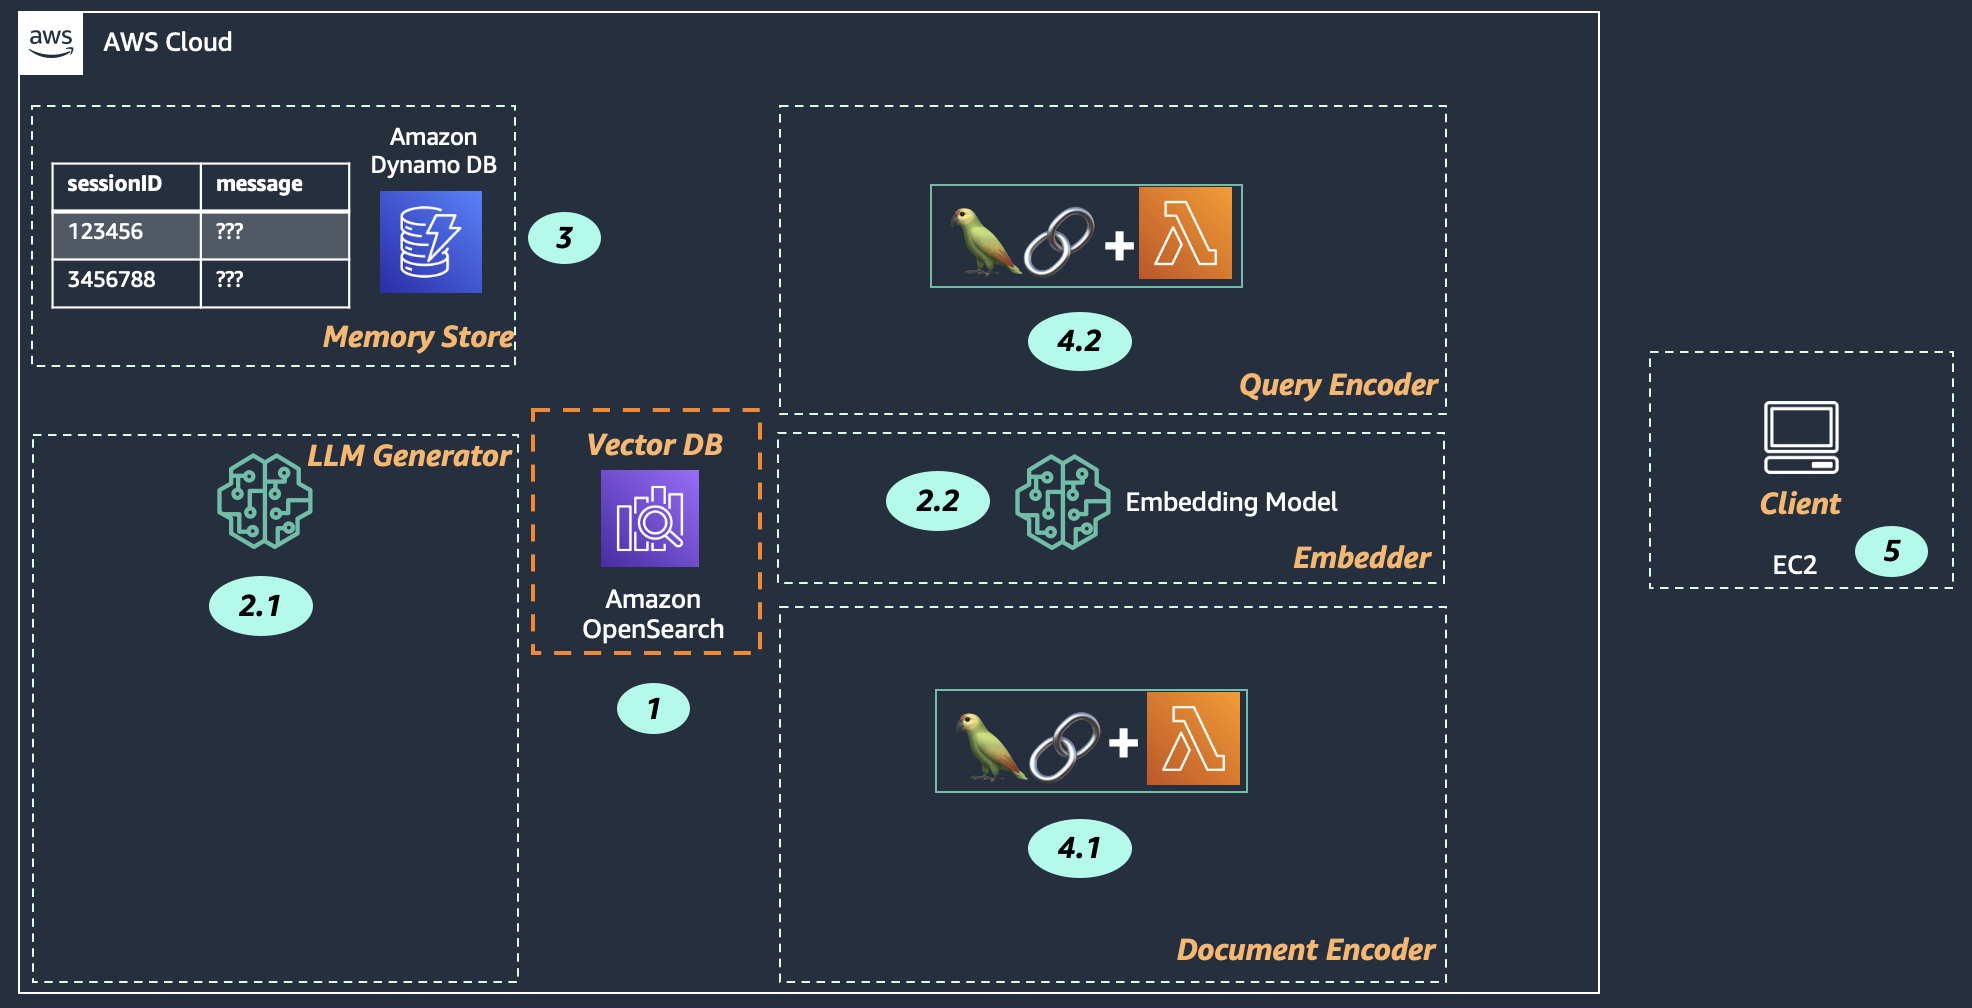
</div>

## 5.1 Copy the webapp code artefacts to ec2

In [179]:
#push the webapp code archive to s3

!cd webapp && zip ../webapp.zip * 
!aws s3 cp webapp.zip s3://$s3_bucket
    
response = cfn.describe_stack_resources(
    StackName=stackname
)
for resource in response['StackResources']:
    if(resource['ResourceType'] == 'AWS::EC2::Instance'):
        ec2_instance_id = resource['PhysicalResourceId']

query_invoke_URL_cmd = 'https://vmnid3idl4rljir2edomburjpq0yalrq.lambda-url.us-east-1.on.aws/'.replace("/","\/")#query_invoke_URL
print("\nec2_instance_id: "+ec2_instance_id)

updating: api.py (deflated 56%)
updating: app.py (deflated 65%)
updating: images/ (stored 0%)
updating: pdfs/ (stored 0%)
upload: ./webapp.zip to s3://semantic-search-gpu-s3buckethosting-h5ih9fpt8gtc/webapp.zip

ec2_instance_id: i-07731b4404d849021


## 5.2 Execute ssh comands in ec2 terminal to start the app

In [181]:
# function to execute commands in ec2 terminal
def execute_commands_on_linux_instances(client, commands):
    resp = client.send_command(
        DocumentName="AWS-RunShellScript", # One of AWS' preconfigured documents
        Parameters={'commands': commands},
        InstanceIds=[ec2_instance_id],
    )
    return resp['Command']['CommandId']


ssm_client = boto3.client('ssm') 

query_invoke_URL_cmd = query_invoke_URL.replace("/","\/")

commands = [
            'aws s3 cp s3://'+s3_bucket+'/webapp.zip /home/ec2-user/',
            'unzip -o /home/ec2-user/webapp.zip -d /home/ec2-user/'  ,      
            'sudo chmod -R 0777 /home/ec2-user/',
            'aws s3 cp /home/ec2-user/pdfs s3://'+s3_bucket+'/sample_pdfs/ --recursive',
            'sudo sed -i "s/API_URL_TO_BE_REPLACED/'+query_invoke_URL_cmd+'/g" /home/ec2-user/api.py',
            'sudo sed -i "s/pdf-repo-uploads/'+s3_bucket+'/g" /home/ec2-user/app.py',
            'python3 -m venv /home/ec2-user/.myenv',
            'source /home/ec2-user/.myenv/bin/activate',
            'pip install streamlit',
            'pip install boto3',
    
            #start the web applicaiton
            'streamlit run /home/ec2-user/app.py',
            
            ]

command_id = execute_commands_on_linux_instances(ssm_client, commands)

time.sleep(3)

response = ssm_client.get_command_invocation(
    CommandId=command_id,
    InstanceId=ec2_instance_id
)
print(response['Status'])
print('---------')
print(response['StandardOutputContent']+" The webserver is up and running")


InProgress
---------
 The webserver is up and running


### 5.2 check the ec2 ports which runs the app

In [189]:
#check the status of the applicaiton
commands = [
            "sudo lsof -i -P -n | grep 'streamlit'"
             ]

command_id = execute_commands_on_linux_instances(ssm_client, commands)

time.sleep(2)

response = ssm_client.get_command_invocation(
    CommandId=command_id,
    InstanceId=ec2_instance_id
)
print(response['Status'])
print('---------')
print(response['StandardOutputContent'])
print(response['StandardErrorContent'])


Success
---------
streamlit 2173            root    9u  IPv4  18197      0t0  TCP *:8501 (LISTEN)
streamlit 2173            root   10u  IPv6  18461      0t0  TCP *:8501 (LISTEN)
streamlit 2173            root   13u  IPv4  18208      0t0  TCP 172.31.41.241:8501->37.228.234.170:57892 (ESTABLISHED)
streamlit 2173            root   14u  IPv4  18541      0t0  TCP 172.31.41.241:34594->52.217.139.193:443 (CLOSE_WAIT)
streamlit 2173            root   15u  IPv4  18226      0t0  TCP 172.31.41.241:8501->37.228.234.170:57885 (ESTABLISHED)
streamlit 2173            root   16u  IPv4  18231      0t0  TCP 172.31.41.241:49430->3.5.25.40:443 (CLOSE_WAIT)
streamlit 2173            root   17u  IPv4  22928      0t0  TCP 172.31.41.241:8501->37.228.234.170:57960 (ESTABLISHED)
streamlit 2173            root   18u  IPv4  21972      0t0  TCP 172.31.41.241:48704->16.182.38.153:443 (CLOSE_WAIT)




### 5.3 Open the app using ec2 public DNS

In [190]:
ec2_ = boto3.client('ec2')
response = ec2_.describe_instances(
    InstanceIds=[ec2_instance_id]
)
public_ip = response['Reservations'][0]['Instances'][0]['PublicIpAddress']
print('http://'+public_ip+":8501")

http://52.200.167.77:8501
